<a href="https://colab.research.google.com/github/Anna172/Mainor/blob/master/Project_MMDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_samples, silhouette_score
import matplotlib.cm as cm # needed to set a color scheme
from sklearn.cluster import SpectralClustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist



# Data preparation

In [ ]:
data = pd.read_csv("SAS_creditors.csv", delimiter=',')
data.head()

ID  ... ninety_vintage
0  1000011  ...            NaN
1  1000031  ...            0.0
2  1000051  ...            0.0
3  1000071  ...            0.0
4  1000091  ...            NaN

[5 rows x 43 columns]

In [ ]:
data.shape

(10242, 43)

In [ ]:
data = data.drop("ID", axis = 1)
data.describe().transpose()

count       mean  ...         75%     max
INSURANCE_FLAG         10242.0   0.611892  ...    1.000000    1.00
DTI                    10120.0   0.387964  ...    0.490000    0.59
FULL_AGE_CHILD_NUMBER  10242.0   0.559852  ...    1.000000    5.00
DEPENDANT_NUMBER       10242.0   0.003613  ...    0.000000    3.00
BANKACCOUNT_FLAG        7938.0   0.371756  ...    0.000000    4.00
Period_at_work          7938.0  65.824137  ...   86.000000  502.00
age                     7938.0  36.297808  ...   42.000000   63.00
max90days               4016.0   1.671564  ...    2.000000   31.00
max60days               4016.0   1.203187  ...    2.000000   14.00
max30days               4016.0   0.894920  ...    1.000000   12.00
max21days               4016.0   0.679781  ...    1.000000   12.00
max14days               4016.0   0.563247  ...    1.000000   12.00
avg_num_delay           3747.0   0.060748  ...    0.072955    1.00
if_zalog                3763.0   0.314111  ...    1.000000    1.00
num_AccountActive180    3763.0   0.393835  ...    1.000000    5.00
num_AccountActive90     3763.0   0.172203  ...    0.000000    4.00
num_AccountActive60     3763.0   0.109221  ...    0.000000    4.00
Active_to_All_prc       3763.0   0.430621  ...    0.600000    1.00
numAccountActiveAll     3763.0   2.273186  ...    3.000000   15.00
numAccountClosed        3763.0   3.565506  ...    5.000000   53.00
sum_of_paym_months      3763.0  83.309328  ...  114.000000  698.00
all_credits             3763.0   5.838693  ...    8.000000   56.00
Active_not_cc           3763.0   1.110816  ...    2.000000    6.00
own_closed              3763.0   0.713526  ...    1.000000    9.00
min_MnthAfterLoan       3763.0  13.732129  ...   18.000000  106.00
max_MnthAfterLoan       3763.0  61.729471  ...   87.000000  156.00
dlq_exist               3763.0   0.573479  ...    1.000000    1.00
thirty_in_a_year        3763.0   0.148020  ...    0.000000    1.00
sixty_in_a_year         3763.0   0.085570  ...    0.000000    1.00
ninety_in_a_year        3763.0   0.063247  ...    0.000000    1.00
thirty_vintage          3763.0   0.030295  ...    0.000000    1.00
sixty_vintage           3763.0   0.014085  ...    0.000000    1.00
ninety_vintage          3763.0   0.017008  ...    0.000000    1.00

[33 rows x 8 columns]

При анализе описательных статистик было выявлено, что некоторые пременные, например, Period_at_work, sum_of_paym_months и max_MnthAfterLoan имеют выбросы. Так как максимальное значение в несколько раз отличается от 75% квантиле. Далее будет проведен более подробный анализ выбросов.

Выведем для удобства описание всех переменных с помощью дополнительного файла и рассмотрим их

In [ ]:
descr = pd.read_csv('SAS_features_description.csv', encoding='windows-1251',  sep=';')

In [ ]:
descr

Атрибуты;Описание
0                       Номер варианта;Номер варианта
1                            ID;Идентификатор клиента
2               INCOME_BASE_TYPE;Подтверждение дохода
3               CREDIT_PURPOSE;Цель получения кредита
4   INSURANCE_FLAG;Страхование заемщика при получе...
5   DTI;debt-to-income ratio — отношение долга к д...
6                                             SEX;Пол
7            FULL_AGE_CHILD_NUMBER;Кол-во лет ребенку
8                  DEPENDANT_NUMBER;Кол-во иждивенцев
9                               EDUCATION;Образование
10                                EMPL_TYPE;Должность
11                                 EMPL_SIZE;Зарплата
12  BANKACCOUNT_FLAG;Кол-во аккаунтов у клиента. (...
13          Period_at_work;Время работы (кол-во дней)
14                                        age;Возраст
15           EMPL_PROPERTY;Сфера бизнеса работодателя
16          EMPL_FORM;Организационно - правовая форма
17                      FAMILY_STATUS;Семейный статус
18  max90days;кол-во запросов в бюро кредитных ист...
19  max60days;кол-во запросов в бюро кредитных ист...
20  max30days;кол-во запросов в бюро кредитных ист...
21  max21days;кол-во запросов в бюро кредитных ист...
22  max14days;кол-во запросов в бюро кредитных ист...
23       avg_num_delay;Среднее кол-во задержки оплаты
24          if_zalog;Наличие залога (квартира,машина)
25  num_AccountActive180;кол-во активных счетов сч...
26  num_AccountActive90;кол-во активных счетов сче...
27  num_AccountActive60;кол-во активных счетов сче...
28  Active_to_All_prc;отношение активных счетов ко...
29         numAccountActiveAll;кол-во открытых счетоа
30            numAccountClosed;кол-во закрытых счетов
31  sum_of_paym_months;сумма платежей за последний...
32                        all_credits;Кол-во кредитов
33  Active_not_cc;Активные кредитные счета, но не ...
34                own_closed;Кол-во закрытых кредитов
35  min_MnthAfterLoan;минимальное кол-во месяцев, ...
36  max_MnthAfterLoan;кол-во месяцев прошеднее с м...
37       dlq_exist;наличие просрочки на данный момент
38  thirty_in_a_year;просрочка больше 30 дней за п...
39  sixty_in_a_year;просрочка больше 60 дней за по...
40  ninety_in_a_year;просрочка больше 90 дней за п...
41  thirty_vintage;просрочка больше 30 дней, когда...
42  sixty_vintage;просрочка больше 60 дней, когда-...
43  ninety_vintage;просрочка больше 90 дней, когда...

По каждой переменной набора данных рассчитаем: число уникальных значений (UNIQUE и PERCENT_UNIQUE), число нудевых значений (ZEROS и PERCENT_ZEROS), число пропущенных значений (NANS и PERCENT_NANS) и тип данных (DATA_TYPE). Результаты приведены в таблице ниже:

In [ ]:
columns = ["UNIQUE", 'PERCENT_UNIQUE', 'ZEROS', 'PERCENT_ZEROS', 'NANS', 'PERCENT_NANS', 'DATA_TYPE']
dt = pd.DataFrame(index=data.columns, columns=columns)

for col in data.columns:
  dt.loc[col,"UNIQUE"] = len(data[col].unique())
  dt.loc[col,"PERCENT_UNIQUE"] = dt.loc[col,"UNIQUE"]/len(data[col])*100
  dt.loc[col,"NANS"] = np.sum(data[col].isnull())
  dt.loc[col,"PERCENT_NANS"] = dt.loc[col,"NANS"]/len(data[col])*100
  dt.loc[col,"ZEROS"] = (data[col] == 0).sum()
  dt.loc[col,"PERCENT_ZEROS"] = dt.loc[col,"ZEROS"]/len(data[col])*100
  dt["DATA_TYPE"] = data.dtypes   

dt

UNIQUE PERCENT_UNIQUE  ZEROS  ...  NANS PERCENT_NANS DATA_TYPE
INCOME_BASE_TYPE           5      0.0488186      0  ...    61     0.595587    object
CREDIT_PURPOSE            10      0.0976372      0  ...     0            0    object
INSURANCE_FLAG             2      0.0195274   3975  ...     0            0     int64
DTI                       61       0.595587      2  ...   122      1.19117   float64
SEX                        2      0.0195274      0  ...     0            0    object
FULL_AGE_CHILD_NUMBER      6      0.0585823   6073  ...     0            0     int64
DEPENDANT_NUMBER           4      0.0390549  10214  ...     0            0     int64
EDUCATION                  9      0.0878735      0  ...     0            0    object
EMPL_TYPE                 10      0.0976372      0  ...     2    0.0195274    object
EMPL_SIZE                  9      0.0878735      0  ...   118      1.15212    object
BANKACCOUNT_FLAG           5      0.0488186   6287  ...  2304      22.4956   float64
Period_at_work           373        3.64187      0  ...  2304      22.4956   float64
age                       41       0.400312      0  ...  2304      22.4956   float64
EMPL_PROPERTY             13       0.126928      0  ...  2304      22.4956    object
EMPL_FORM                  7       0.068346      0  ...  6180      60.3398    object
FAMILY_STATUS              7       0.068346      0  ...  6180      60.3398    object
max90days                 19       0.185511   1000  ...  6226      60.7889   float64
max60days                 16       0.156219   1481  ...  6226      60.7889   float64
max30days                 14       0.136692   1932  ...  6226      60.7889   float64
max21days                 14       0.136692   2334  ...  6226      60.7889   float64
max14days                 14       0.136692   2549  ...  6226      60.7889   float64
avg_num_delay           1153        11.2576   1589  ...  6495      63.4153   float64
if_zalog                   3      0.0292912   2581  ...  6479      63.2591   float64
num_AccountActive180       7       0.068346   2648  ...  6479      63.2591   float64
num_AccountActive90        6      0.0585823   3209  ...  6479      63.2591   float64
num_AccountActive60        5      0.0488186   3405  ...  6479      63.2591   float64
Active_to_All_prc        102       0.995899    462  ...  6479      63.2591   float64
numAccountActiveAll       16       0.156219    443  ...  6479      63.2591   float64
numAccountClosed          29       0.283148    427  ...  6479      63.2591   float64
sum_of_paym_months       337        3.29037     17  ...  6479      63.2591   float64
all_credits               33       0.322203      0  ...  6479      63.2591   float64
Active_not_cc              8      0.0781097   1249  ...  6479      63.2591   float64
own_closed                11       0.107401   2157  ...  6479      63.2591   float64
min_MnthAfterLoan         96       0.937317    158  ...  6479      63.2591   float64
max_MnthAfterLoan        135         1.3181     12  ...  6479      63.2591   float64
dlq_exist                  3      0.0292912   1605  ...  6479      63.2591   float64
thirty_in_a_year           3      0.0292912   3206  ...  6479      63.2591   float64
sixty_in_a_year            3      0.0292912   3441  ...  6479      63.2591   float64
ninety_in_a_year           3      0.0292912   3525  ...  6479      63.2591   float64
thirty_vintage             3      0.0292912   3649  ...  6479      63.2591   float64
sixty_vintage              3      0.0292912   3710  ...  6479      63.2591   float64
ninety_vintage             3      0.0292912   3699  ...  6479      63.2591   float64

[42 rows x 7 columns]

BANK_ACCOUNT_FLAG имеется null, что свидетельствует о возможных некорректных данных(в описании данных расписаны все возможные состояния клиента в плане наличия у него онлайн-кабинета). Можно исключить такие данные. Или сделать пользователя среднестатистическим

In [ ]:
BAF = data['BANKACCOUNT_FLAG']
data['BANKACCOUNT_FLAG'] = BAF.fillna(BAF.mean())

Из таблицы можно заметить, что многие переменне имеют одинаковый процент пропущенных значений 64.83%. Эти наблюдения объединяет то, что они имеют цель кредита, но нет информации по текущим и по закрытым кредитам. Следовательно, можно сделать вывод, что это новые клиенты банка, которые еще не получили кредит, но отправили запрос на получение кредита. Возможно, среди них также есть те, кому кредит не одобрили. Также все эти переменные принимают только положительные значения. Поэтому пропущенные значения переменных связанных с наличием кредита, можно заменить на -0.01. Так мы сможем отличать этот большой кластер новых клиентов, от других, уже имеющих кредит.

!!!Уточнение
Мы можем себе позволить сделать -0.01 т.к. по факту это есть отсутствие информации, т.е. клиент новый и т.п., в реальности нам этот -0.01 даст большое смещение среднего, что стоит принять во внимание, если мы будем строить скоринговую модель, в качестве решения проблемы - разделение клиентов на два или больше больших кластеров и отдельное их изучение)


In [ ]:
columns_p = ['ninety_vintage', 'sixty_vintage', 'thirty_vintage', 'ninety_in_a_year', 'sixty_in_a_year', 'thirty_in_a_year',
               'dlq_exist', 'max_MnthAfterLoan', 'min_MnthAfterLoan', 'own_closed', 'Active_not_cc', 'all_credits', 'sum_of_paym_months',
             'numAccountClosed', 'numAccountActiveAll',  'Active_to_All_prc',  'num_AccountActive60', 'num_AccountActive90', 'num_AccountActive180',
             'if_zalog', 'avg_num_delay']
for column in columns_p:
    data[column] = data[column].fillna(-0.01)

Далее можно заметить, что количество запросов в бюро кредитных историй имеет уже меньший процент пропущенных значений(61.32%), чем у переменных связанных с имением кредитов(64.83%). Соответственно можно сделать выводы, что 3.51% - это и есть те новые клиенты, которые только собираются получить кредит, а остальные 61.32%, это не получившие кредит клиенты банка. Соответственно количество запросов по ним равно 0. Заменим пропущенные значения.

In [ ]:
columns_bki = ['max90days', 'max60days', 'max30days', 'max21days', 'max14days']
for column in columns_bki:
    data[column] = data[column].fillna(0)

У многих не указан FAMILY_STATUS, EMPL_FORM и другие категориальные переменные. Заменим пропуски на значение unknown

In [ ]:
for name in ['FAMILY_STATUS', 'EMPL_FORM', 'EMPL_PROPERTY', 'EMPL_SIZE', 'EMPL_TYPE', 'INCOME_BASE_TYPE' ]:
    data[name] = data[name].fillna('unknown')


Сказать что-то о распределении возраста заемщика и других численных переменных при отсутствии информации сложно, просто заполним средним значением

In [ ]:
columns_n = ['age', 'Period_at_work', 'DTI']
for column in columns_n:
    data[column] = data[column].fillna(data[column].mean())

In [ ]:
# создадим список переменых типа object, чтобы потом кодировать их в числовые переменные

object_type_columns = dt[dt['DATA_TYPE'] == 'object'].index.tolist()
notobject_type_columns = dt[dt['DATA_TYPE'] != 'object'].index.tolist()


print(len(object_type_columns), len(notobject_type_columns))


9 33


По численным переменным (без учета выбрасов) была построена корреляционная карта:

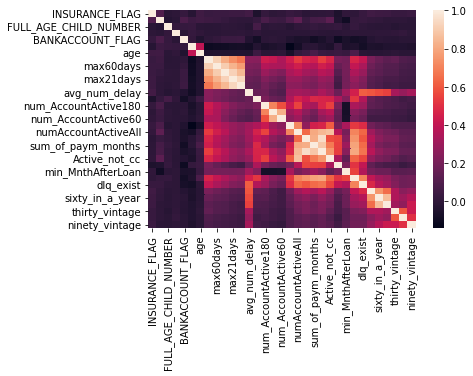

In [ ]:
sns.heatmap(data[notobject_type_columns].corr())

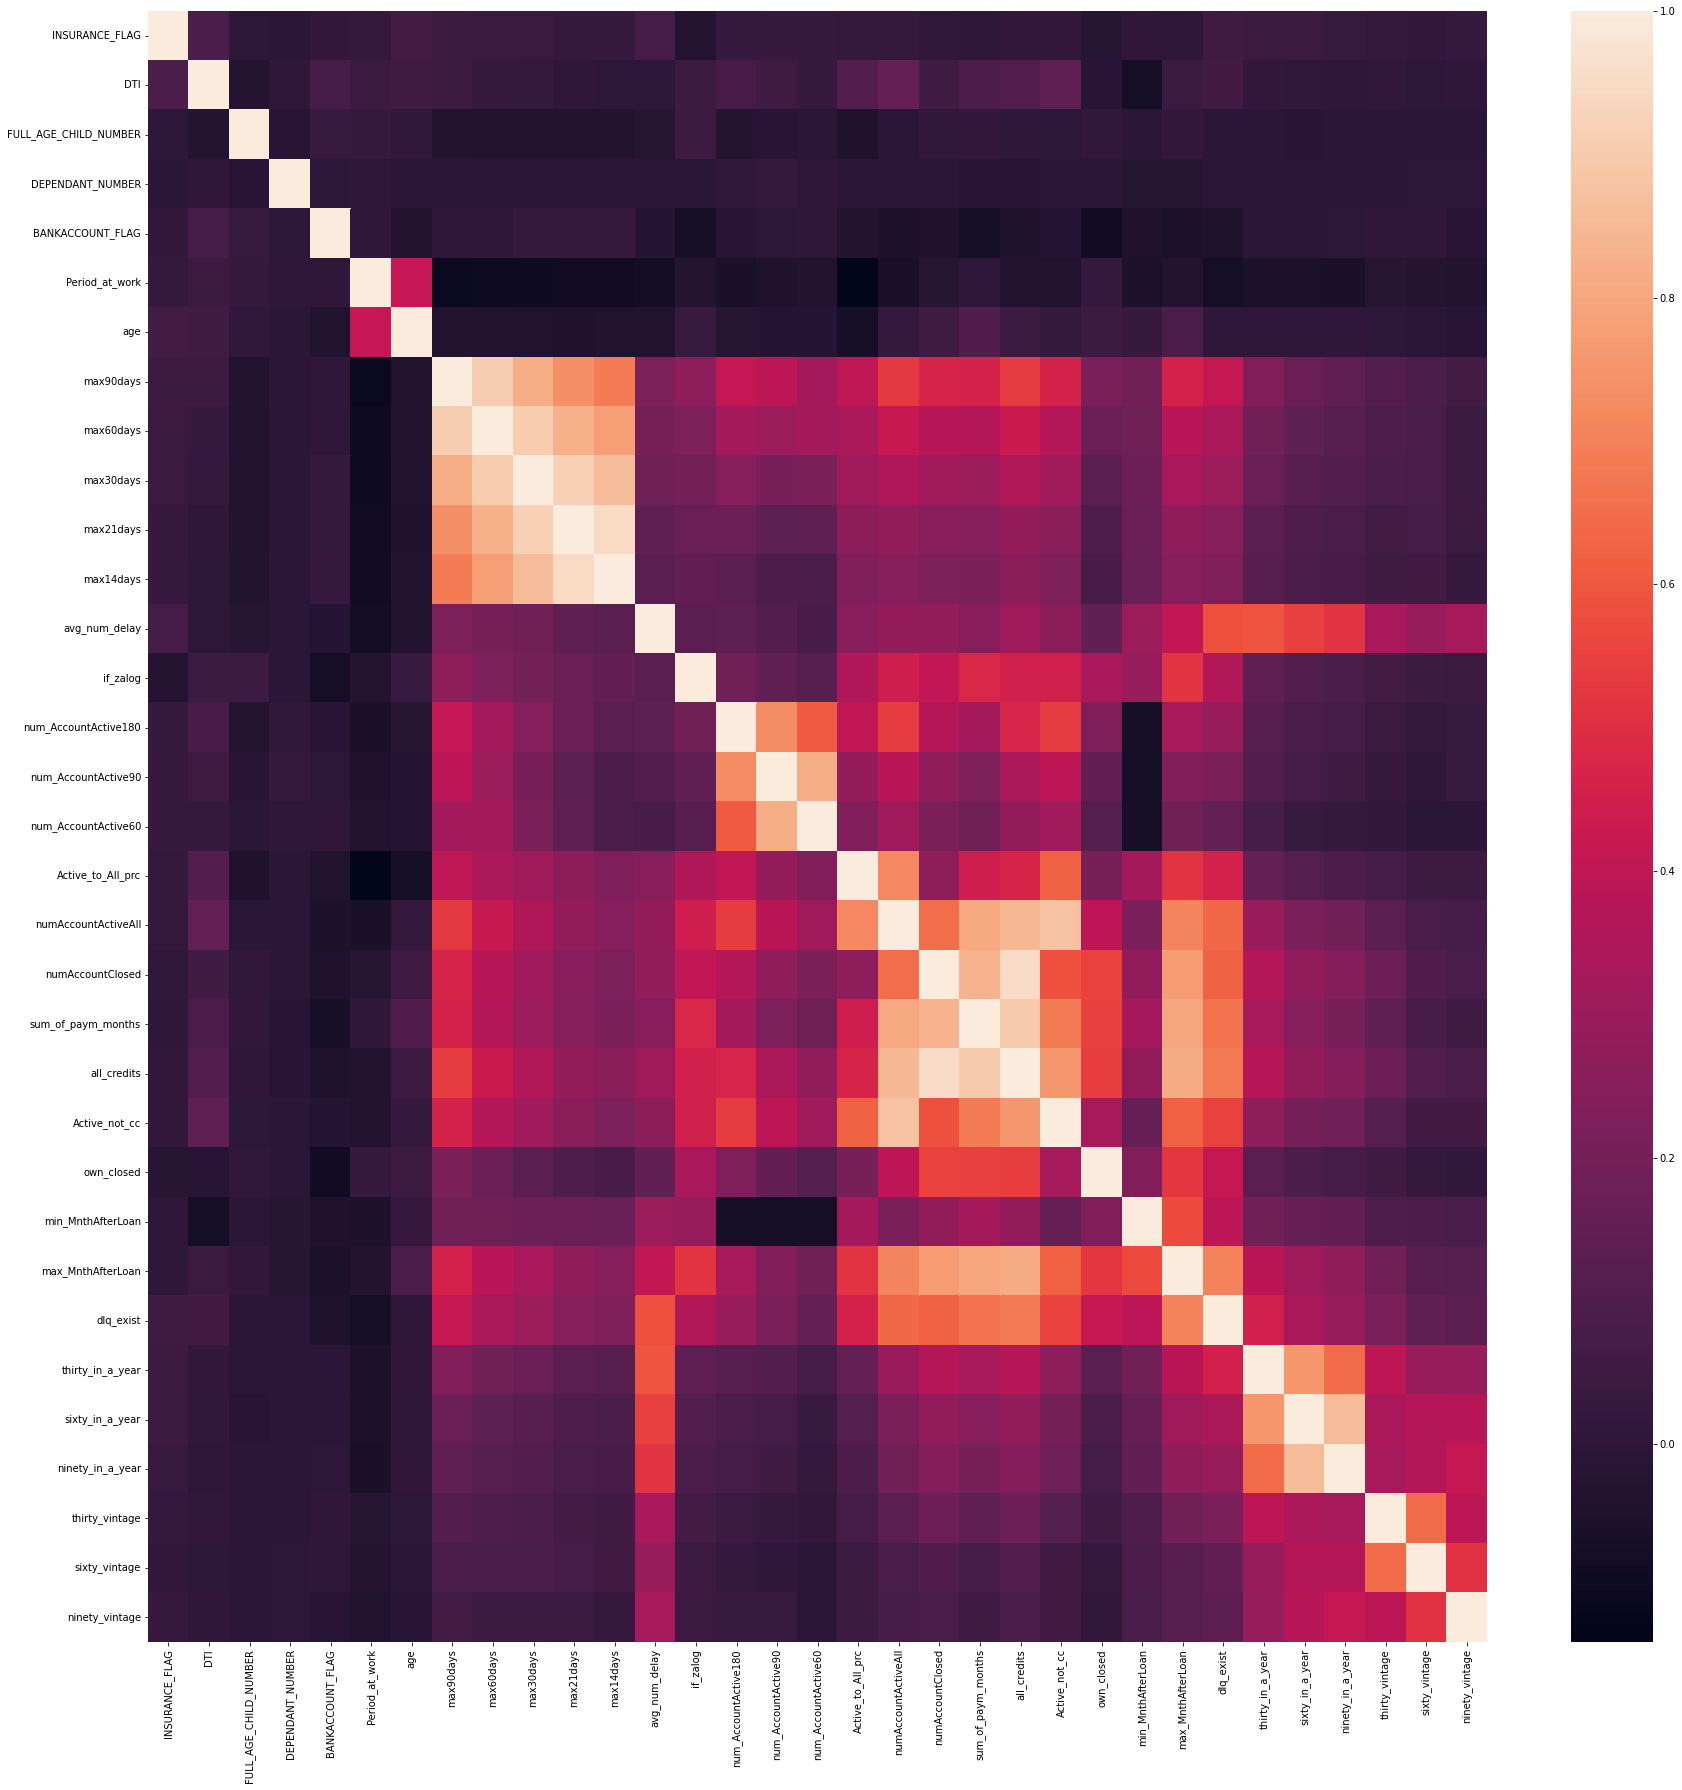

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))   
ax = sns.heatmap(data[notobject_type_columns].corr())
plt.savefig('./heatmap.png')
plt.show()

Заметим, что переменные отвечающие за количество запросов в бюро сильно коллерируют между собой, поэтому можем оставить лишь одно своийство из них. Также поступим и с другими сильно коррелирующими друг с другом переменными.

In [ ]:
data = data.drop(['numAccountClosed', 'numAccountActiveAll', 'sum_of_paym_months', 'Active_not_cc', 'max90days', 'max60days', 'max21days', 'max14days', 'num_AccountActive180', 'num_AccountActive60', 'max_MnthAfterLoan', 'thirty_in_a_year', 'ninety_in_a_year' ], axis=1)

for col in ['numAccountClosed', 'numAccountActiveAll', 'sum_of_paym_months', 'Active_not_cc', 'max90days', 'max60days', 'max21days', 'max14days', 'num_AccountActive180', 'num_AccountActive60', 'max_MnthAfterLoan', 'thirty_in_a_year', 'ninety_in_a_year']:
  notobject_type_columns.remove(col)


print(len(object_type_columns), len(notobject_type_columns))


9 20


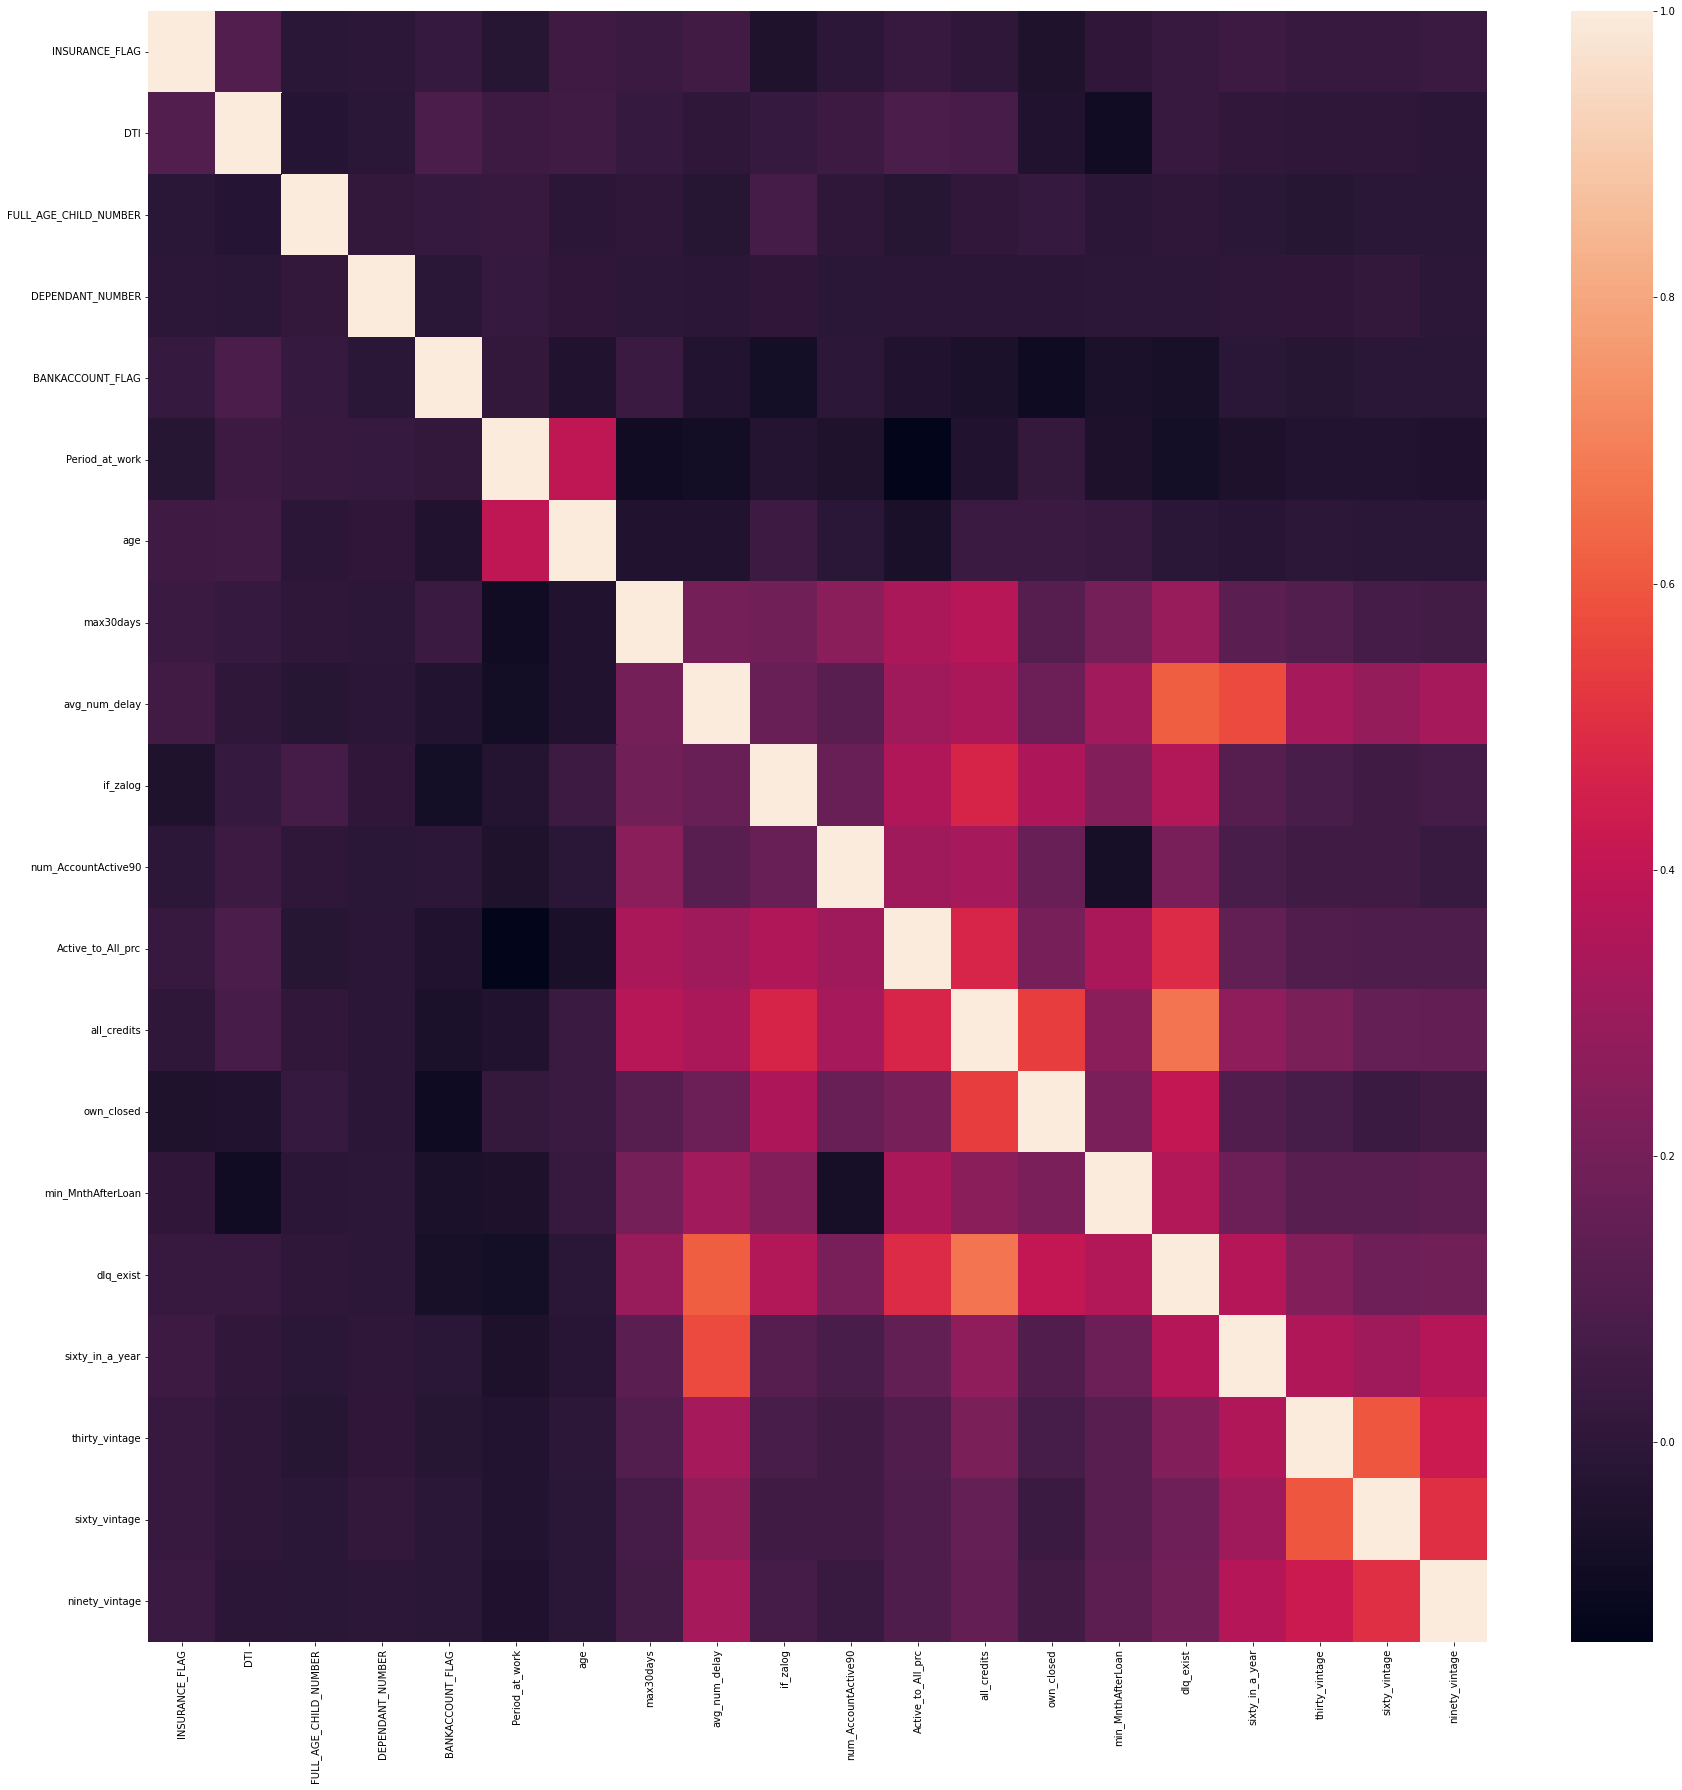

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))   
ax = sns.heatmap(data[notobject_type_columns].corr())
plt.savefig('./heatmap.png')
plt.show()

На рисунке ниже приведены гистограммы по численным переменным (с опущенными пропусками) набора данных:

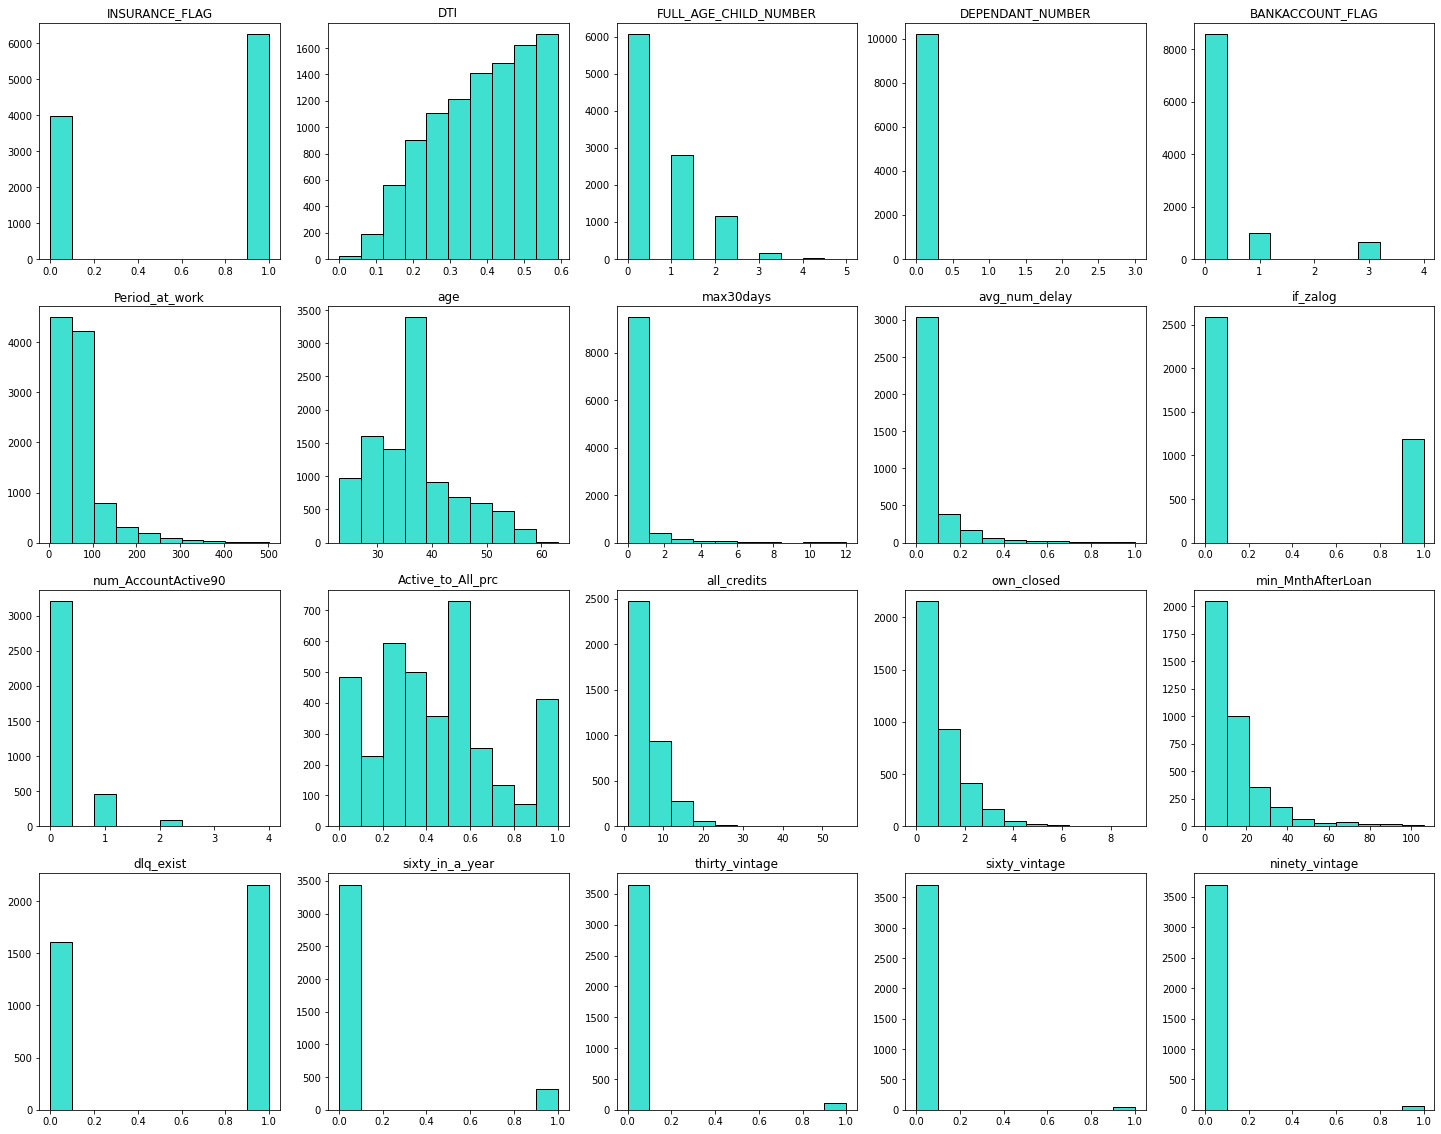

In [ ]:
r = 4
c = 5
numeric_data = data[notobject_type_columns].select_dtypes(include=np.number)
fig, ax = plt.subplots(r, c, figsize = (c*5, r*5))

i = 0
j = 0

for col in numeric_data.columns:
    if (i < r) & (j < c): 
      ax[i, j].hist(numeric_data[numeric_data[col] >= 0][col], color = 'turquoise', edgecolor = 'black')
      ax[i, j].set_title(col)
      j += 1
    elif (i < r) & (j == c):
      j = 0
      i += 1
      ax[i, j].hist(numeric_data[numeric_data[col] >= 0][col], color = 'turquoise', edgecolor = 'black')
      ax[i, j].set_title(col)
      j += 1
    else:
      print('ERROR')  
 
plt.show()

Из визуального анализа гистограмм можно заметить, что в выборке присутствуют, в основном, молодое поколение (до 40 лет) с небольшим количеством дней работы(до 100 дней), и отсутствуют пожилые люди (после 60 лет), а также люди, работающие более года (AGE и Period_at_work). Также в выборке достаточно много индивидов с высоким отношением долга к доходам (DTI). Также много человек с низким числом активных кредитов и банковских счетов (all_credits). Это наводит на мысль, что в данных должны проявиться как минимум следующие кластеры: молодые люди, взявшие один кредит и имеющие низкие доход, имеющие высокое соотношение долга к доходам, люди среднего возраста, имеющие активную кредитную историю, и еще не имеющие кредита клиенты банка.

Теперь посмотрим на категориальные переменные. Проверим на наличие некорректных ззнаков. Так как переменных для проверки немного, уникальных значений в них тоже немного, поэтому можно провести проверку на наличие некорректных знаков путем простого просмотра уникальных значений.

In [ ]:
for col in object_type_columns:
  print(col, data[col].unique().tolist())

INCOME_BASE_TYPE ['Поступление зарплаты на счет', 'Форма банка (без печати работодателя)', '2НДФЛ', 'Свободная форма с печатью работодателя', 'unknown']
CREDIT_PURPOSE ['Другое', 'Лечение', 'Покупка автомобиля', 'Ремонт', 'Покупка недвижимости/ строительство', 'Покупка земли', 'Покупка мебели', 'Отпуск', 'Покупка бытовой техники', 'Обучение']
SEX ['женский', 'мужской']
EDUCATION ['высшее', 'среднее-специальное', 'незаконченное высшее', 'Высшее/Второе высшее/Ученая степень', 'второе высшее', 'среднее', '*n.a.*', 'ученая степень', 'Неполное среднее']
EMPL_TYPE ['вспомогательный персонал', 'специалист', 'менеджер среднего звена', 'менеджер высшего звена', 'рабочий', 'менеджер по продажам', 'торговый представитель', 'другое', 'страховой агент', 'unknown']
EMPL_SIZE ['>100', '>250', '< 50', '>=50', '>=200', '>=150', '>=100', 'unknown', '*n.a.*']
EMPL_PROPERTY ['unknown', 'Торговля', 'Информационные технологии', 'Производство', 'Строительство', 'Транспорт', 'Государственная служба', 'Другое'

In [ ]:
data['EDUCATION'] = data['EDUCATION'].replace('*n.a.*', 'unknown')
data['EMPL_SIZE'] = data['EMPL_SIZE'].replace('*n.a.*', 'unknown')
data.shape

(10242, 29)

Теперь рассмотрим распределение данных по категориальным переменным (c опущенными пропущенными значениями для изначально числовых переменных).

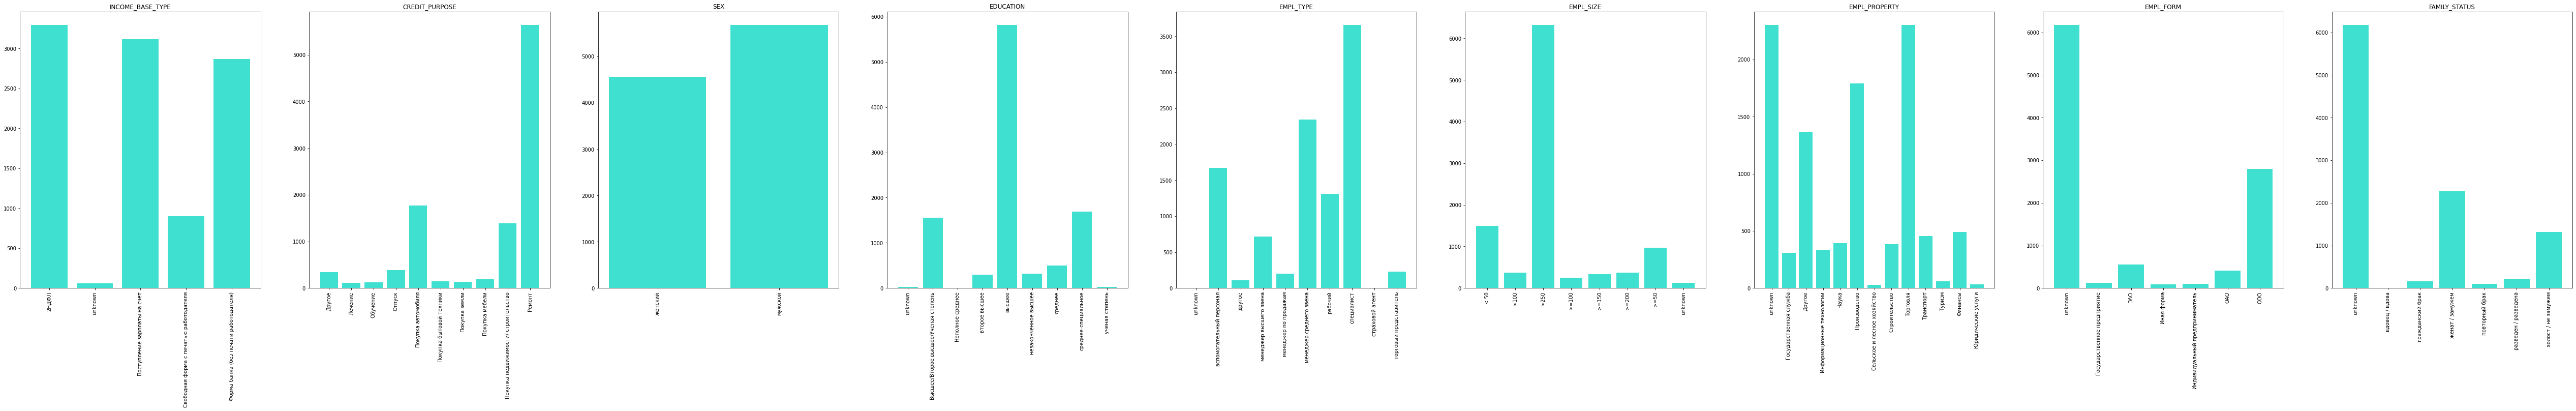

In [ ]:
categorical = data.dtypes[data.dtypes == 'object'].index
fig, ax = plt.subplots(1, 9, figsize=(90, 10))
for i, column in enumerate(list(categorical)):
    df_new = data[['DTI', column]].groupby([column]).count() # name dti is random in fact it's count values
    ax[i].bar(df_new.index.values, df_new.DTI, label=column, color = 'turquoise')
    ax[i].tick_params(axis='x', labelrotation=90)
    ax[i].set_title(column)
plt.savefig('./distplots2.png', facecolor='w', edgecolor='w')
plt.show()

Можно отметить, что соотношение категориальных переменных, в основном, непропорционально, а потому они не являются подходящим для сегментации признаками. Переменные INCOME_BASE_TYPE и SEX распределены пропорционально и не имеют выбросов, что сохраняет принцип онородности-разнородности, так как нет "скошенности" в одну сторону категории, и категории четко различимы в данных, поэтому они будут хорошими признаками для сегментации.

Теперь проведем анализ выбросов в числовых наборах данных. Для этого построим боксплоты.

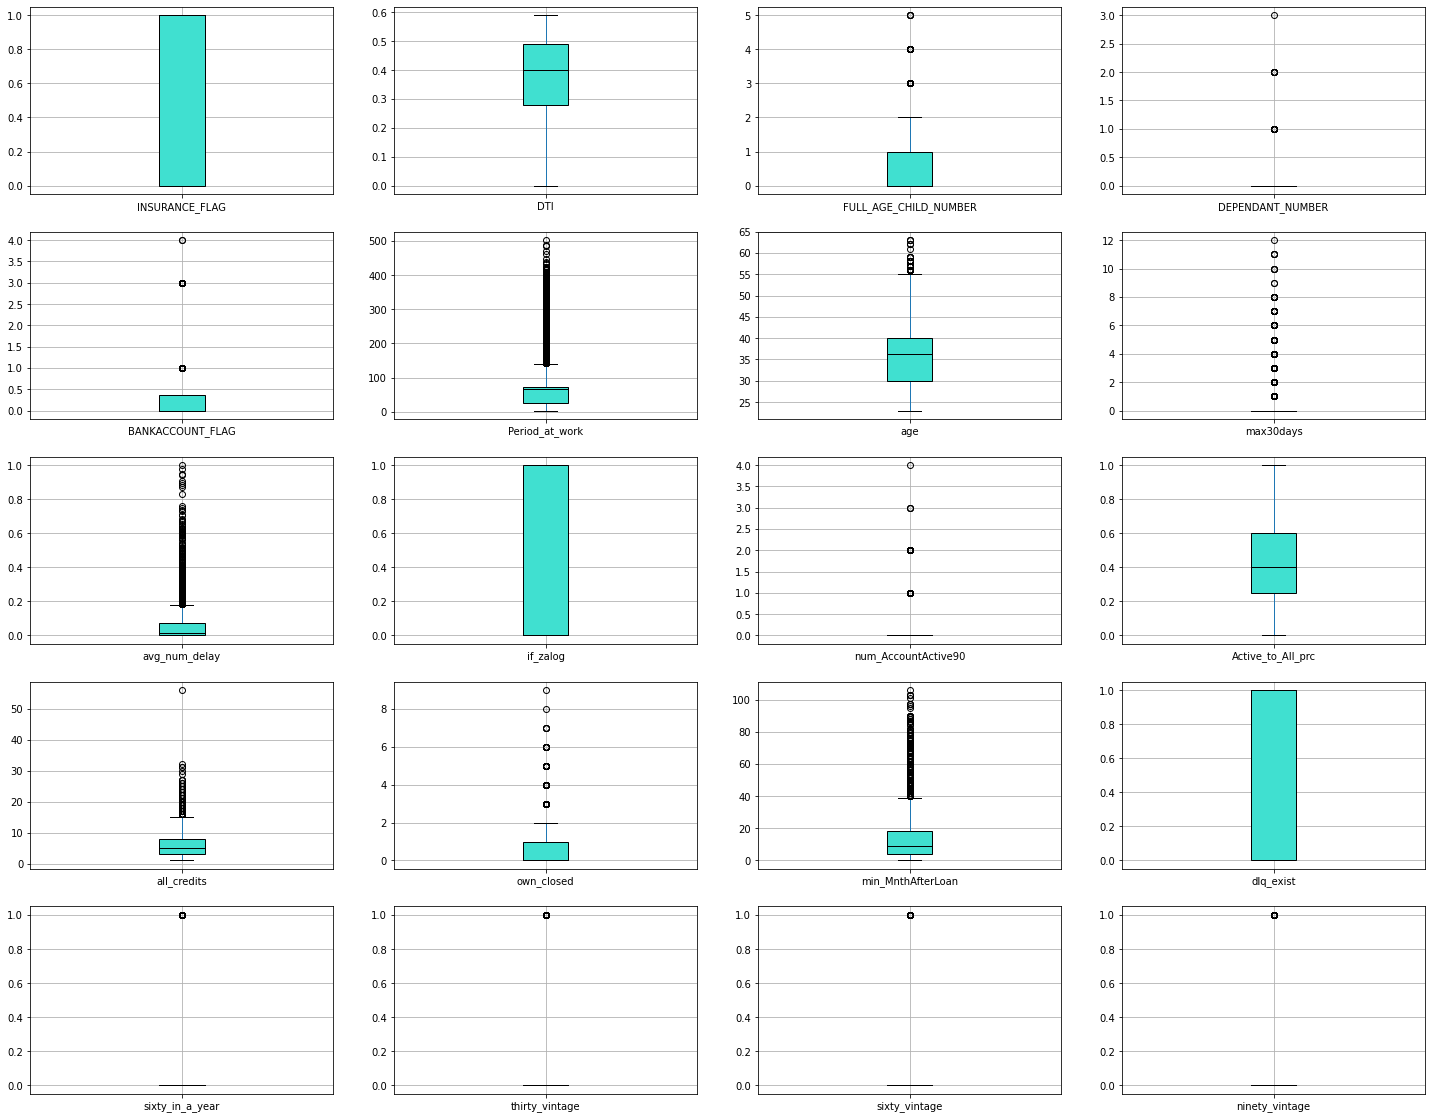

In [ ]:
r = 5
c = 4
numeric_data = data[notobject_type_columns].select_dtypes(include=np.number)
fig, ax = plt.subplots(r, c, figsize = (r*5, c*5))

i = 0
j = 0

for col in numeric_data.columns:
    if (i < r) & (j < c):
      numeric_data[numeric_data[col] >= 0].boxplot(column=col, ax=ax[i, j], patch_artist=True, 
                           boxprops=dict(facecolor='turquoise', color='black'),
                           medianprops=dict(color='black'))
                           
      j += 1
    elif (i < r) & (j == c):
      j = 0
      i += 1
      numeric_data[numeric_data[col] >= 0].boxplot(column=col, ax=ax[i, j], patch_artist=True, 
                           boxprops=dict(facecolor='turquoise', color='black'),
                           medianprops=dict(color='black'))
      j += 1
    else:
      print('ERROR')  
 
plt.show()

Переменные DTI, Insurance_flag, if_zalog, Active_to_All_prc и diq_exist не имеют выбрасов, поэтому их хорошо использовать в модели. Такие поля как Period_at_work, avg_num_delay, min_MonthAfterLoan и all_credits имеют очень большое количество выбросов. Удалять выбросы нецелесообразно, так как их много и они скорее говорят о большой вариации данных переменных.

In [ ]:
categorical = data.dtypes[data.dtypes == 'object'].index
numeric = data.select_dtypes([np.number])

In [ ]:
df_nc = data[data['dlq_exist'] < 0] # data not credit - data about clients without credits
df_c = data[data['dlq_exist'] > 0] # data credit - data about clients with credits
print(df_c.shape)
df_nc.shape

(2158, 29)


(6479, 29)

In [ ]:
df_d_c = pd.get_dummies(df_c)
print(df_d_c.shape)

df_d_nc = pd.get_dummies(df_nc)
print(df_d_nc.shape)

df_d = pd.get_dummies(data)
print(df_d.shape)
df_d.head()

(2158, 71)
(6479, 90)
(10242, 91)


INSURANCE_FLAG  ...  FAMILY_STATUS_холост / не замужем
0               0  ...                                  0
1               1  ...                                  1
2               1  ...                                  1
3               1  ...                                  1
4               1  ...                                  0

[5 rows x 91 columns]

In [ ]:

from sklearn.preprocessing import StandardScaler

df_ds = StandardScaler().fit_transform(df_d)
print(df_ds.shape)

df_ds_c = StandardScaler().fit_transform(df_d_c)
print(df_ds_c.shape)

df_ds_nc = StandardScaler().fit_transform(df_d_nc)
print(df_ds_nc.shape)

(10242, 91)
(2158, 71)
(6479, 90)


In [ ]:
df_ds

array([[-1.25562884, -0.42604169, -0.7226118 , ..., -0.09879487,
        -0.14573403, -0.38397195],
       [ 0.79641369,  0.74996701, -0.7226118 , ..., -0.09879487,
        -0.14573403,  2.60435688],
       [ 0.79641369,  1.48497245, -0.7226118 , ..., -0.09879487,
        -0.14573403,  2.60435688],
       ...,
       [ 0.79641369, -0.64654332, -0.7226118 , ..., -0.09879487,
        -0.14573403, -0.38397195],
       [ 0.79641369,  0.97046864,  0.56810848, ..., -0.09879487,
        -0.14573403, -0.38397195],
       [ 0.79641369, -0.57304278, -0.7226118 , ..., -0.09879487,
        -0.14573403, -0.38397195]])

# K-Means

In [ ]:
def value_counts(X, y=None):
    for c in X.columns:
        print("---- %s ---" % c)
        if y is None:
            print(X[c].value_counts())
        else:
            print(pd.pivot_table(pd.DataFrame({c: X[c].values, 'cluster': y}), index=[c], columns=['cluster'], aggfunc=len))

In [ ]:
def estimate_param(X, n_clusters, name_of_alg=None):
  
  fig, ax = plt.subplots(3, 3, figsize=( 3 * 8, 3 * 6))
  #plt.subplots(constrained_layout=True)
  fig.tight_layout()
  for k, n in enumerate(n_clusters):
    s = ''
    if (name_of_alg == 'K-Means, clusters'):
      kmeans = KMeans(n_clusters=n, random_state=10, max_iter=1000)
      y_pred = kmeans.fit_predict(X)
    elif (name_of_alg == 'MiniBatch K-Means, clusters'):
      k_means = cluster.MiniBatchKMeans(n_clusters=n)
      y_pred = k_means.fit_predict(df_ds)
    elif (name_of_alg == 'Ward, clusters'):
      ward_agc = AgglomerativeClustering(n_clusters=n, linkage='ward')
      y_pred = ward_agc.fit_predict(X)
    elif (name_of_alg == 'Average, clusters'):
      average_agc = AgglomerativeClustering(n_clusters=n, linkage='average')
      y_pred = average_agc.fit_predict(X)  
    elif (name_of_alg == 'Complete, clusters'):
      complete_agc = AgglomerativeClustering(n_clusters=n, linkage='complete')
      y_pred = complete_agc.fit_predict(X)  
    elif (name_of_alg == 'Spectral clustering (nn), clusters'):
      spectral = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', n_neighbors=10) 
      y_pred = spectral.fit_predict(X) 
    elif (name_of_alg == 'Gaussian core, clusters'):
      spectral = SpectralClustering(n_clusters=n, affinity='rbf', n_neighbors=10) 
      y_pred = spectral.fit_predict(X) 

       

    if not (name_of_alg is None):
        #print(("Algorithm: " + name_of_alg + str(n)))
        s += "\n Algorithm: " + name_of_alg + str(n)
    
    # Calinski-Harabaz - ratio between the within-cluster dispersion and the between-cluster dispersion
    # Greater is better: BCD/WCD
    # print("Calinski-Harabaz: %.4f" % calinski_harabasz_score(X, y_pred))
    s += "\n Calinski-Harabaz: %.4f" % calinski_harabasz_score(X, y_pred)

    silhouette_avg = silhouette_score(X, y_pred)
    # print("Average silhouette: %.4f" % silhouette_avg)
    s += "\n Average silhouette: %.4f" % silhouette_avg
    #n_clusters = len(np.unique(y_pred))

    # Show how silhouettes are chaged in each cluster
    
    ax[k // 3, k % 3].set_xlim([-0.1, 1])
    # 10 is needed for indentation
    ax[k // 3, k % 3].set_ylim([0, len(X) + (n + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10
    # iterate over all the clusters
    for i in range(n):
        # Aggregate and sort silhouettes of objects in the cluster i
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap("nipy_spectral")(float(i) / n)
        ax[k // 3, k % 3].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Print the number of the cluster
        ax[k // 3, k % 3].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute a new lower boundary between cluster silhouettes 
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[k // 3, k % 3].set_title("Silhouettes of different clusters" + s)
    ax[k // 3, k % 3].set_xlabel("Silhouette value")
    ax[k // 3, k % 3].set_ylabel("Cluster number")
    #ax[k // 3, k % 3].text(0.5, 3, s)

    # Vertical line shows average value
    ax[k // 3, k % 3].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[k // 3, k % 3].set_yticks([])
    ax[k // 3, k % 3].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.tight_layout()


In [ ]:
num_features = data.select_dtypes([np.number]).columns
cat_features = [c for c in data.columns if not(c in num_features)]

In [ ]:
# Lets determine the optimal number of clusters for K-Means 
J = []
params = np.arange(1, 40)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, max_iter=1000)
    kmeans.fit(df_ds)
    J.append(kmeans.inertia_)
J = np.array(J)

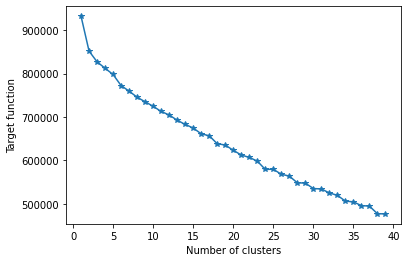

In [ ]:
plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Target function')
plt.show()

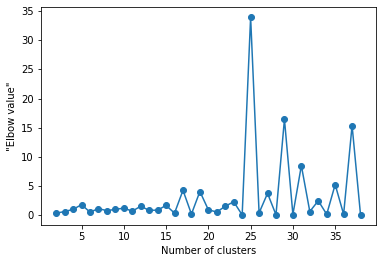

In [ ]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('\"Elbow value\"')
plt.show()

The elbow value was ruther stabe while number of clusters grow to 15, and then began fluctuate, so let's try to train K-Means with 2 - 10 clusters and look at the results.

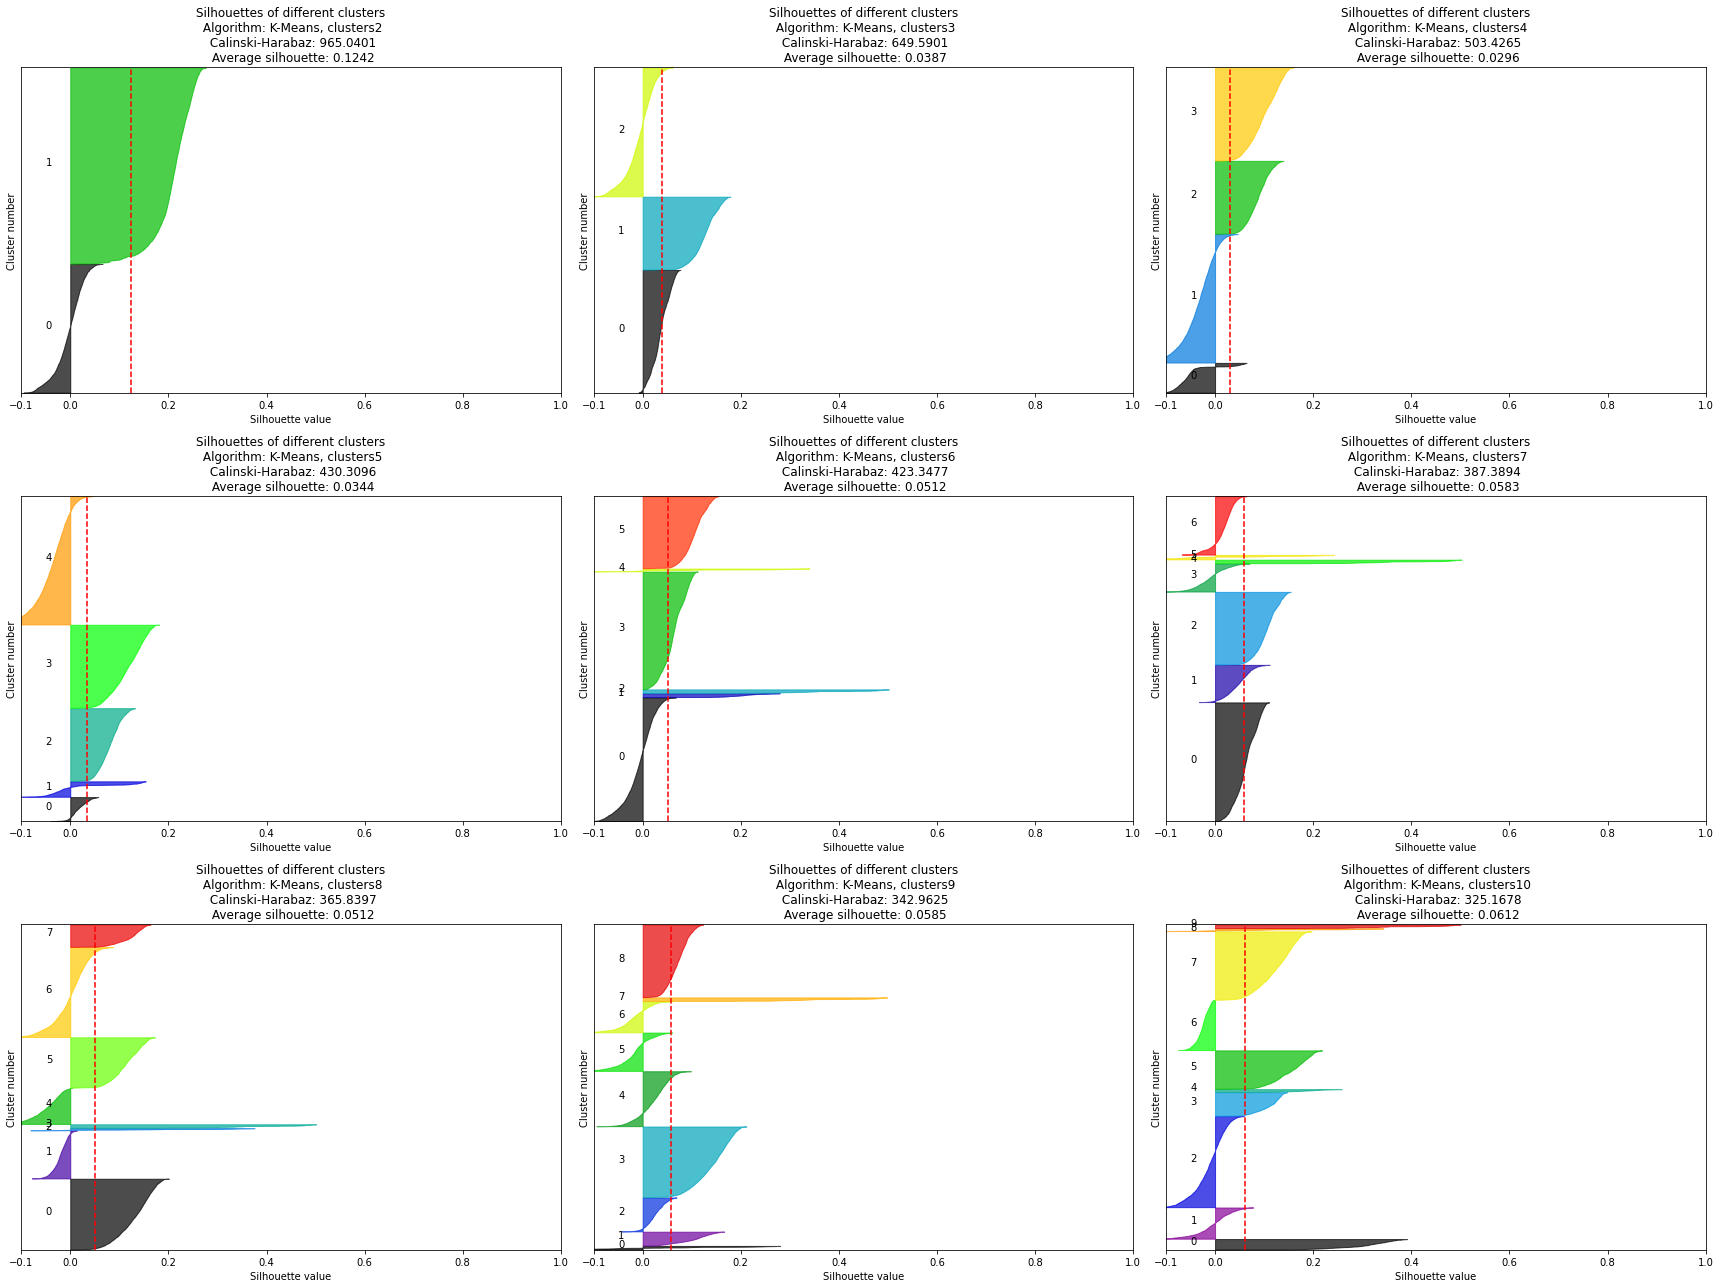

In [ ]:
estimate_param(df_ds, range(2, 11), 'K-Means, clusters')

The average silhouette and the Calinski-Harabaz measure has decreased. So we assume that 2 is optimal parametr for k. Let's see which objects fall into different clusters.

In [ ]:
kmeans3 = KMeans(n_clusters=2, random_state=10, max_iter=1000)
y_pred3 = kmeans3.fit_predict(df_ds)
value_counts(data[cat_features], y_pred3)

---- INCOME_BASE_TYPE ---
cluster                                      0       1
INCOME_BASE_TYPE                                      
2НДФЛ                                   1040.0  2258.0
unknown                                    NaN    61.0
Поступление зарплаты на счет            1499.0  1615.0
Свободная форма с печатью работодателя   378.0   521.0
Форма банка (без печати работодателя)   1145.0  1725.0
---- CREDIT_PURPOSE ---
cluster                                 0     1
CREDIT_PURPOSE                                 
Другое                                162   176
Лечение                                49    63
Обучение                               56    66
Отпуск                                157   228
Покупка автомобиля                    677  1090
Покупка бытовой техники                64    86
Покупка земли                          45    94
Покупка мебели                         88   105
Покупка недвижимости/ строительство   506   885
Ремонт                               

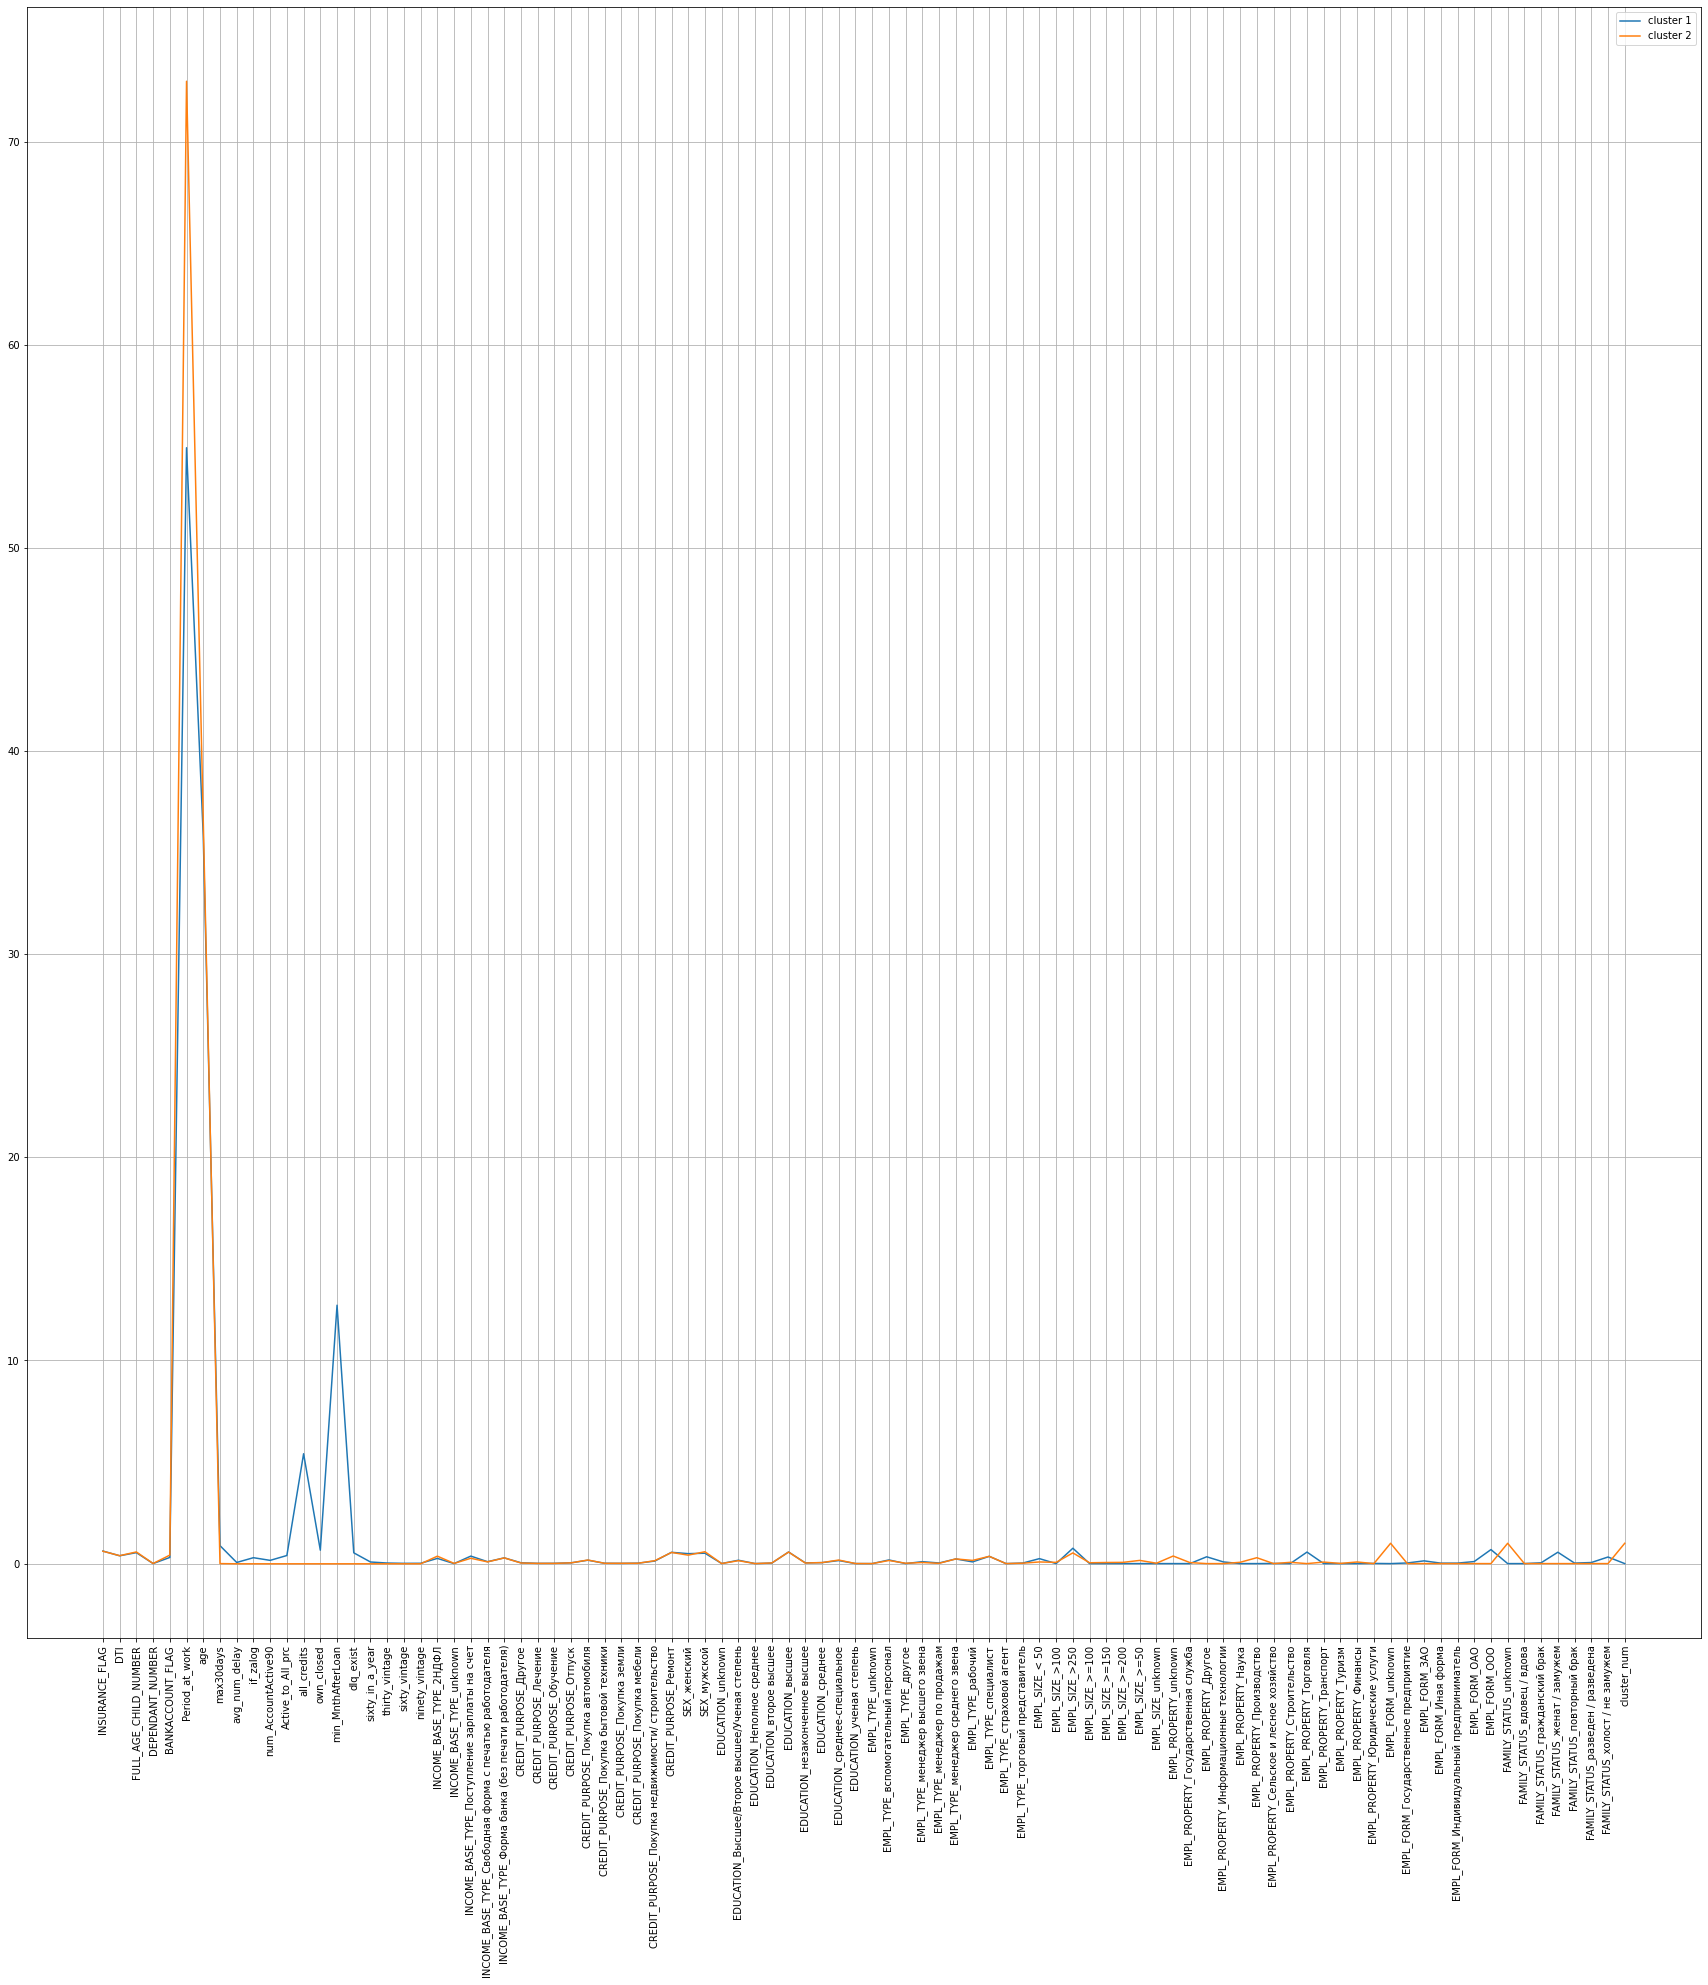

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(df_ds)
df_d['cluster_num'] = kmeans.fit_predict(df_ds)

plt.figure(figsize=(30,30))
for i in range(2):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.savefig('./kmeans_2.png')
plt.show()

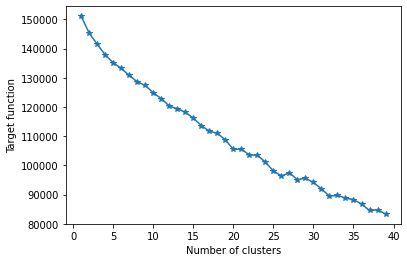

In [ ]:
# Lets determine the optimal number of clusters for K-Means 
J = []
params = np.arange(1, 40)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, max_iter=1000)
    kmeans.fit(df_ds_c)
    J.append(kmeans.inertia_)
J = np.array(J)

plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Target function')
plt.show()

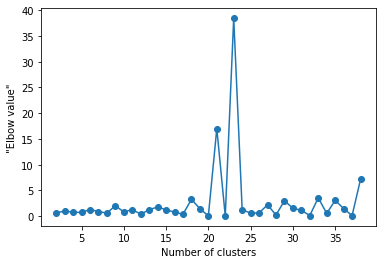

In [ ]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('\"Elbow value\"')
plt.show()

The elbow value was ruther stabe while number of clusters grow to 8, and then began fluctuate, so let's try to train K-Means with 2 - 8 clusters and look at the results.

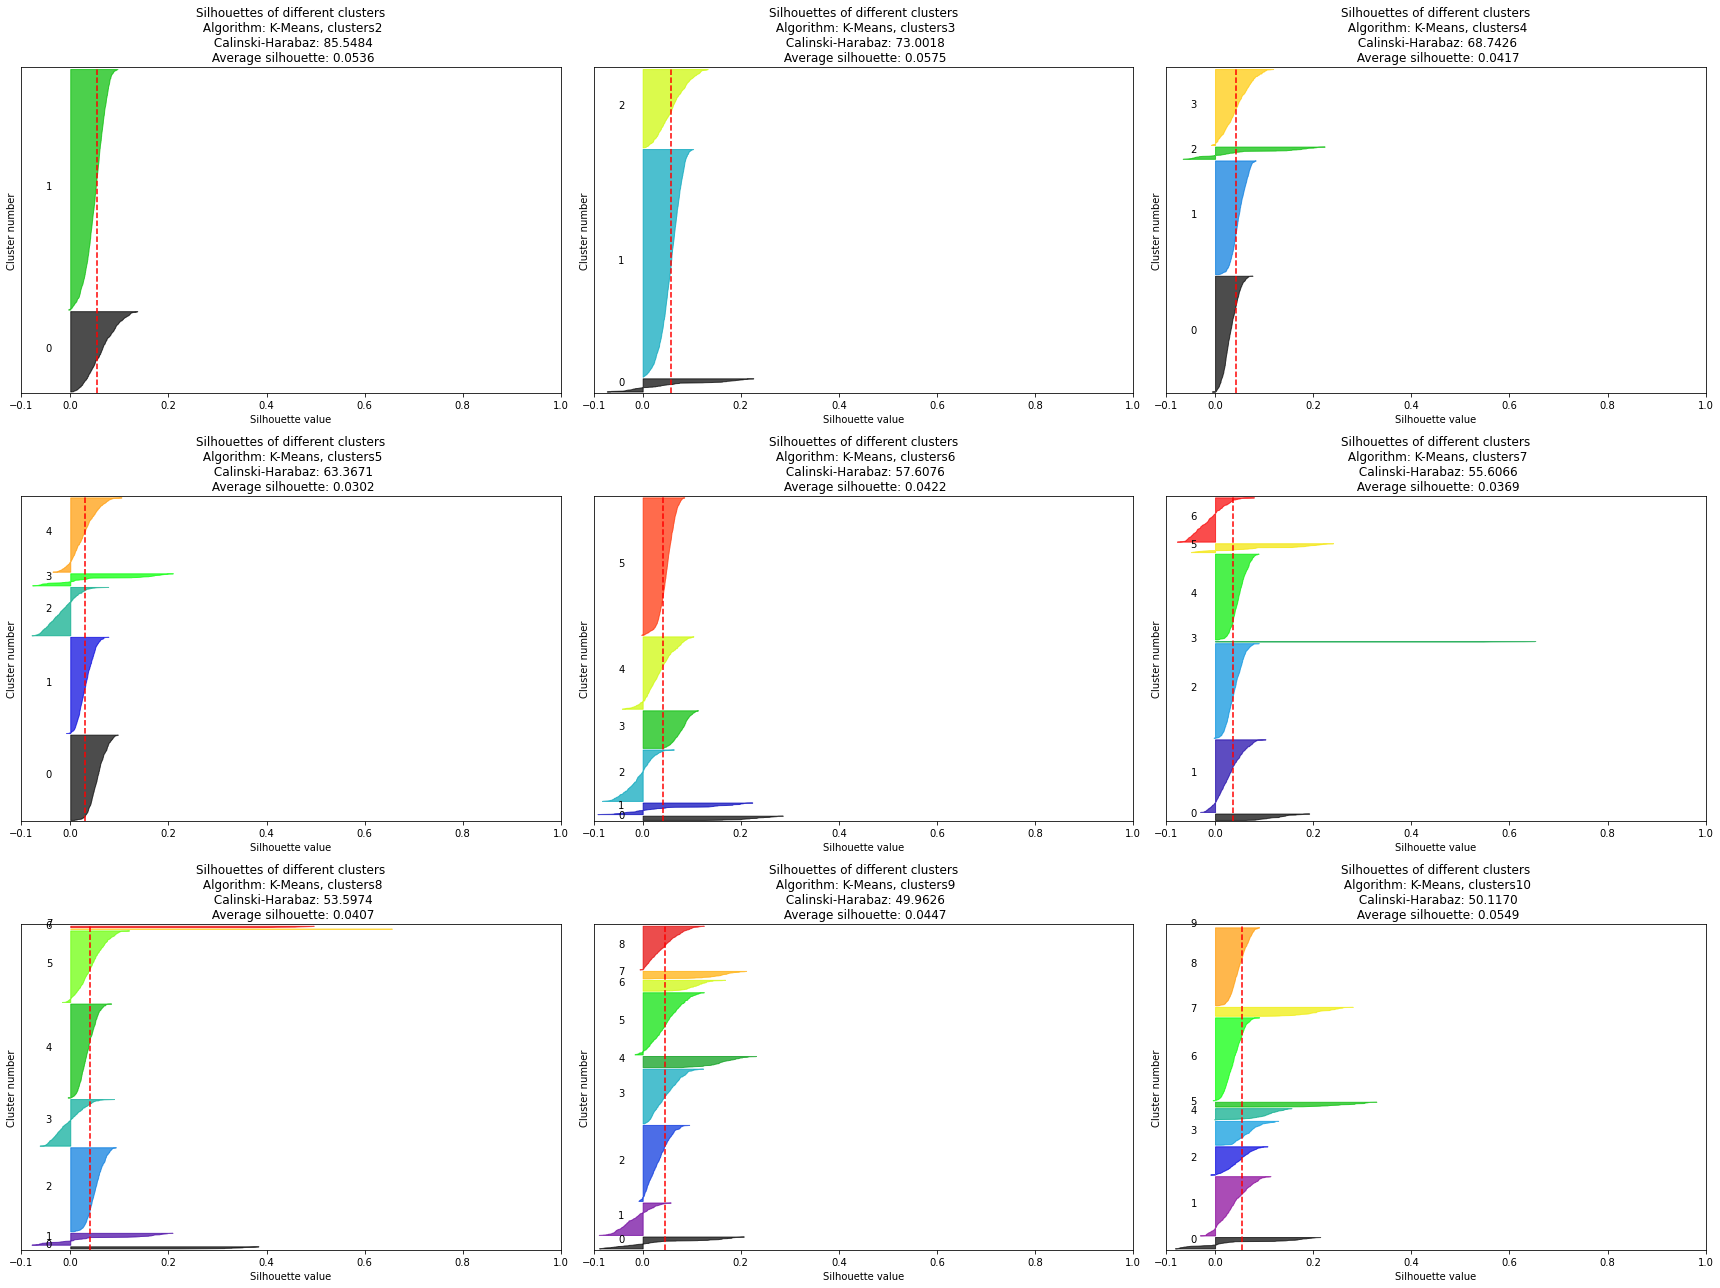

In [ ]:
estimate_param(df_ds_c, range(2, 11), 'K-Means, clusters')

The average silhouette and the Calinski-Harabaz measure has decreased. So we assume that 2 is optimal parametr for k. Let's see which objects fall into different clusters.

In [ ]:
kmeansc = KMeans(n_clusters=2, random_state=10, max_iter=1000)
y_predc = kmeans3.fit_predict(df_ds_c)
value_counts(df_c[cat_features], y_predc)

---- INCOME_BASE_TYPE ---
cluster                                   0    1
INCOME_BASE_TYPE                                
2НДФЛ                                    77  437
Поступление зарплаты на счет             43  676
Свободная форма с печатью работодателя   75  110
Форма банка (без печати работодателя)   346  394
---- CREDIT_PURPOSE ---
cluster                                0    1
CREDIT_PURPOSE                               
Другое                                17   63
Лечение                                4   26
Обучение                               7   23
Отпуск                                26   52
Покупка автомобиля                    72  258
Покупка бытовой техники                7   27
Покупка земли                         13   16
Покупка мебели                        15   34
Покупка недвижимости/ строительство   65  183
Ремонт                               315  935
---- SEX ---
cluster    0    1
SEX              
женский  257  806
мужской  284  811
---- EDUCATION ---


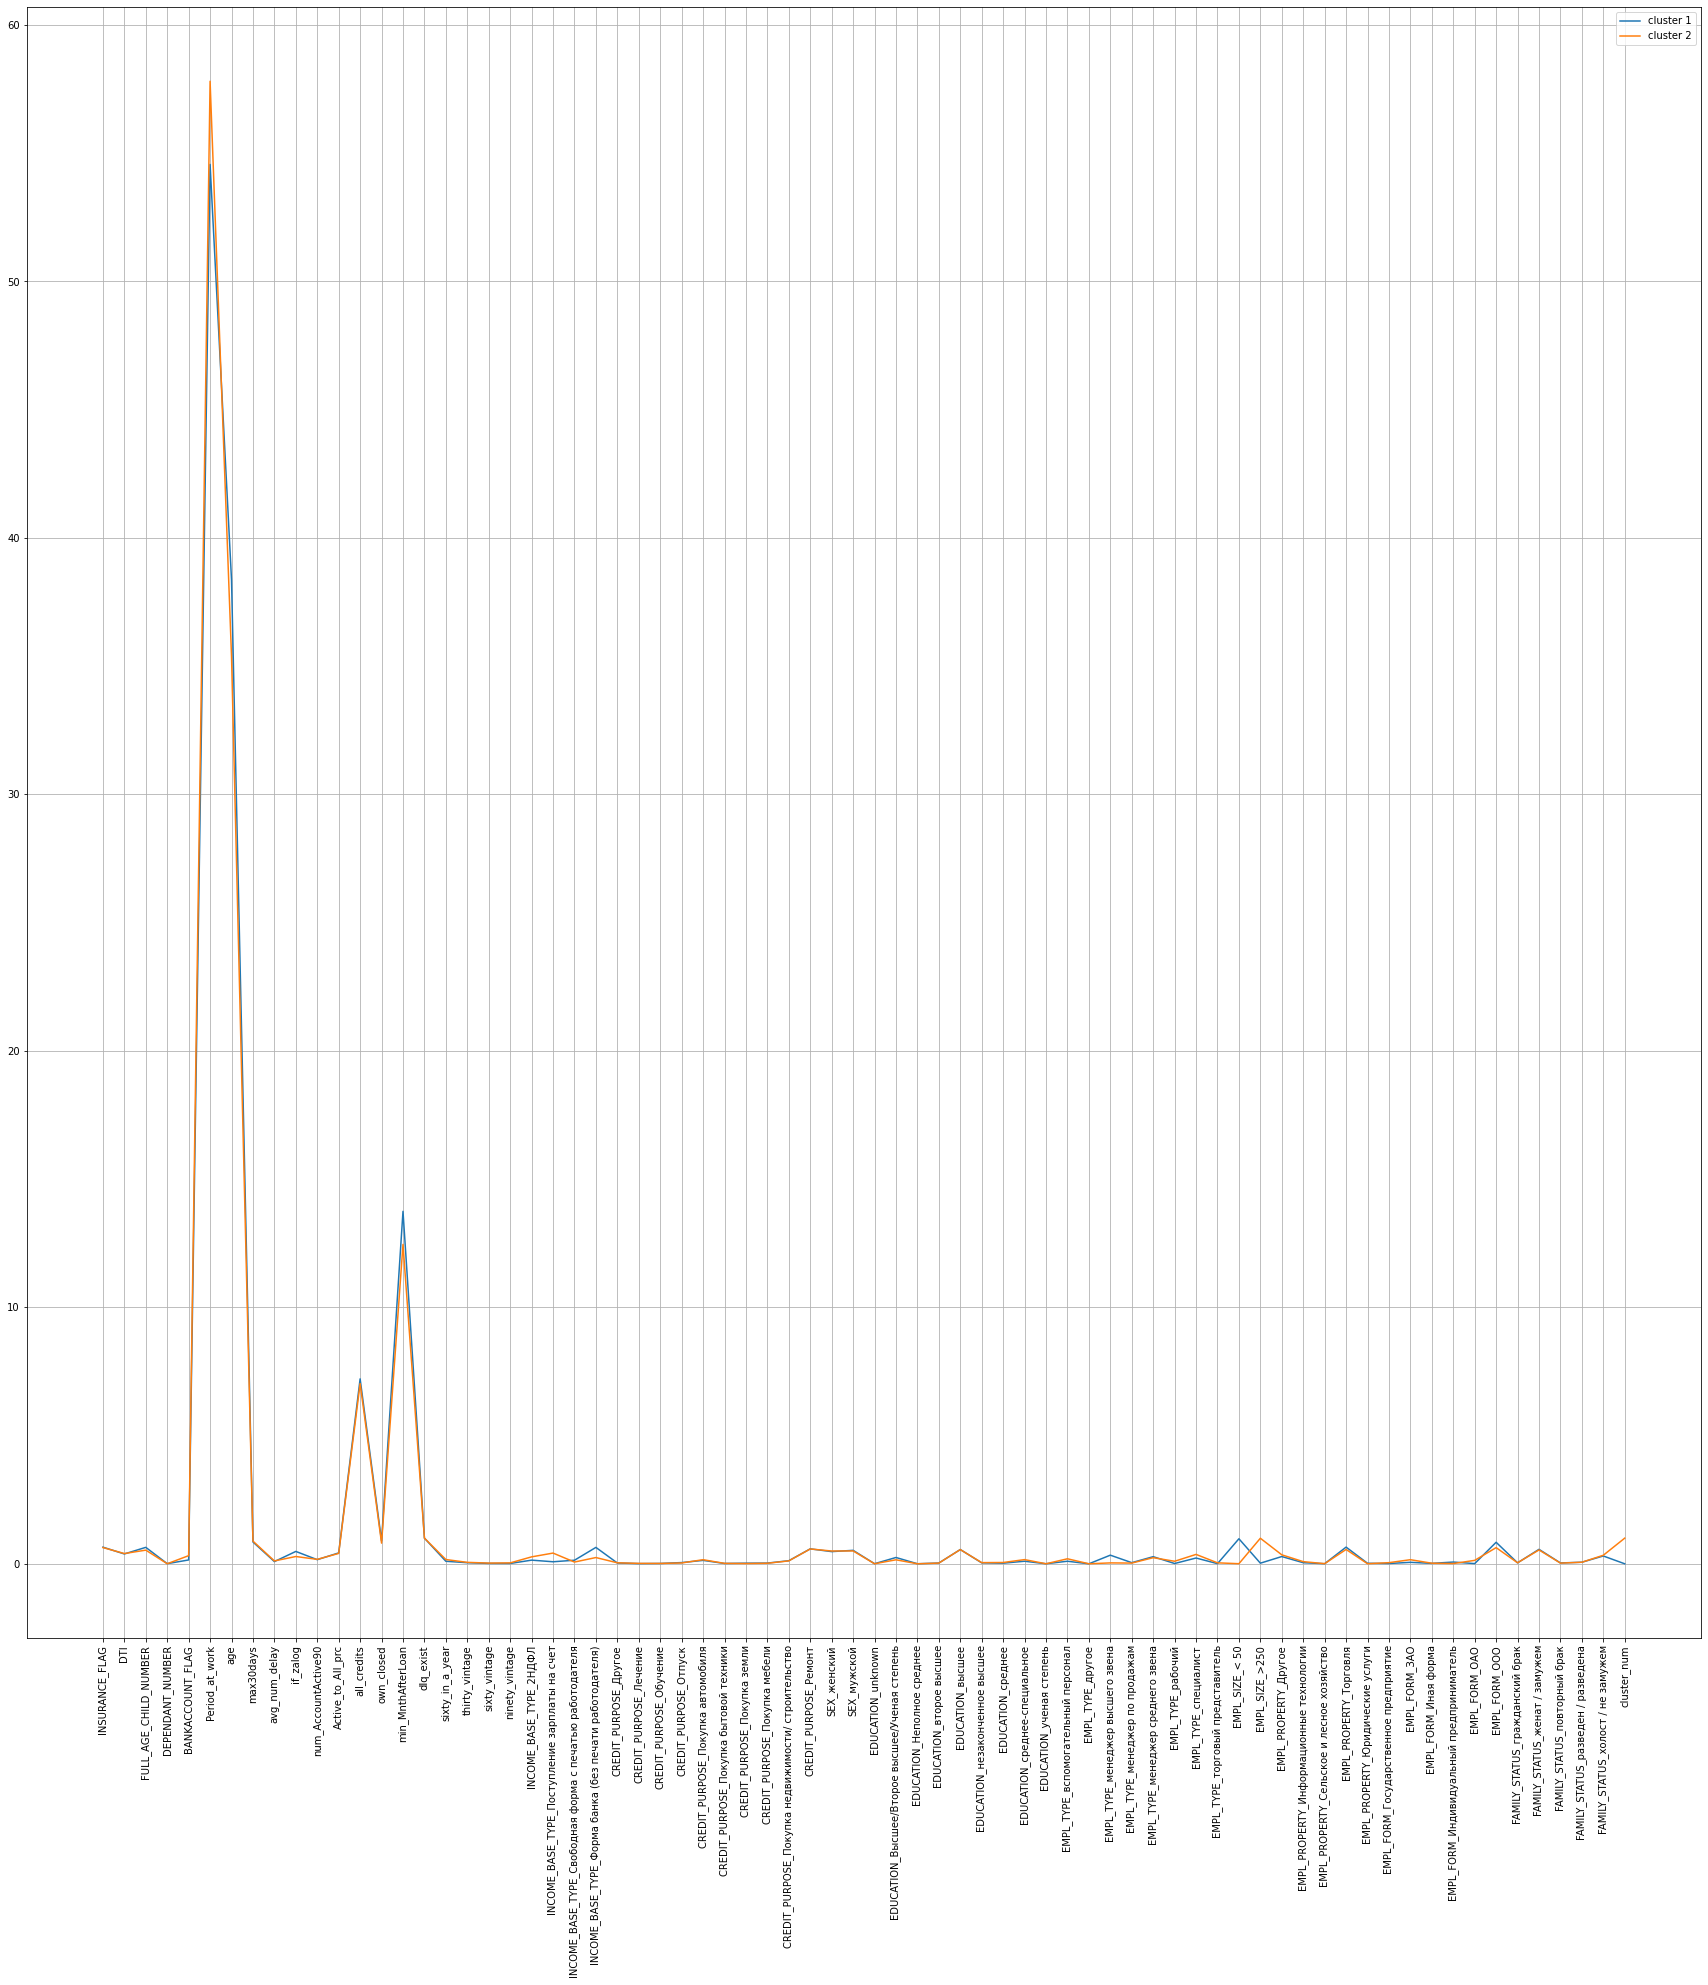

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(df_ds_c)
df_d_c['cluster_num'] = kmeans.fit_predict(df_ds_c)

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d_c.columns, df_d_c[df_d_c.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.savefig('./kmeans_2.png')
plt.show()

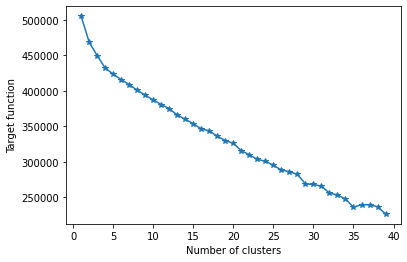

In [ ]:
# Lets determine the optimal number of clusters for K-Means 
J = []
params = np.arange(1, 40)
for k in params:
    kmeans = KMeans(n_clusters=k, random_state=10, max_iter=1000)
    kmeans.fit(df_ds_nc)
    J.append(kmeans.inertia_)
J = np.array(J)

plt.plot(params, J, '-*')
plt.xlabel('Number of clusters')
plt.ylabel('Target function')
plt.show()

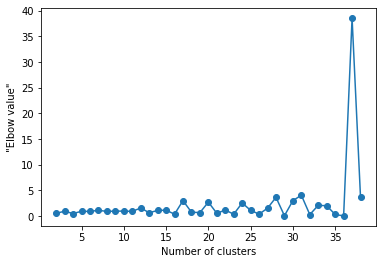

In [ ]:
D = np.abs(J[1:-1]-J[2:])/np.abs(J[:-2] - J[1:-1])
plt.plot(params[1:-1], D, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('\"Elbow value\"')
plt.show()

The elbow value was ruther stabe while number of clusters grow to 10, and then began fluctuate, so let's try to train K-Means with 2 - 10 clusters and look at the results.

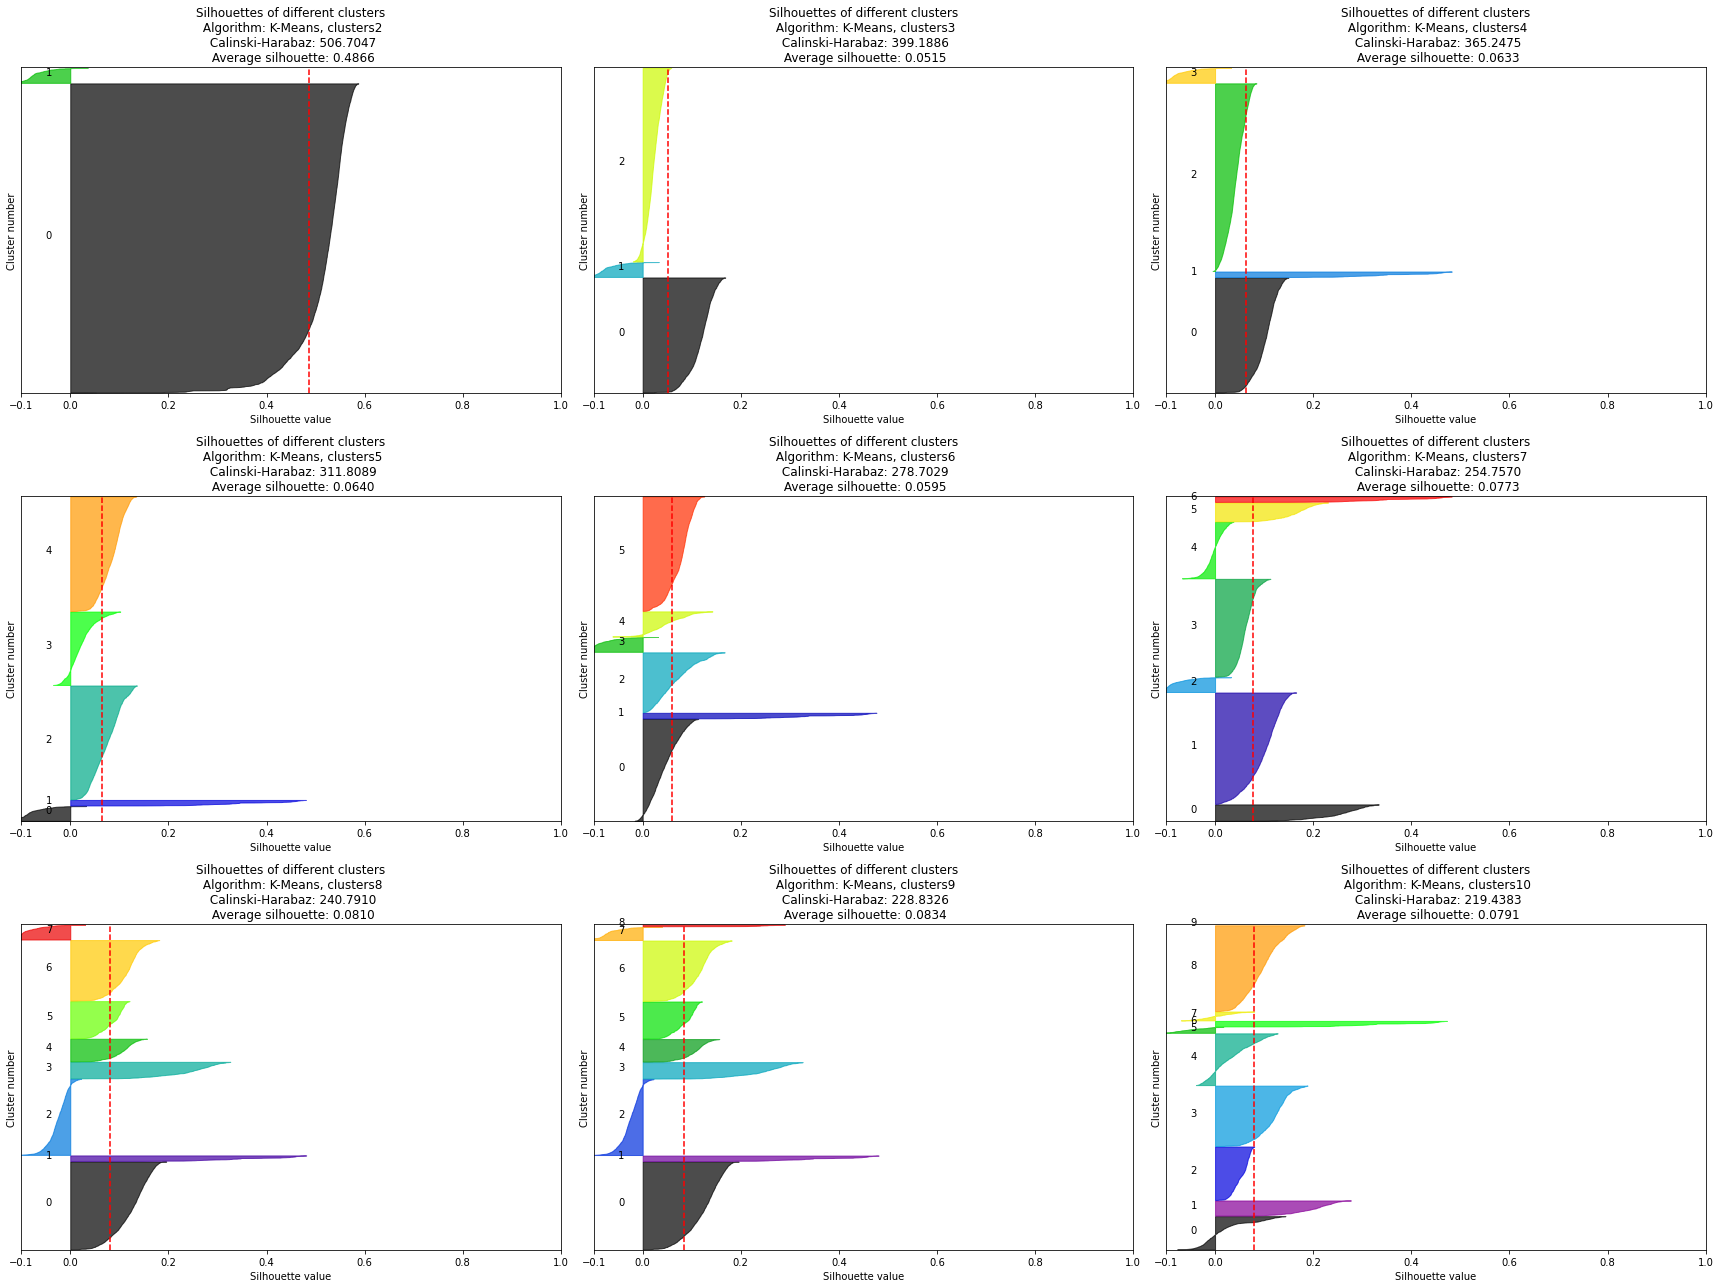

In [ ]:
estimate_param(df_ds_nc, range(2, 11), 'K-Means, clusters')

The average silhouette and the Calinski-Harabaz measure has decreased. So we assume that 2 is optimal parametr for k. Let's see which objects fall into different clusters.

In [ ]:
kmeansnc = KMeans(n_clusters=2, random_state=10, max_iter=1000)
y_prednc = kmeans3.fit_predict(df_ds_nc)
value_counts(df_nc[cat_features], y_prednc)

---- INCOME_BASE_TYPE ---
cluster                                      0      1
INCOME_BASE_TYPE                                     
2НДФЛ                                   2258.0   66.0
unknown                                   61.0    NaN
Поступление зарплаты на счет            1615.0  171.0
Свободная форма с печатью работодателя   521.0   28.0
Форма банка (без печати работодателя)   1725.0   34.0
---- CREDIT_PURPOSE ---
cluster                                 0    1
CREDIT_PURPOSE                                
Другое                                176   11
Лечение                                63    2
Обучение                               66    6
Отпуск                                228   19
Покупка автомобиля                   1090   66
Покупка бытовой техники                86    7
Покупка земли                          94    1
Покупка мебели                        105    5
Покупка недвижимости/ строительство   885   41
Ремонт                               3387  141
---- SEX

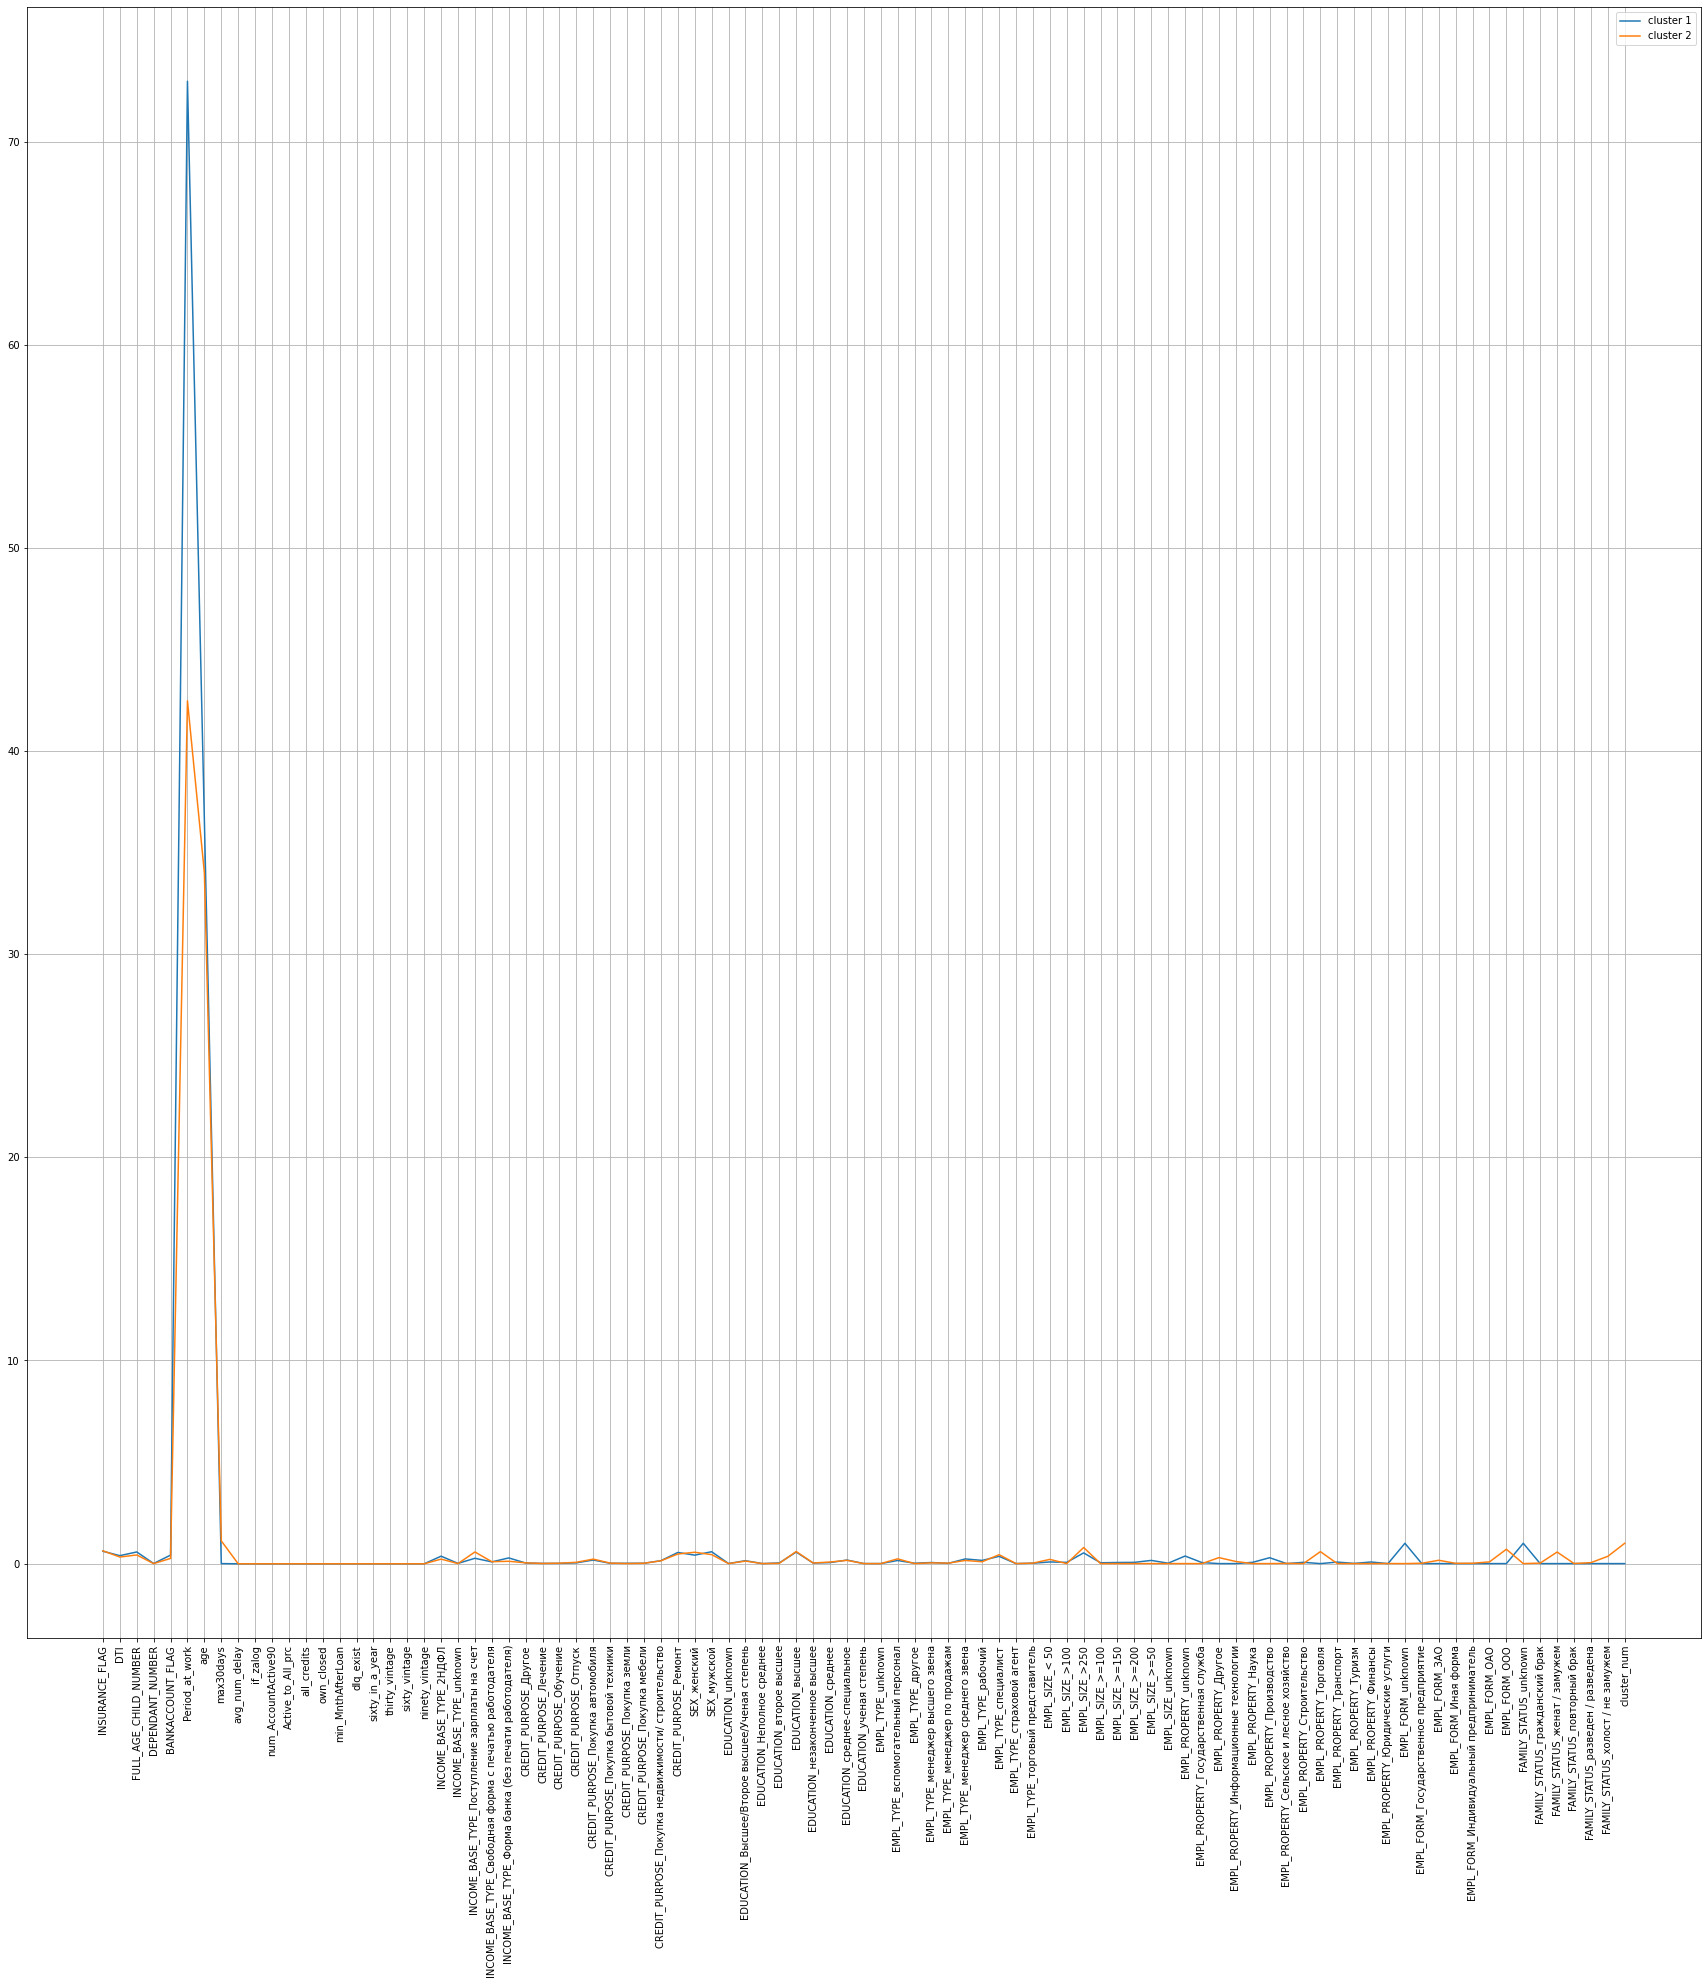

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(df_ds_nc)
df_d_nc['cluster_num'] = kmeans.fit_predict(df_ds_nc)

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d_nc.columns, df_d_nc[df_d_nc.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.savefig('./kmeans_2.png')
plt.show()

## **Hierarchical (agglomerative) clustering**

# Ward


In [ ]:
def estimate_cluster(X, y_pred, name_of_alg=None):
    if not (name_of_alg is None):
        print(("Algorithm: " + name_of_alg))
    
    # Calinski-Harabaz - ratio between the within-cluster dispersion and the between-cluster dispersion
    # Greater is better: BCD/WCD
    print("Calinski-Harabaz: %.4f" % calinski_harabasz_score(X, y_pred))

    silhouette_avg = silhouette_score(X, y_pred)
    print("Average silhouette: %.4f" % silhouette_avg)

    n_clusters = len(np.unique(y_pred))

    # Show how silhouettes are chaged in each cluster
    fig, ax1 = plt.subplots(figsize=(8,6))
    ax1.set_xlim([-0.1, 1])
    # 10 is needed for indentation
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    sample_silhouette_values = silhouette_samples(X, y_pred)

    y_lower = 10
    # iterate over all the clusters
    for i in range(n_clusters):
        # Aggregate and sort silhouettes of objects in the cluster i
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap("nipy_spectral")(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Print the number of the cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute a new lower boundary between cluster silhouettes 
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouettes of different clusters")
    ax1.set_xlabel("Silhouette value")
    ax1.set_ylabel("Cluster number")

    # Vertical line shows average value
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


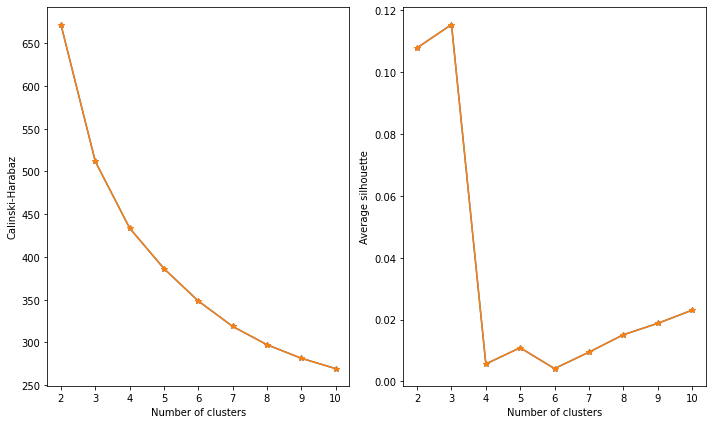

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.arange(2, 11)
for k in params:
    ward_arc = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean') 
    # Further we will omit affinity='euclidean', as it is the default value
    ward_arc.fit(df_ds)
    Jc.append(calinski_harabasz_score(df_ds, ward_arc.labels_))
    Js.append(silhouette_score(df_ds, ward_arc.labels_))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()


Both measures have high values for dividing in 2 and 3 clusters. Let's see what happens in those cases.

Algorithm: Ward, 2 clusters
Calinski-Harabaz: 671.6832
Average silhouette: 0.1079


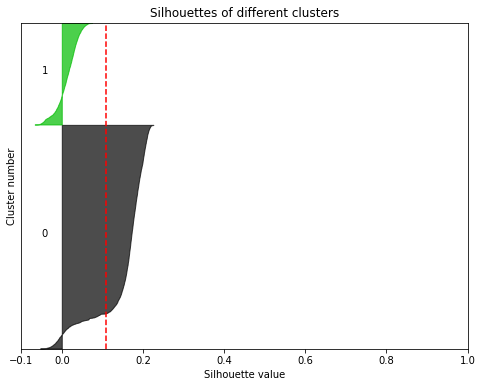

In [ ]:
ward_agc = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_ward2 = ward_agc.fit_predict(df_ds)
estimate_cluster(df_ds, y_ward2, 'Ward, 2 clusters')


Algorithm: Ward, 3 clusters
Calinski-Harabaz: 511.6950
Average silhouette: 0.1154


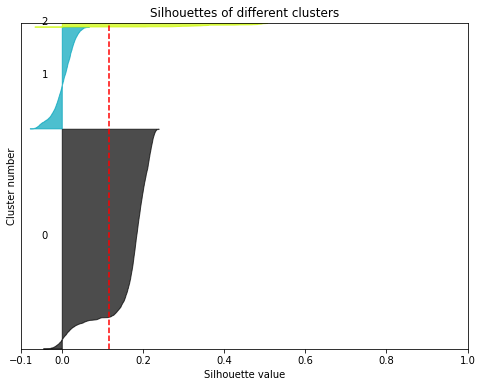

In [ ]:
ward_agc = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_ward3 = ward_agc.fit_predict(df_ds)
estimate_cluster(df_ds, y_ward3, 'Ward, 3 clusters')

In comparison with to K-Means, we worsened for both measure.

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

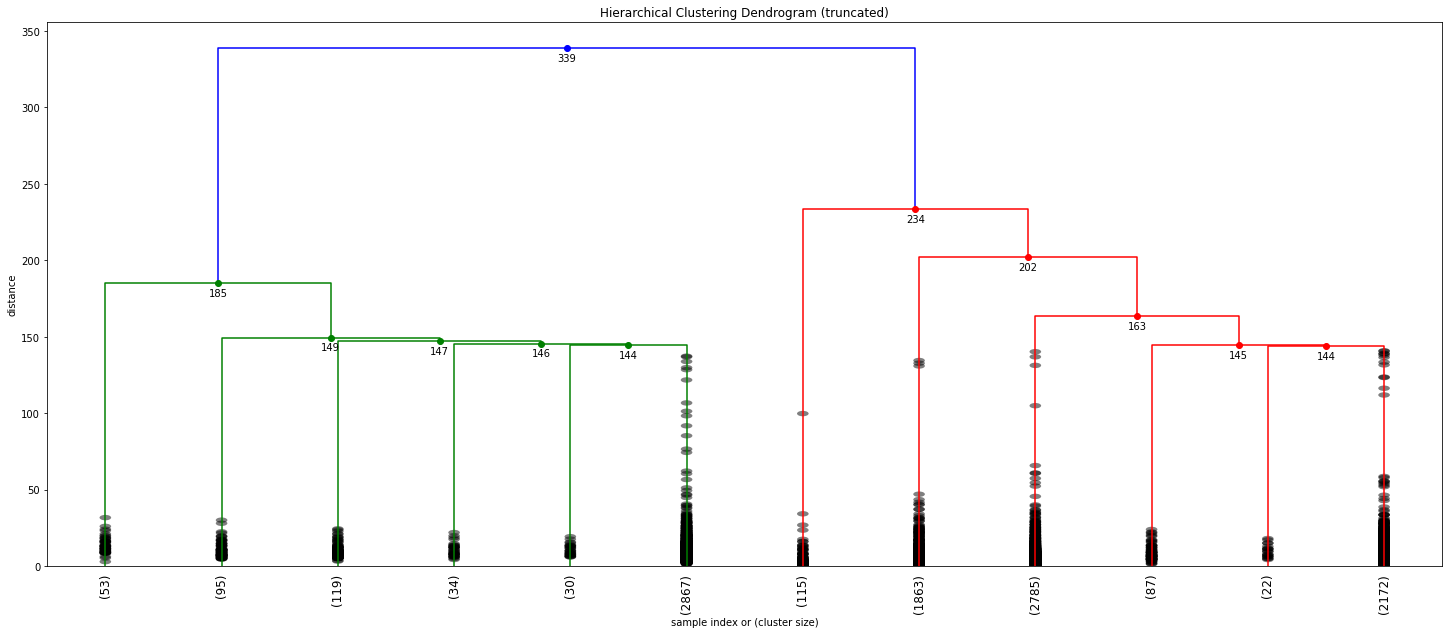

In [ ]:
Z = linkage(df_ds, method='ward', metric='euclidean')

c, coph_dists = cophenet(Z, pdist(df_ds))
c

plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # lower threshold for the value of an annotated node
)
plt.show()

In [ ]:
value_counts(data[cat_features], y_ward3)

---- INCOME_BASE_TYPE ---
cluster                                      0       1     2
INCOME_BASE_TYPE                                            
2НДФЛ                                   2360.0   885.0  53.0
unknown                                    NaN     NaN  61.0
Поступление зарплаты на счет            1992.0  1121.0   1.0
Свободная форма с печатью работодателя   583.0   316.0   NaN
Форма банка (без печати работодателя)   1994.0   876.0   NaN
---- CREDIT_PURPOSE ---
cluster                                   0       1     2
CREDIT_PURPOSE                                           
Другое                                276.0    57.0   5.0
Лечение                               107.0     5.0   NaN
Обучение                              115.0     6.0   1.0
Отпуск                                319.0    61.0   5.0
Покупка автомобиля                   1150.0   591.0  26.0
Покупка бытовой техники               145.0     5.0   NaN
Покупка земли                         130.0     9.0   NaN
П

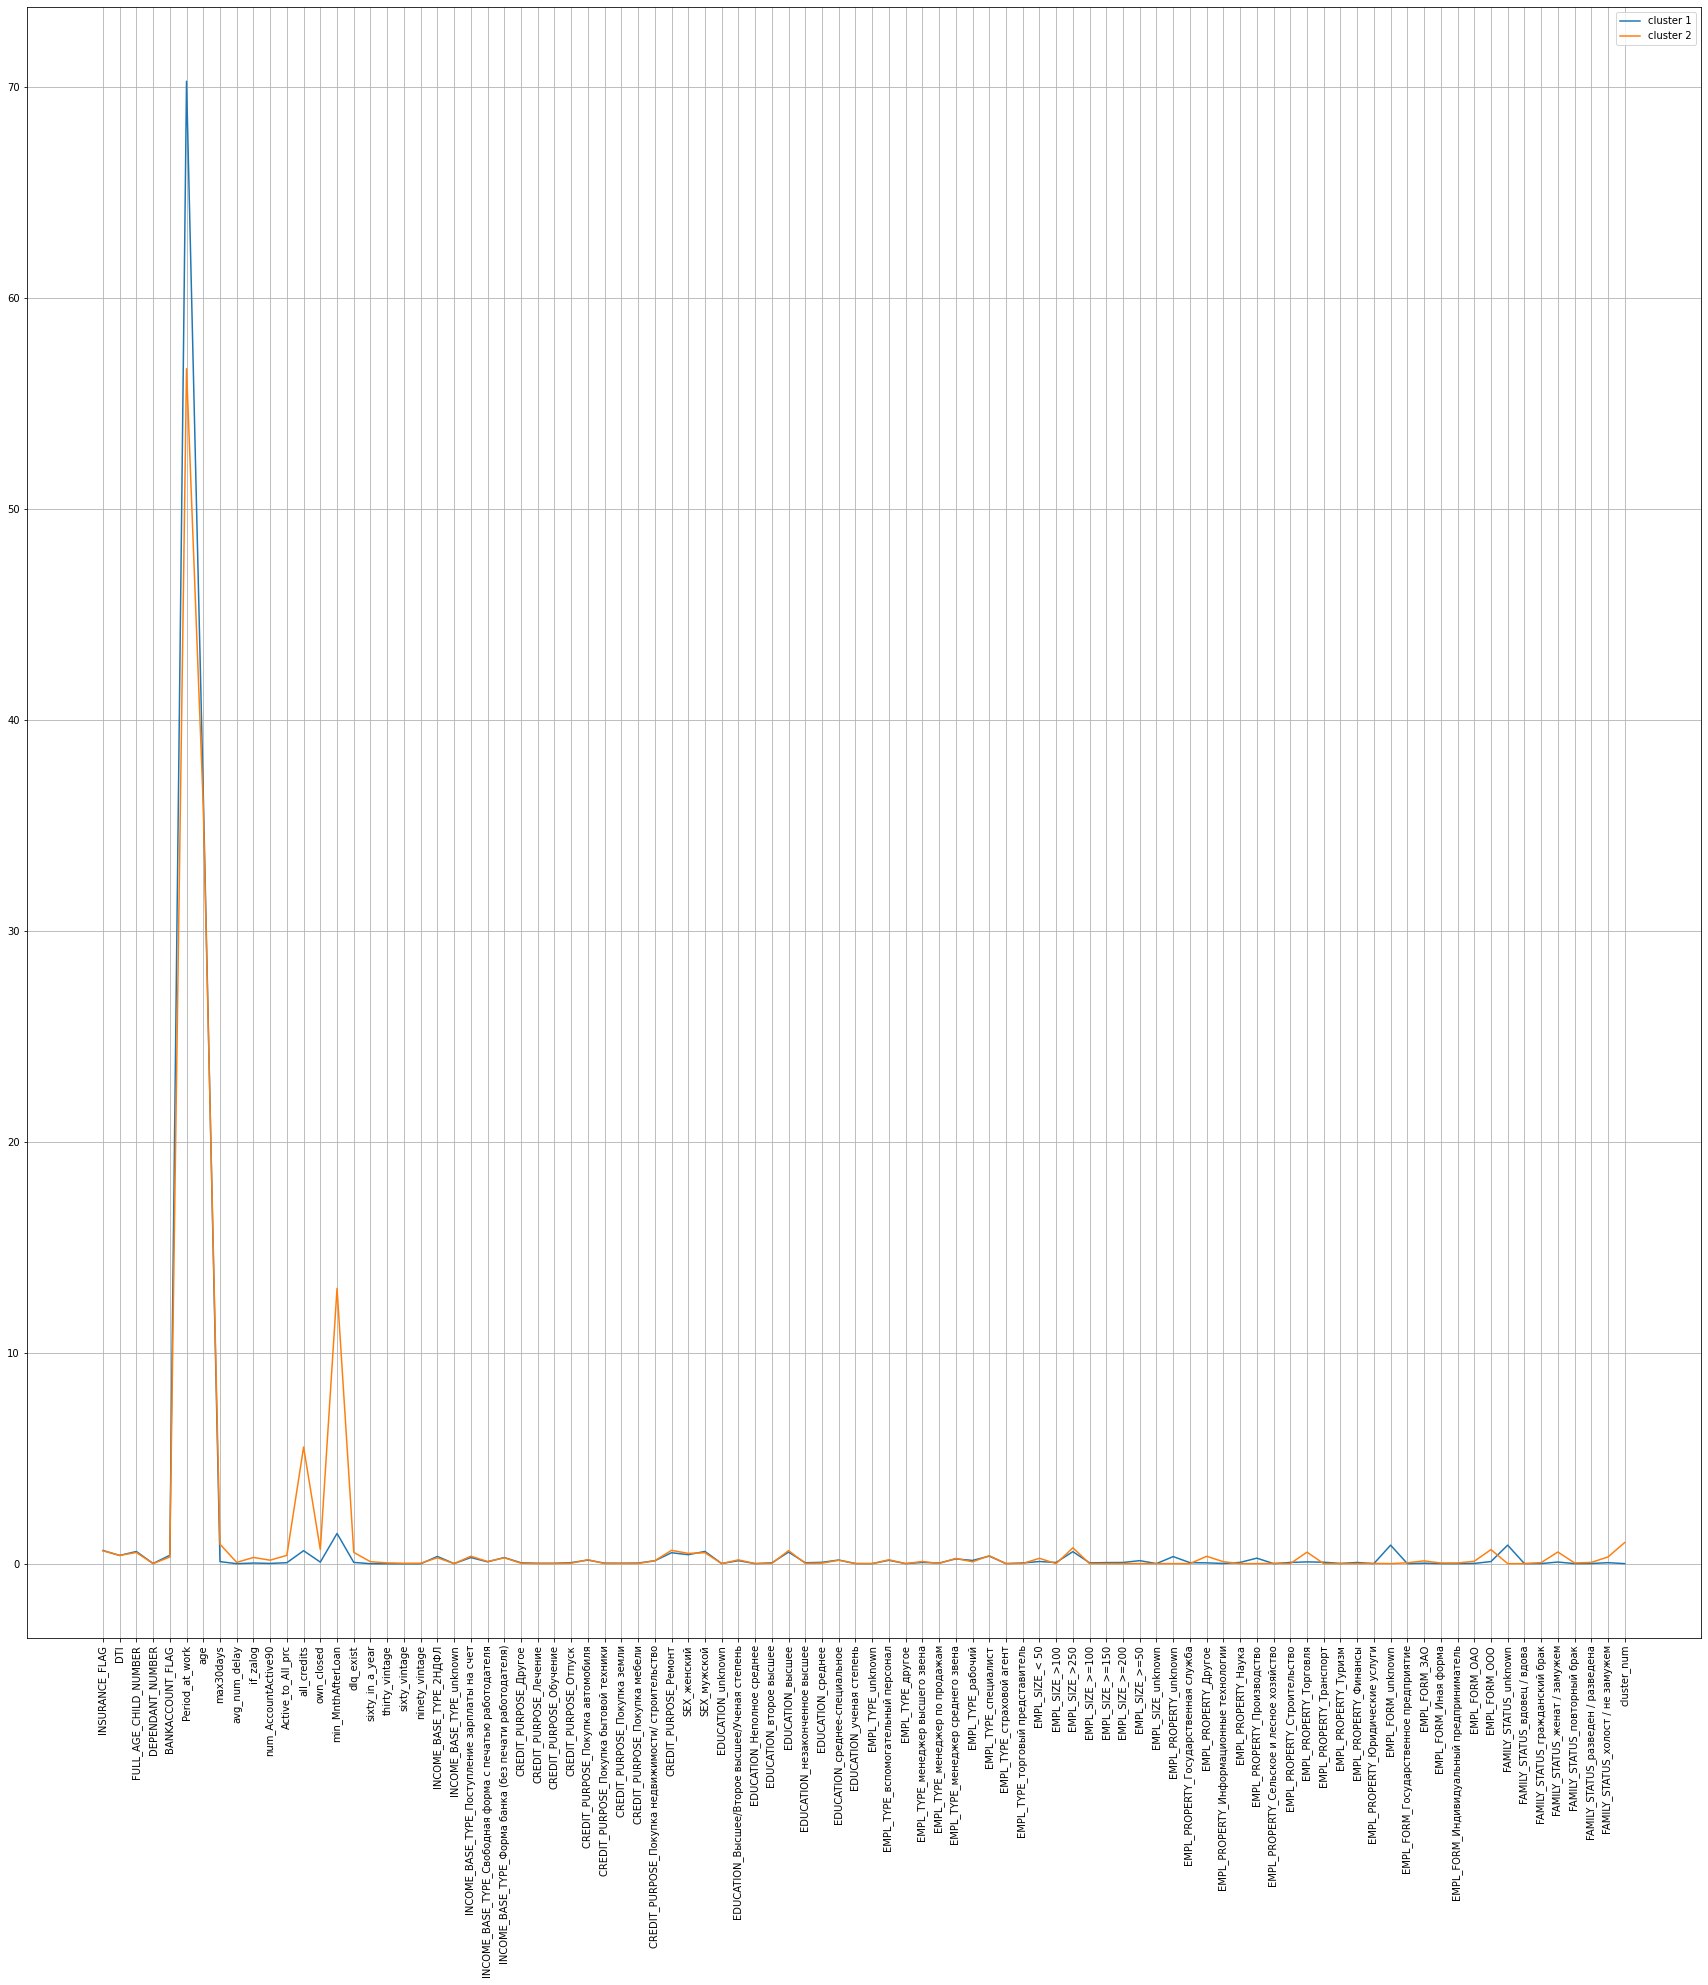

In [ ]:
df_d['cluster_num'] = y_ward3

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

# Average

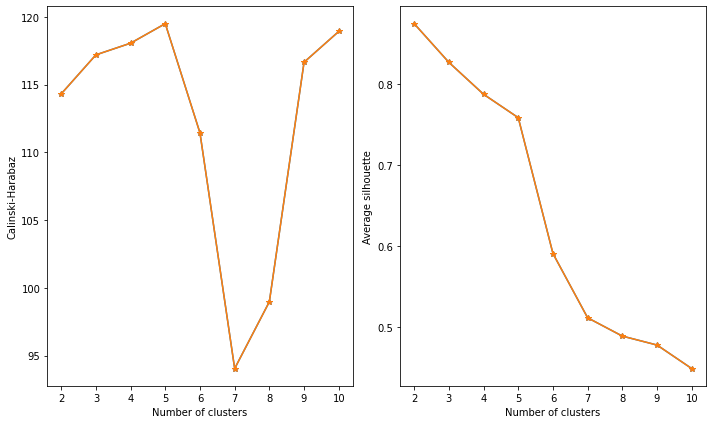

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.arange(2, 11)
for k in params:
    average_arc = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='euclidean') 
    # Further we will omit affinity='euclidean', as it is the default value
    average_arc.fit(df_ds)
    Jc.append(calinski_harabasz_score(df_ds, average_arc.labels_))
    Js.append(silhouette_score(df_ds, average_arc.labels_))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()

Both measures have high values for dividing in 2, 3, 4, 5 clusters. Let's see what happens in those cases.

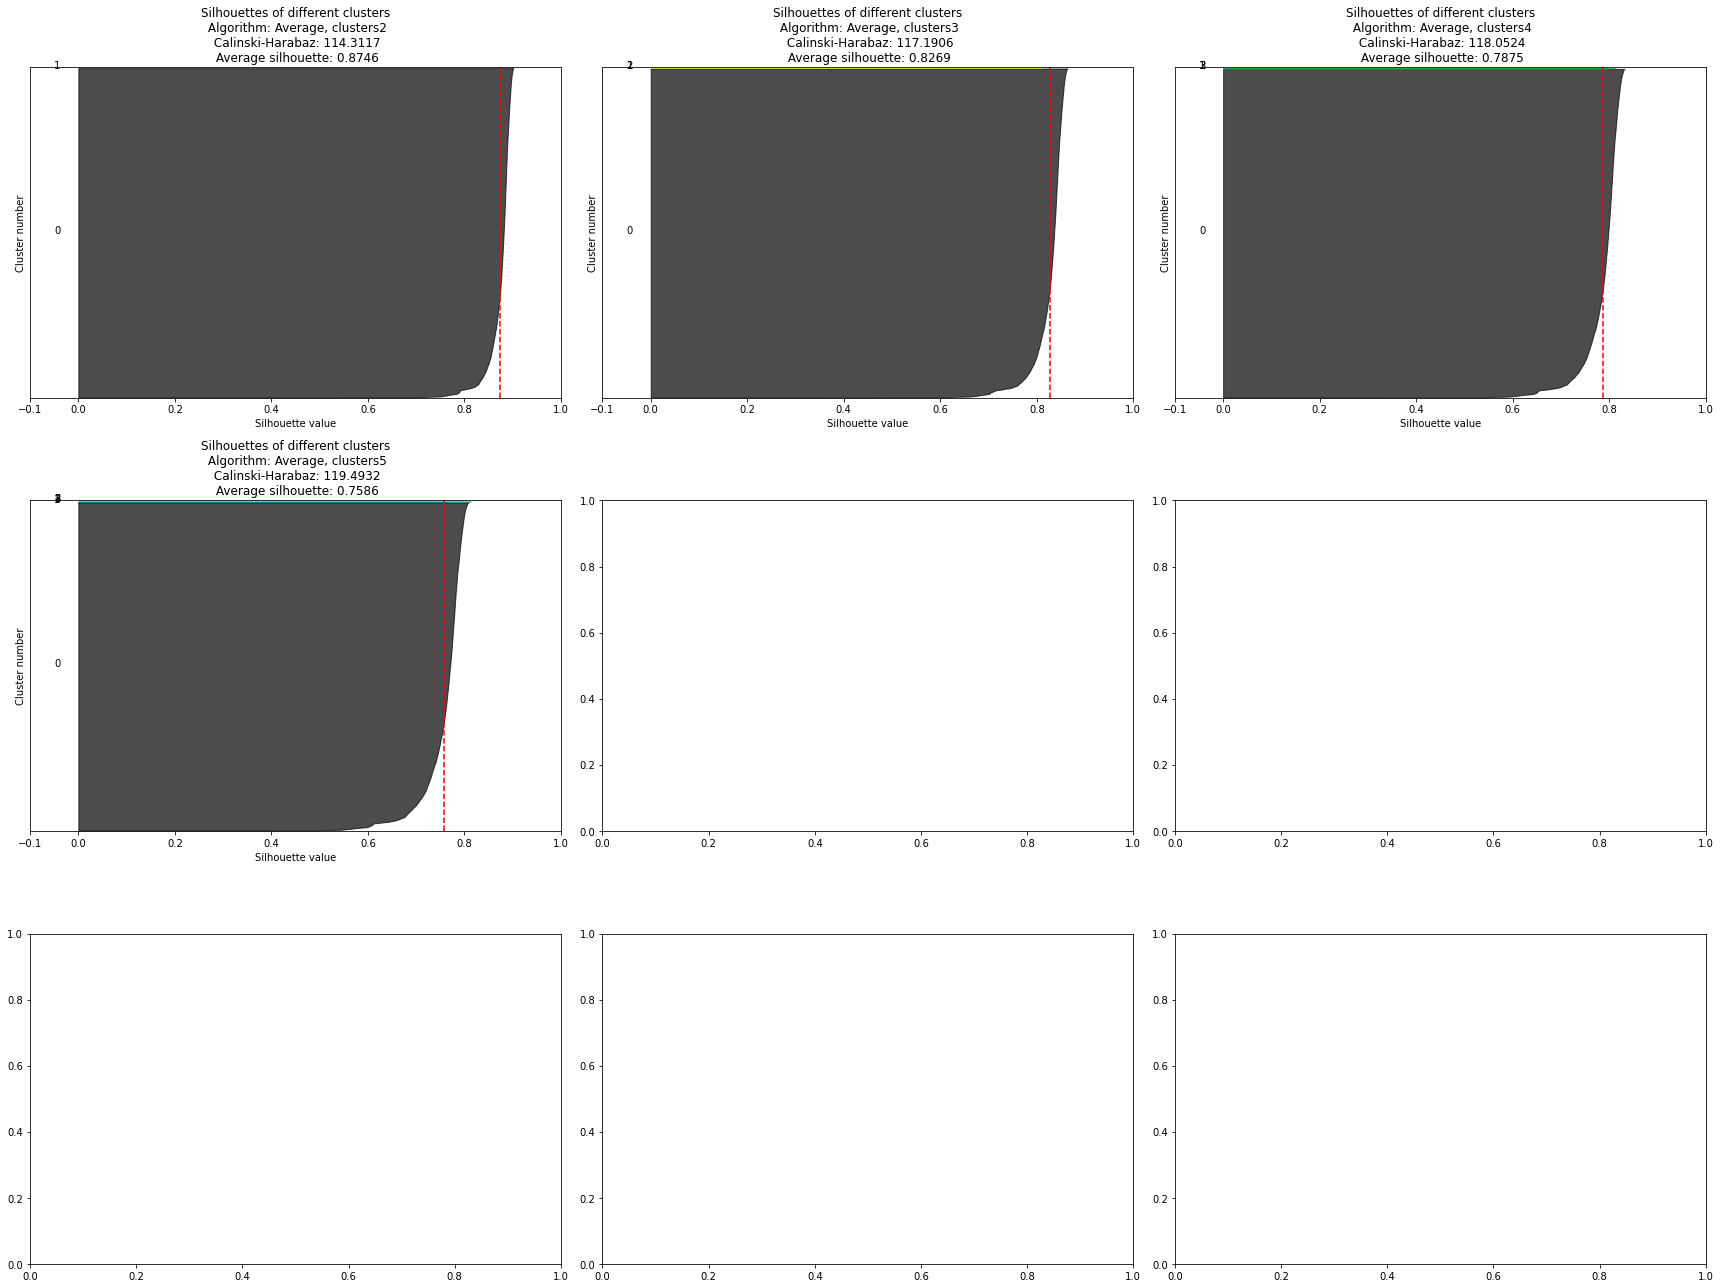

In [ ]:
estimate_param(df_ds, range(2, 6), 'Average, clusters')

In comparison with to K-Means, we improved the results for the average silhouette, but worsened for another measure.

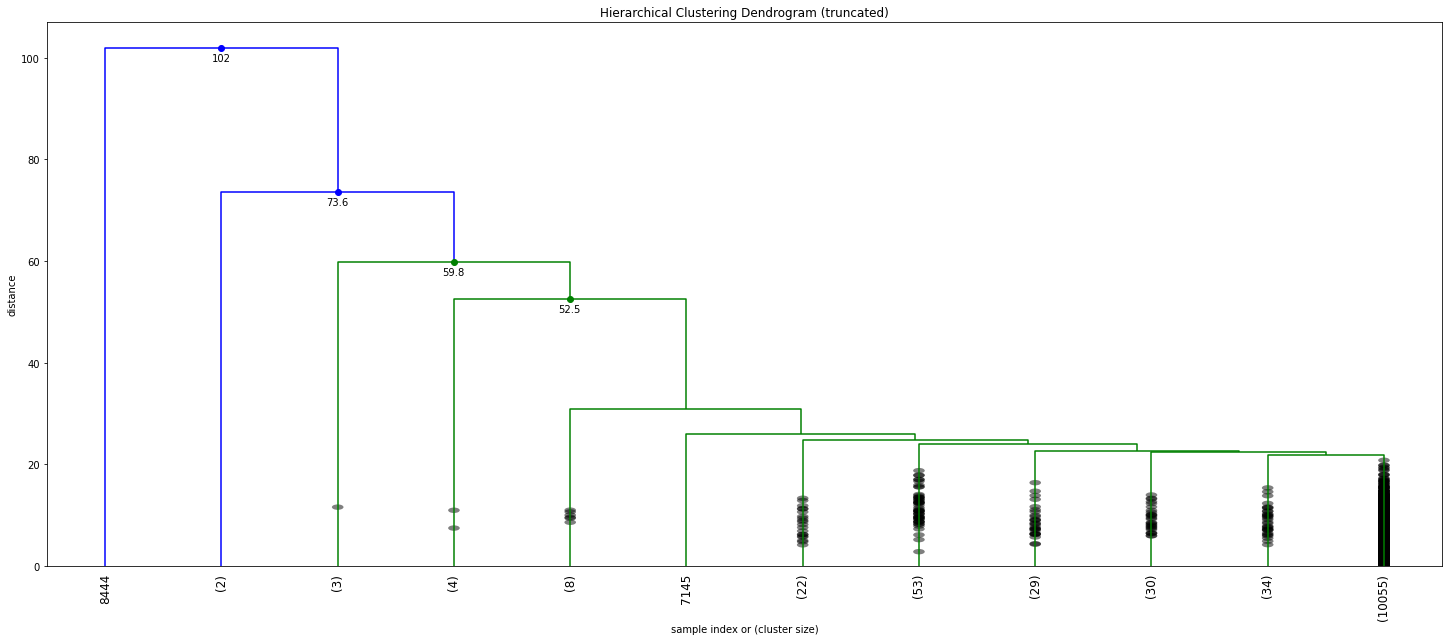

In [ ]:
Z = linkage(df_ds, method='average', metric='euclidean')

c, coph_dists = cophenet(Z, pdist(df_ds))
c

plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,  # lower threshold for the value of an annotated node
)
plt.show()

In [ ]:
average_arc = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_average2 = average_arc.fit_predict(df_ds)
value_counts(data[cat_features], y_average2)

---- INCOME_BASE_TYPE ---
cluster                                      0       1
INCOME_BASE_TYPE                                      
2НДФЛ                                   2413.0   885.0
unknown                                   61.0     NaN
Поступление зарплаты на счет            1993.0  1121.0
Свободная форма с печатью работодателя   583.0   316.0
Форма банка (без печати работодателя)   1994.0   876.0
---- CREDIT_PURPOSE ---
cluster                                 0     1
CREDIT_PURPOSE                                 
Другое                                281    57
Лечение                               107     5
Обучение                              116     6
Отпуск                                324    61
Покупка автомобиля                   1176   591
Покупка бытовой техники               145     5
Покупка земли                         130     9
Покупка мебели                        179    14
Покупка недвижимости/ строительство   952   439
Ремонт                               

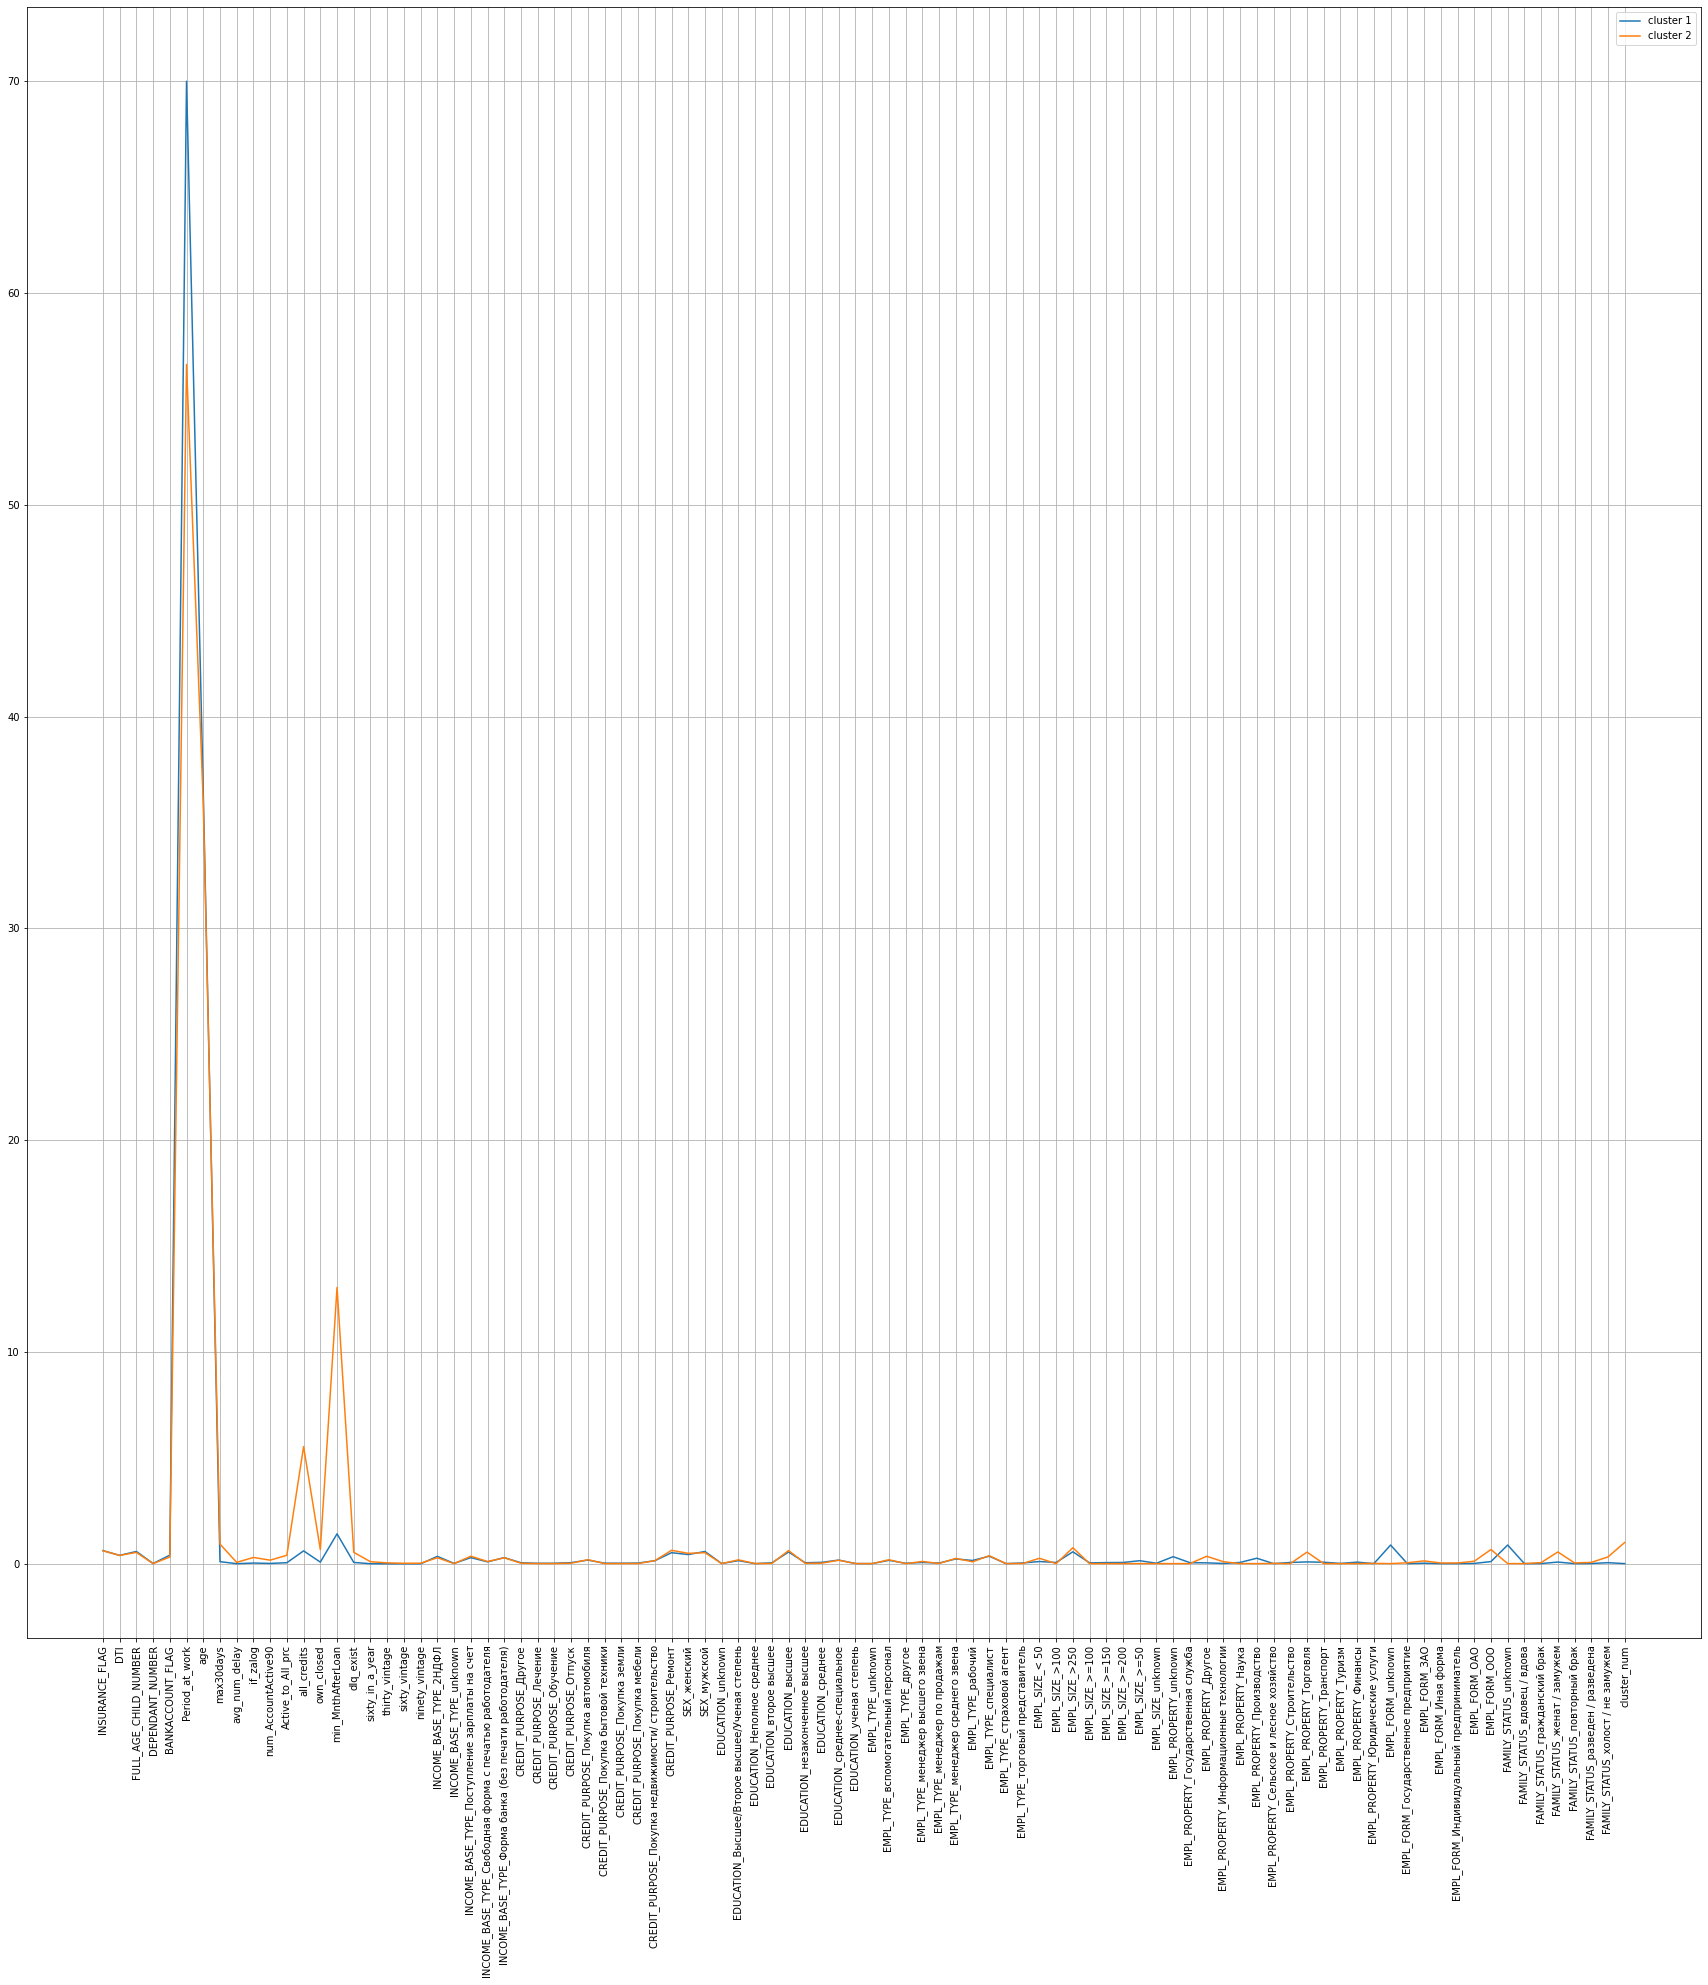

In [ ]:
df_d['cluster_num'] = y_average2

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

# Complete

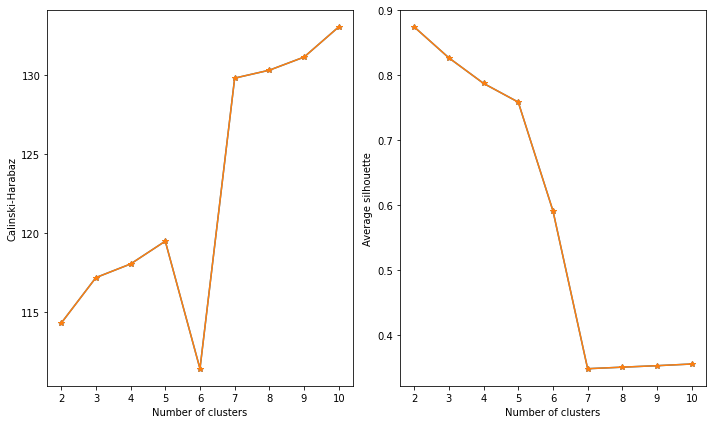

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.arange(2, 11)
for k in params:
    complete_arc = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean') 
    # Further we will omit affinity='euclidean', as it is the default value
    complete_arc.fit(df_ds)
    Jc.append(calinski_harabasz_score(df_ds, complete_arc.labels_))
    Js.append(silhouette_score(df_ds, complete_arc.labels_))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()

In this case, the Calinski-Harabaz measure is almost constantly increase, while Average silhouette is decreased. So, let's see what happens while devoting in 2-10 clusters. 

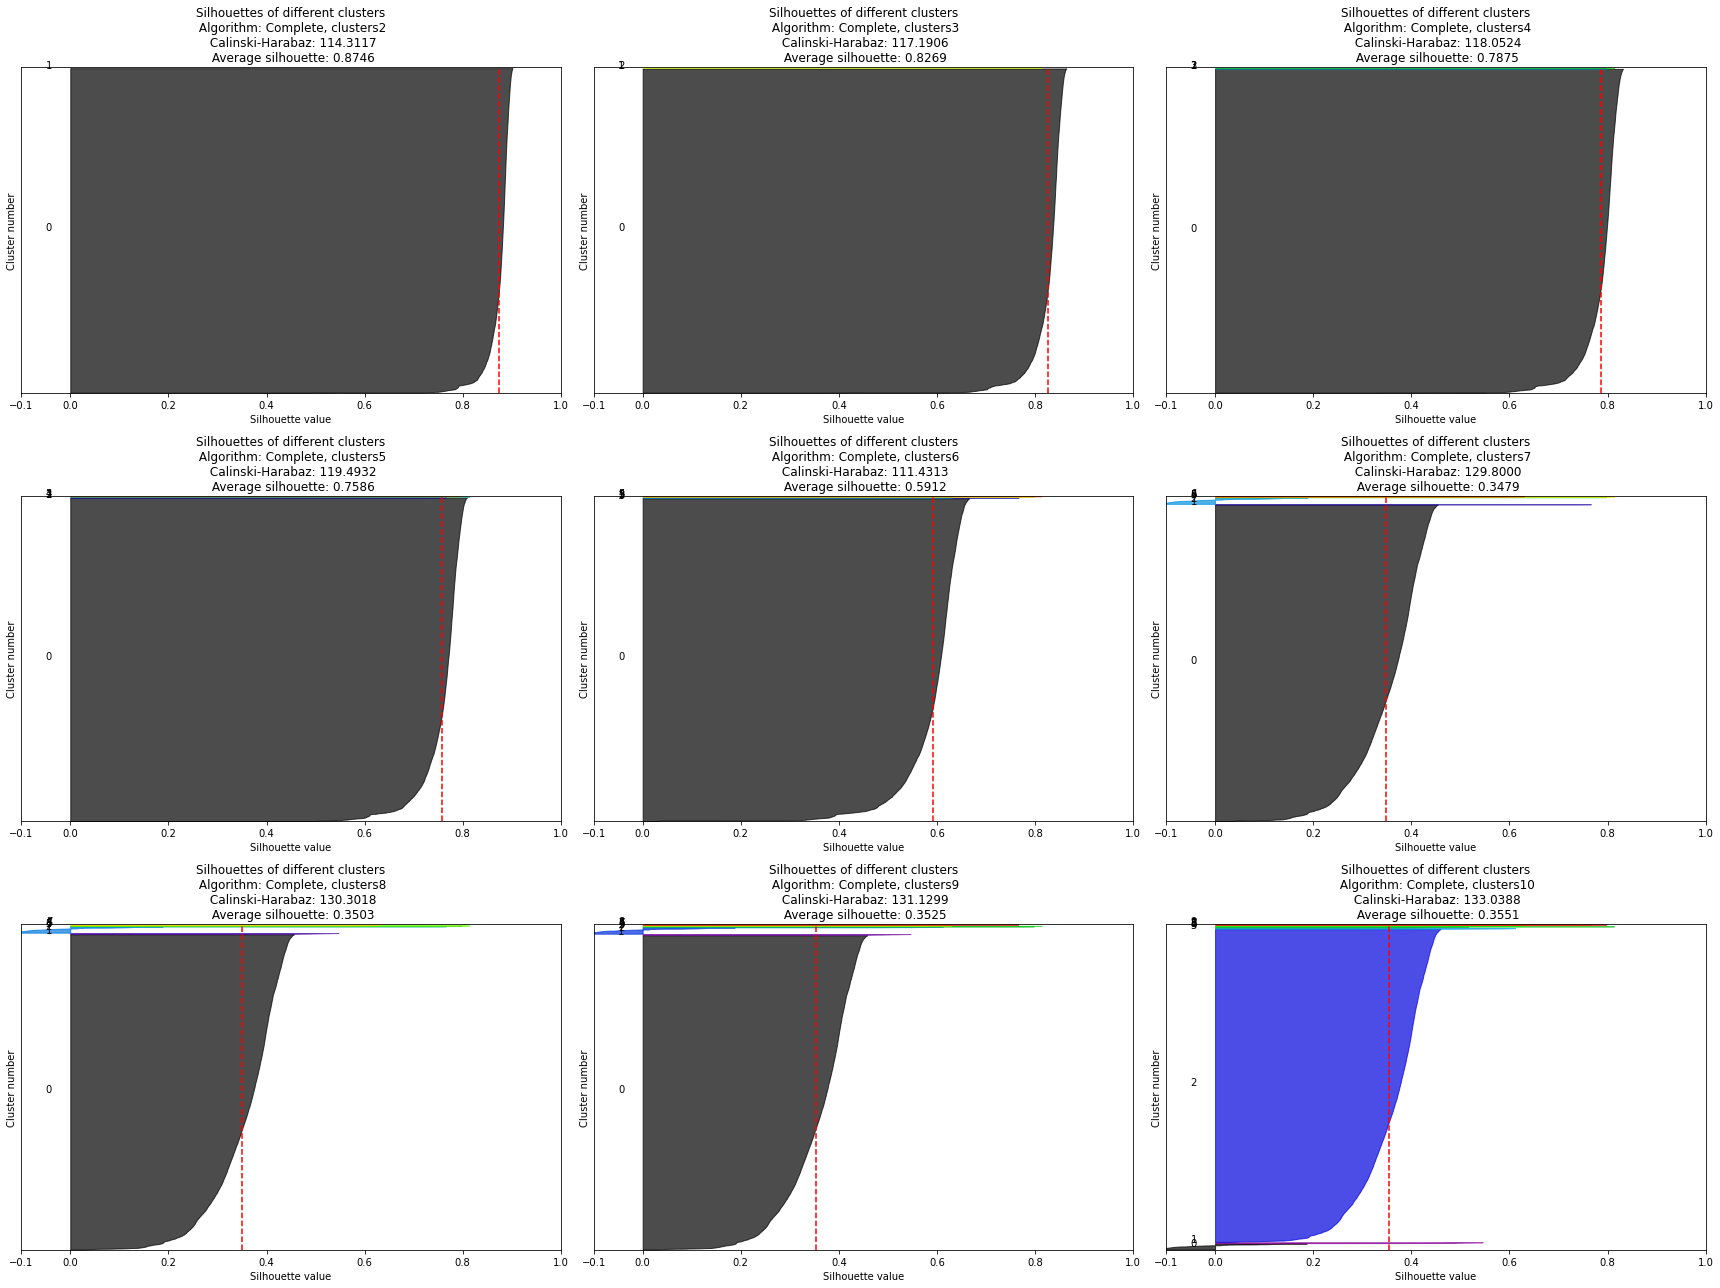

In [ ]:
estimate_param(df_ds, range(2, 11), 'Complete, clusters')

It shows the same results as Average.

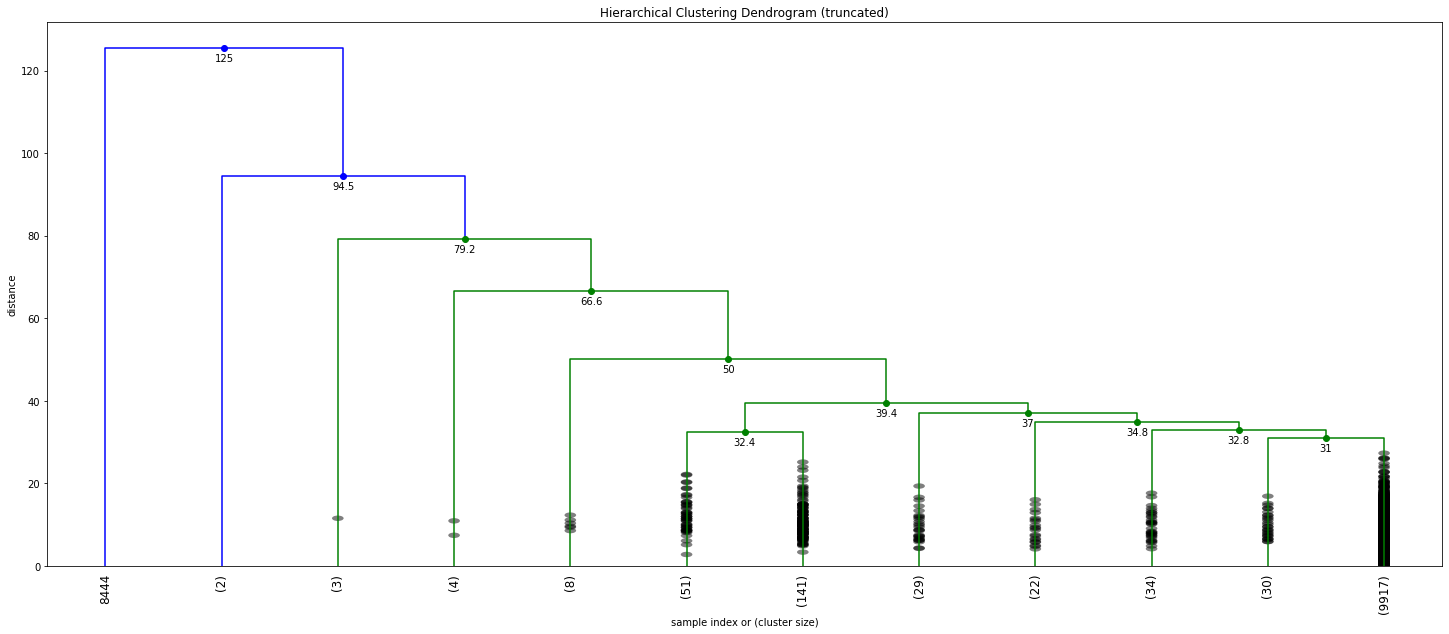

In [ ]:
Z = linkage(df_ds, method='complete', metric='euclidean')

c, coph_dists = cophenet(Z, pdist(df_ds))
c

plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # lower threshold for the value of an annotated node
)
plt.show()

In [ ]:
complete_arc = AgglomerativeClustering(n_clusters=2, linkage='complete')
y_complete2 = complete_arc.fit_predict(df_ds)
value_counts(data[cat_features], y_complete2)

---- INCOME_BASE_TYPE ---
cluster                                      0    1
INCOME_BASE_TYPE                                   
2НДФЛ                                   3297.0  1.0
unknown                                   61.0  NaN
Поступление зарплаты на счет            3114.0  NaN
Свободная форма с печатью работодателя   899.0  NaN
Форма банка (без печати работодателя)   2870.0  NaN
---- CREDIT_PURPOSE ---
cluster                                   0    1
CREDIT_PURPOSE                                  
Другое                                338.0  NaN
Лечение                               112.0  NaN
Обучение                              122.0  NaN
Отпуск                                385.0  NaN
Покупка автомобиля                   1767.0  NaN
Покупка бытовой техники               150.0  NaN
Покупка земли                         139.0  NaN
Покупка мебели                        193.0  NaN
Покупка недвижимости/ строительство  1391.0  NaN
Ремонт                               5644.0  1.

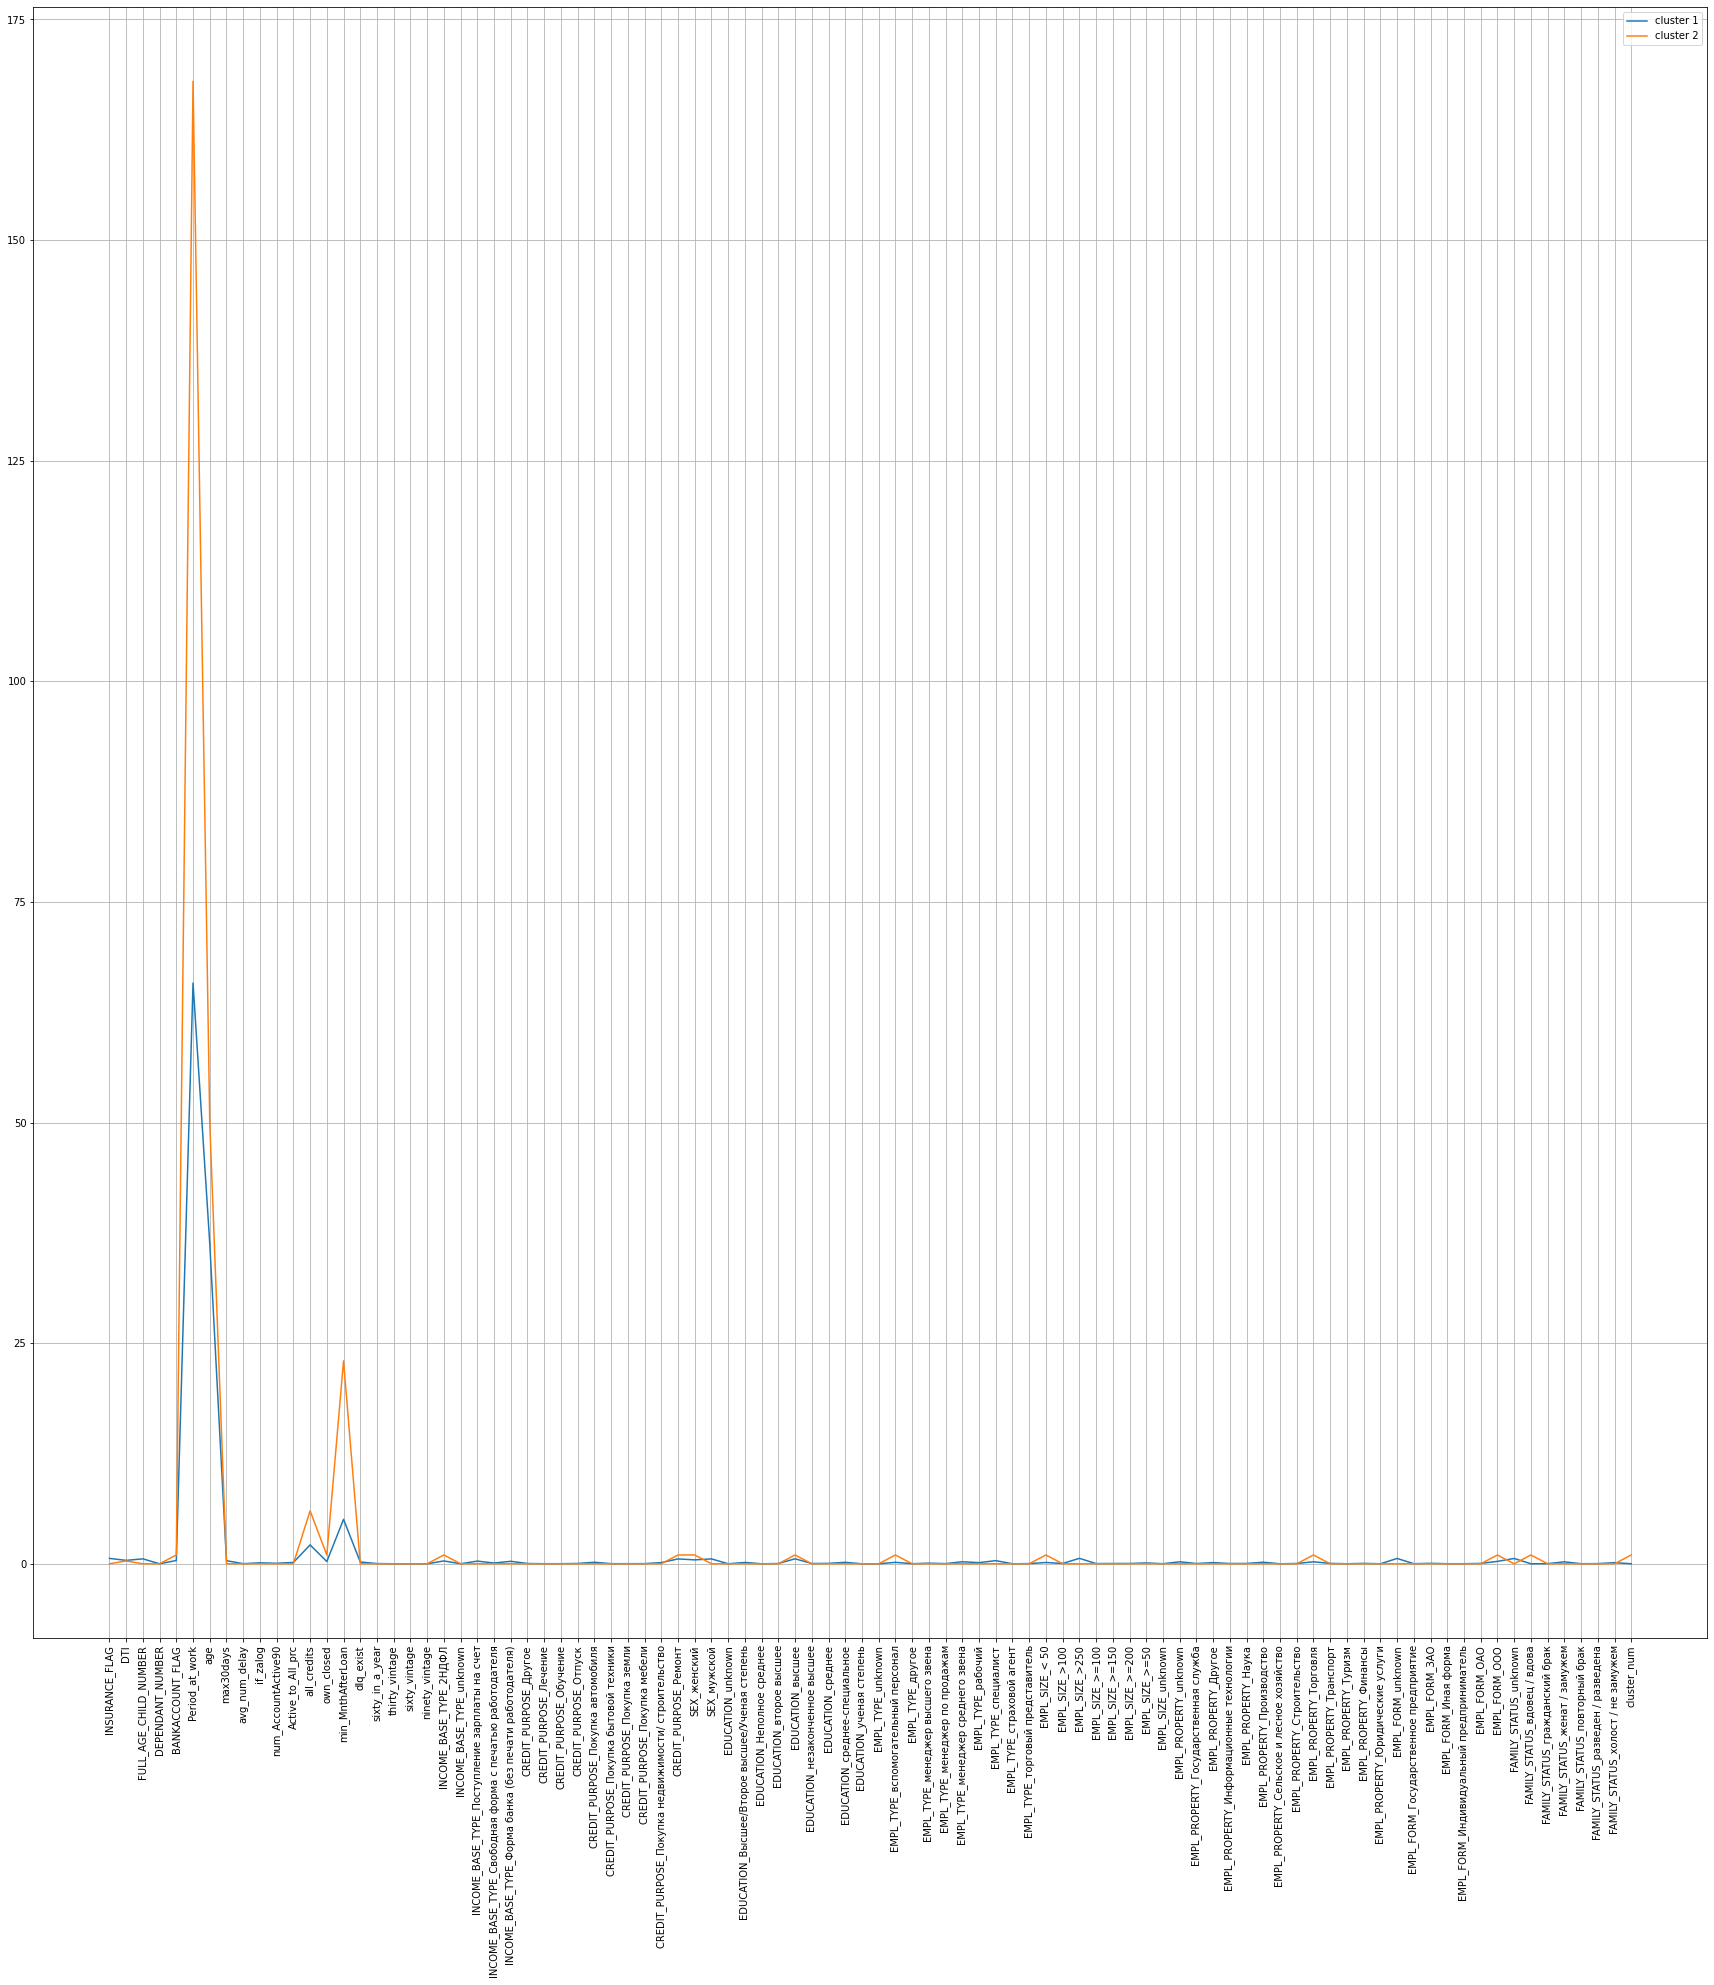

In [ ]:
df_d['cluster_num'] = y_complete2

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()


# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

eps_values = np.arange(0.1, 3, 0.1)
min_sample_values = np.arange(2, 30)
n_cluster_estimates = np.zeros((len(eps_values), len(min_sample_values)))
silhouette = np.zeros(((len(eps_values)), len(min_sample_values)))
calinski = np.zeros(((len(eps_values)), len(min_sample_values)))

for i, eps in enumerate(eps_values):
    for j, min_sample in enumerate(min_sample_values):
        db = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean').fit(df_ds)
        n_cluster_estimates[i, j]  = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        if n_cluster_estimates[i, j] > 1:
            silhouette[i, j] = silhouette_score(df_ds, db.labels_)
            calinski[i, j] = calinski_harabasz_score(df_ds, db.labels_)

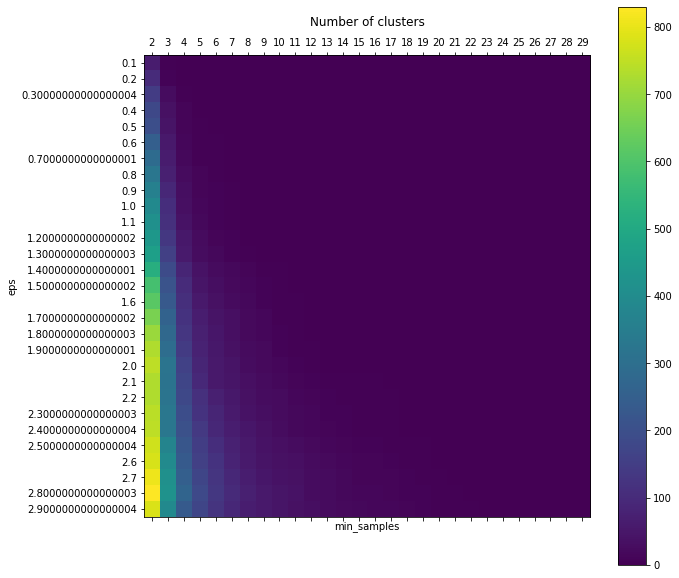

In [ ]:
plt.figure(figsize=(10,10))        
plt.matshow(n_cluster_estimates, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Number of clusters')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

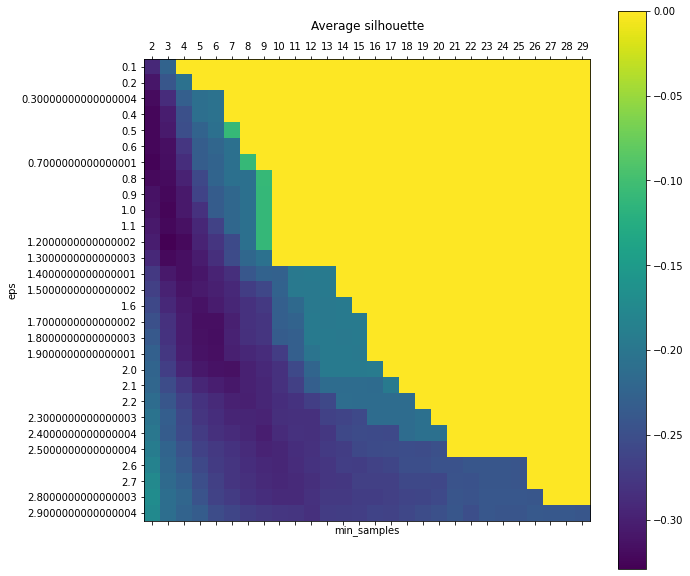

In [ ]:
plt.figure(figsize=(10,10))        
plt.matshow(silhouette, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Average silhouette')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

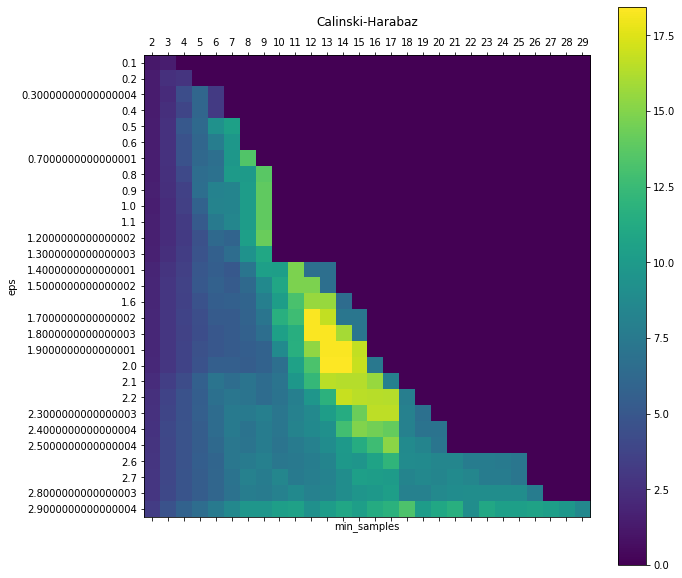

In [ ]:
plt.figure(figsize=(10,10))        
plt.matshow(calinski, fignum=1)
plt.colorbar()
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Calinski-Harabaz')
plt.xticks(np.arange(len(min_sample_values)), min_sample_values)
plt.yticks(np.arange(len(eps_values)), eps_values)
plt.show()

We got very bad values of both metrics, i.e. in this case, the DBSCAN is not suitable for describing the data structure.

# Spectral clustering

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

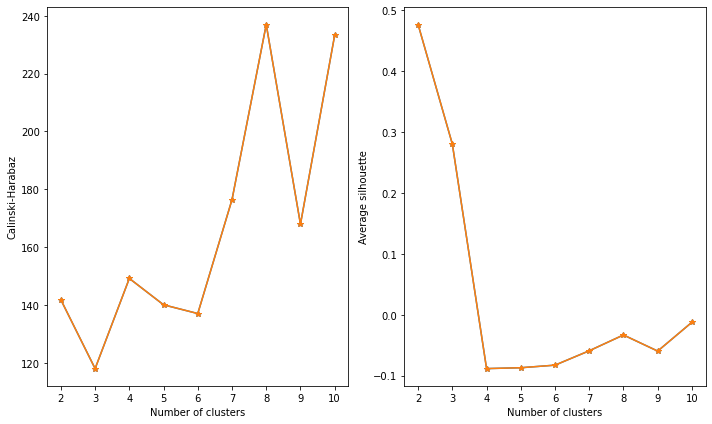

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.arange(2, 11)
for k in params:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10, n_jobs=4) 
    # Further we will omit affinity='euclidean', as it is the default value
    spectral.fit(df_ds)
    Jc.append(calinski_harabasz_score(df_ds, spectral.labels_))
    Js.append(silhouette_score(df_ds, spectral.labels_))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()

In this case, the Calinski-Harabaz measure is almost constantly increase, while Average silhouette is decreased. So, let's see what happens while devoting in 2-10 clusters.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

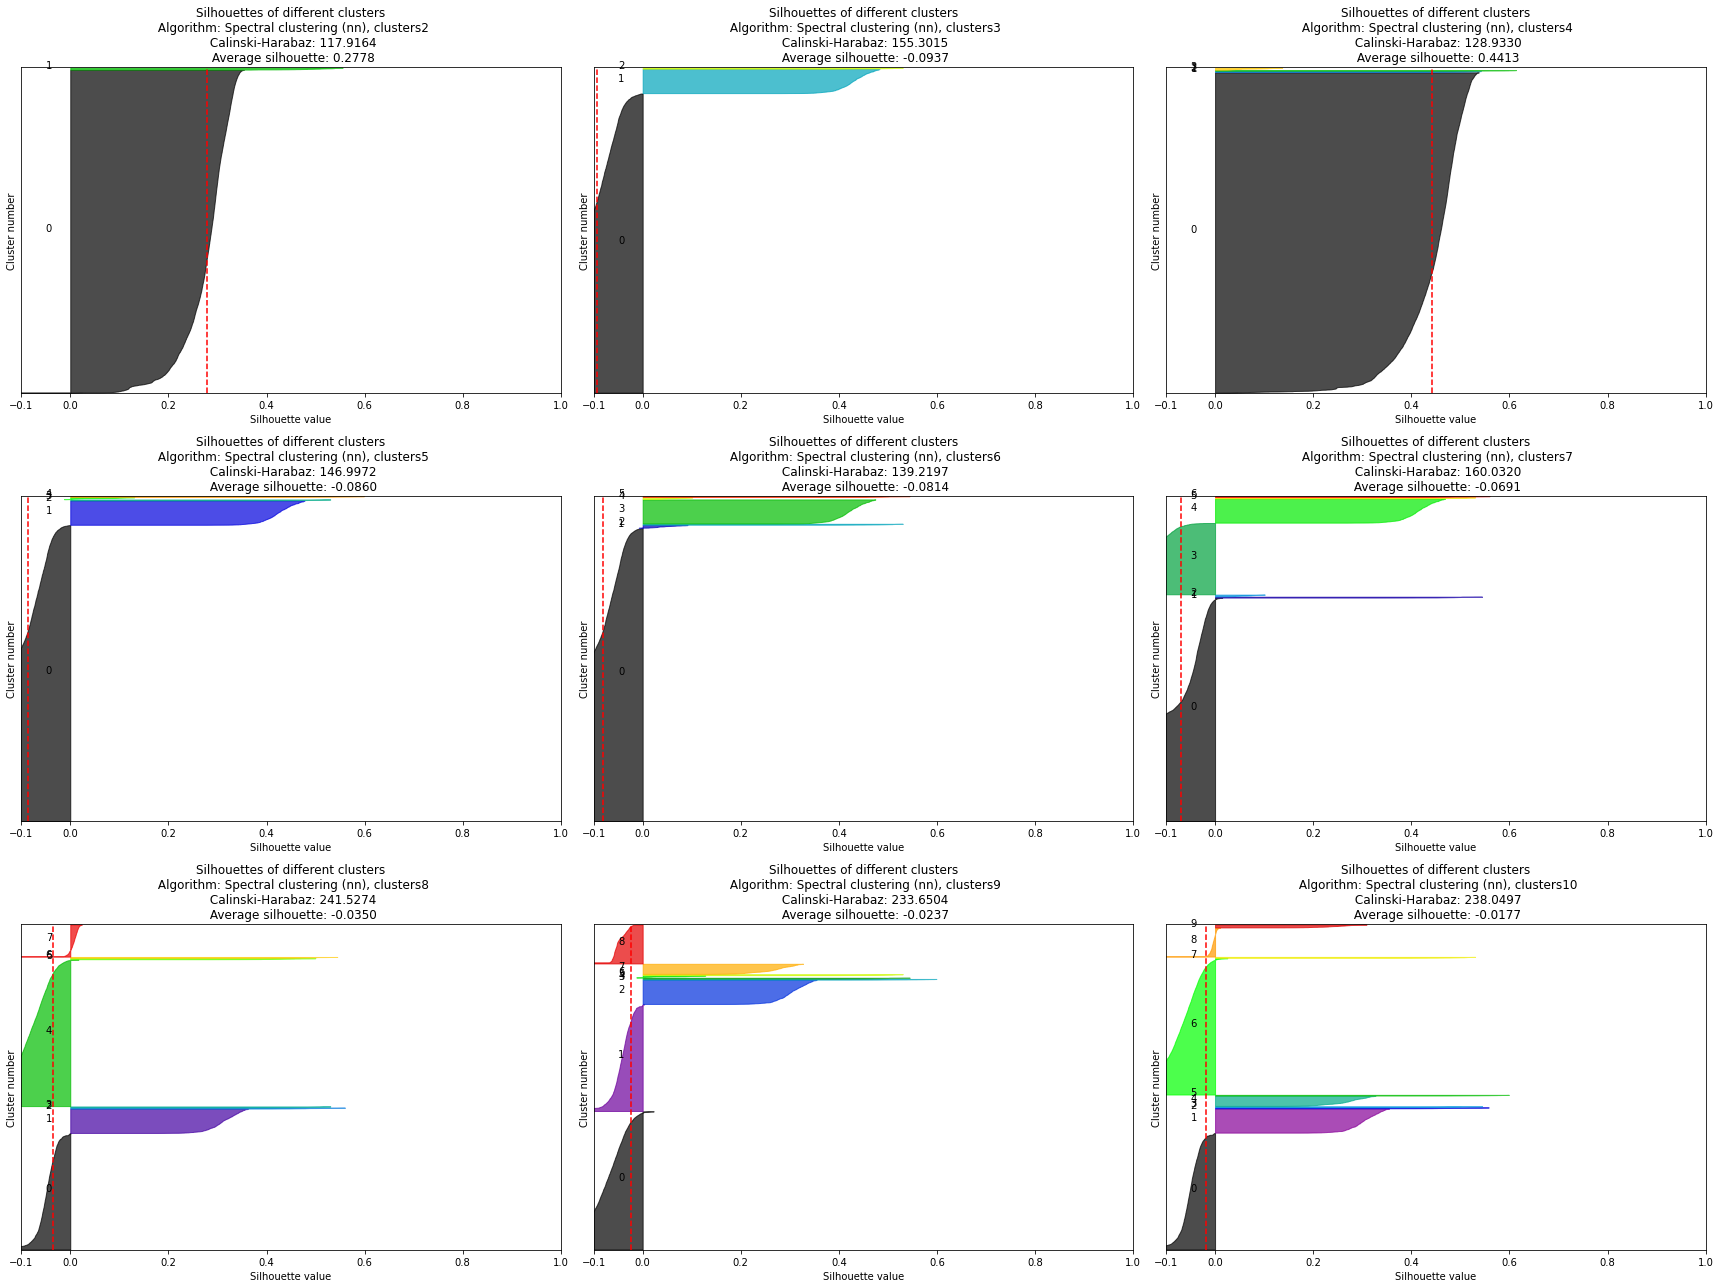

In [ ]:
estimate_param(df_ds, range(2, 11), 'Spectral clustering (nn), clusters')

In comparison with to K-Means, we improved the results for the average silhouette, but worsened for another measure. While in comparison with to Average, we improved the results for the calinski harabasz, but worsened for  average silhouette.

In [ ]:
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=10) 
spectral.fit(df_ds)
value_counts(data[cat_features], spectral.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


---- INCOME_BASE_TYPE ---
cluster                                      0     1
INCOME_BASE_TYPE                                    
2НДФЛ                                   3263.0  35.0
unknown                                   61.0   NaN
Поступление зарплаты на счет            3099.0  15.0
Свободная форма с печатью работодателя   892.0   7.0
Форма банка (без печати работодателя)   2841.0  29.0
---- CREDIT_PURPOSE ---
cluster                                   0     1
CREDIT_PURPOSE                                   
Другое                                334.0   4.0
Лечение                               111.0   1.0
Обучение                              122.0   NaN
Отпуск                                381.0   4.0
Покупка автомобиля                   1751.0  16.0
Покупка бытовой техники               149.0   1.0
Покупка земли                         137.0   2.0
Покупка мебели                        192.0   1.0
Покупка недвижимости/ строительство  1380.0  11.0
Ремонт                       

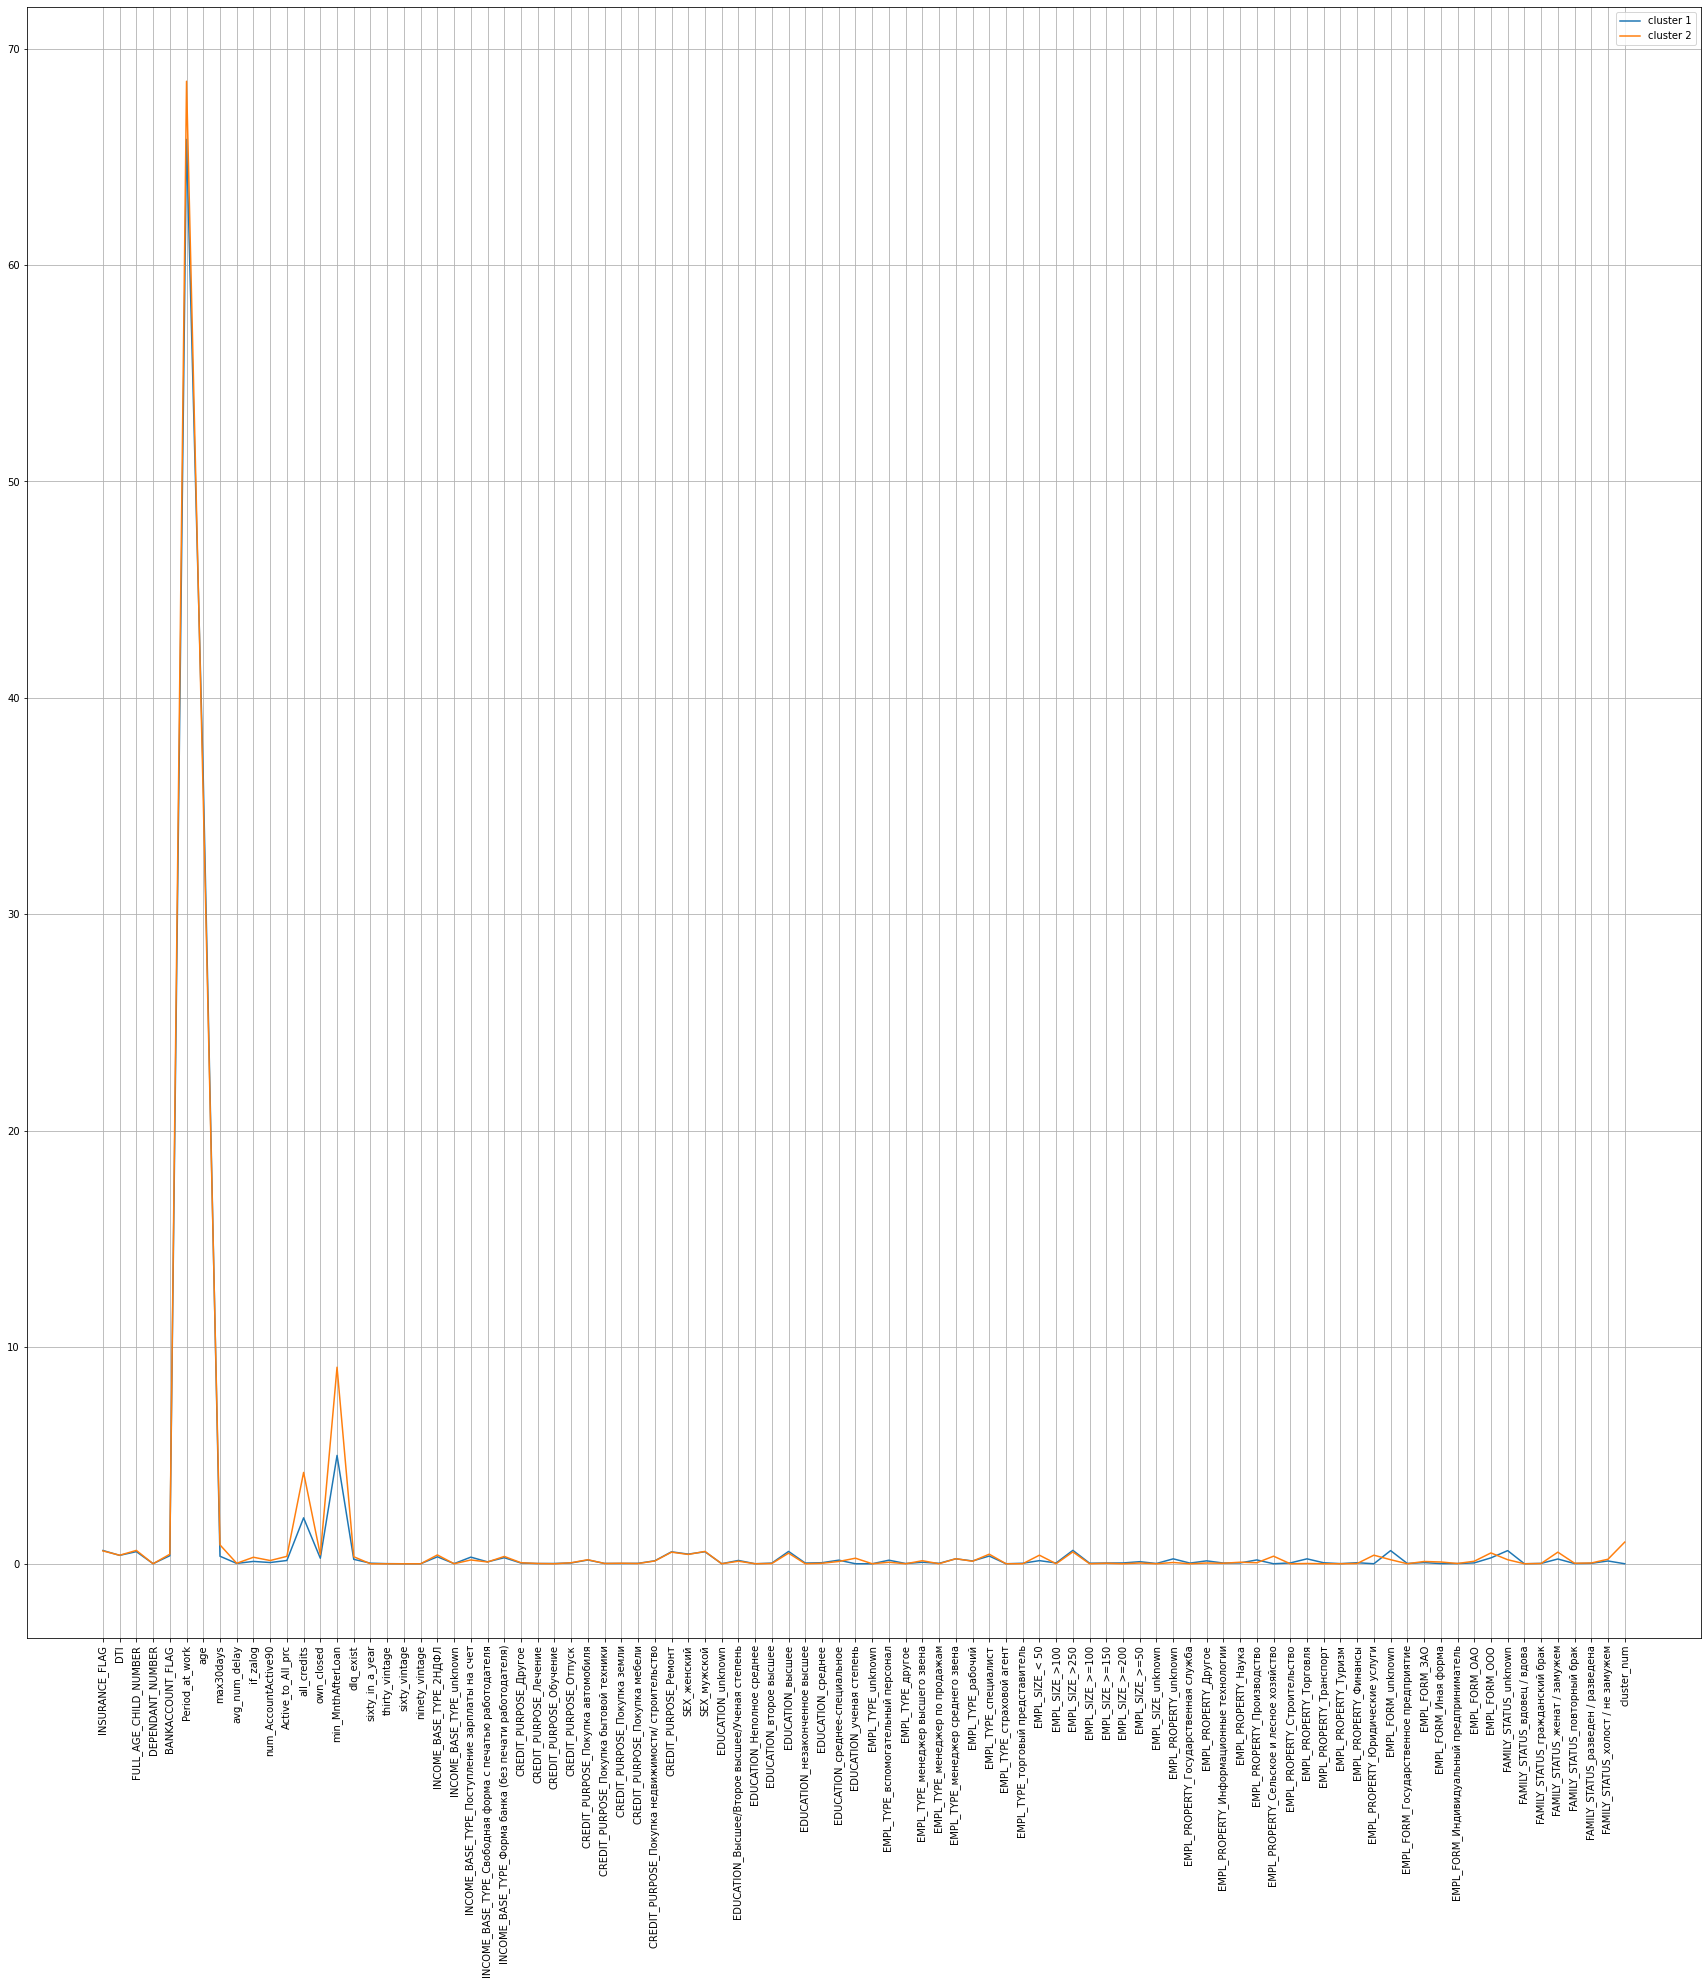

In [ ]:
df_d['cluster_num'] = spectral.labels_

plt.figure(figsize=(30,30))

for i in range(2):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

# Mean Shift

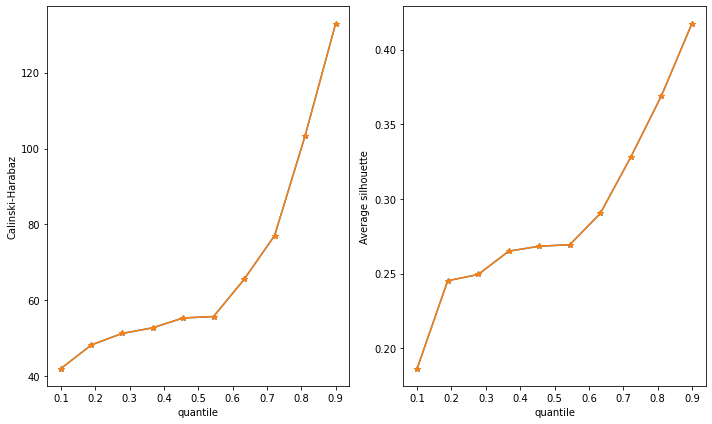

In [ ]:
from sklearn import cluster

fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.linspace(0.1, 0.9, 10)
for k in params:
  bandwidth = cluster.estimate_bandwidth(df_ds, quantile=k)
  ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
  ms.fit(df_ds)
  y_ms = ms.predict(df_ds)
  Jc.append(calinski_harabasz_score(df_ds, y_ms))
  Js.append(silhouette_score(df_ds, y_ms))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('quantile')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('quantile')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()




In this case, the Calinski-Harabaz measure is almost constantly increase, while Average silhouette is decreased. So, let's see what happens while devoting in 2-10 clusters.

Algorithm: Mean Shift
Calinski-Harabaz: 132.8753
Average silhouette: 0.4173


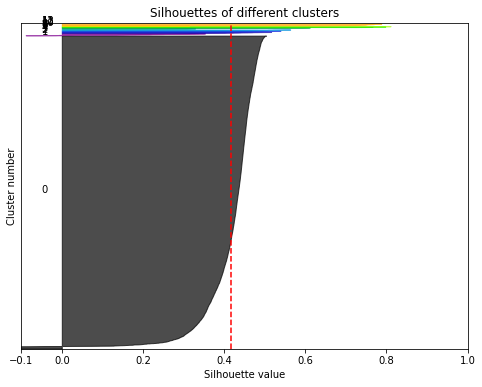

In [ ]:
bandwidth = cluster.estimate_bandwidth(df_ds, quantile=0.9)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df_ds)
y_ms = ms.predict(df_ds)

estimate_cluster(df_ds, y_ms, 'Mean Shift')

Mean Shift outperform Spectral one. In comparison with to K-Means, we improved the results for the average silhouette, but worsened for another measure. While in comparison with to Average, we improved the results for the calinski harabasz, but worsened for average silhouette.

In [ ]:
value_counts(data[cat_features], y_ms)

---- INCOME_BASE_TYPE ---
cluster                                     0     1     2   ...    11   12   13
INCOME_BASE_TYPE                                            ...                
2НДФЛ                                   3229.0  12.0  10.0  ...   NaN  1.0  NaN
unknown                                    6.0   NaN   NaN  ...  54.0  NaN  NaN
Поступление зарплаты на счет            3045.0  32.0   6.0  ...   NaN  NaN  NaN
Свободная форма с печатью работодателя   882.0   6.0   5.0  ...   NaN  NaN  NaN
Форма банка (без печати работодателя)   2808.0  11.0  13.0  ...   NaN  NaN  1.0

[5 rows x 14 columns]
---- CREDIT_PURPOSE ---
cluster                                  0     1     2   ...    11   12   13
CREDIT_PURPOSE                                           ...                
Другое                                330.0   1.0   2.0  ...   1.0  NaN  NaN
Лечение                               109.0   1.0   1.0  ...   NaN  NaN  NaN
Обучение                              121.0   1.0   NaN  ..

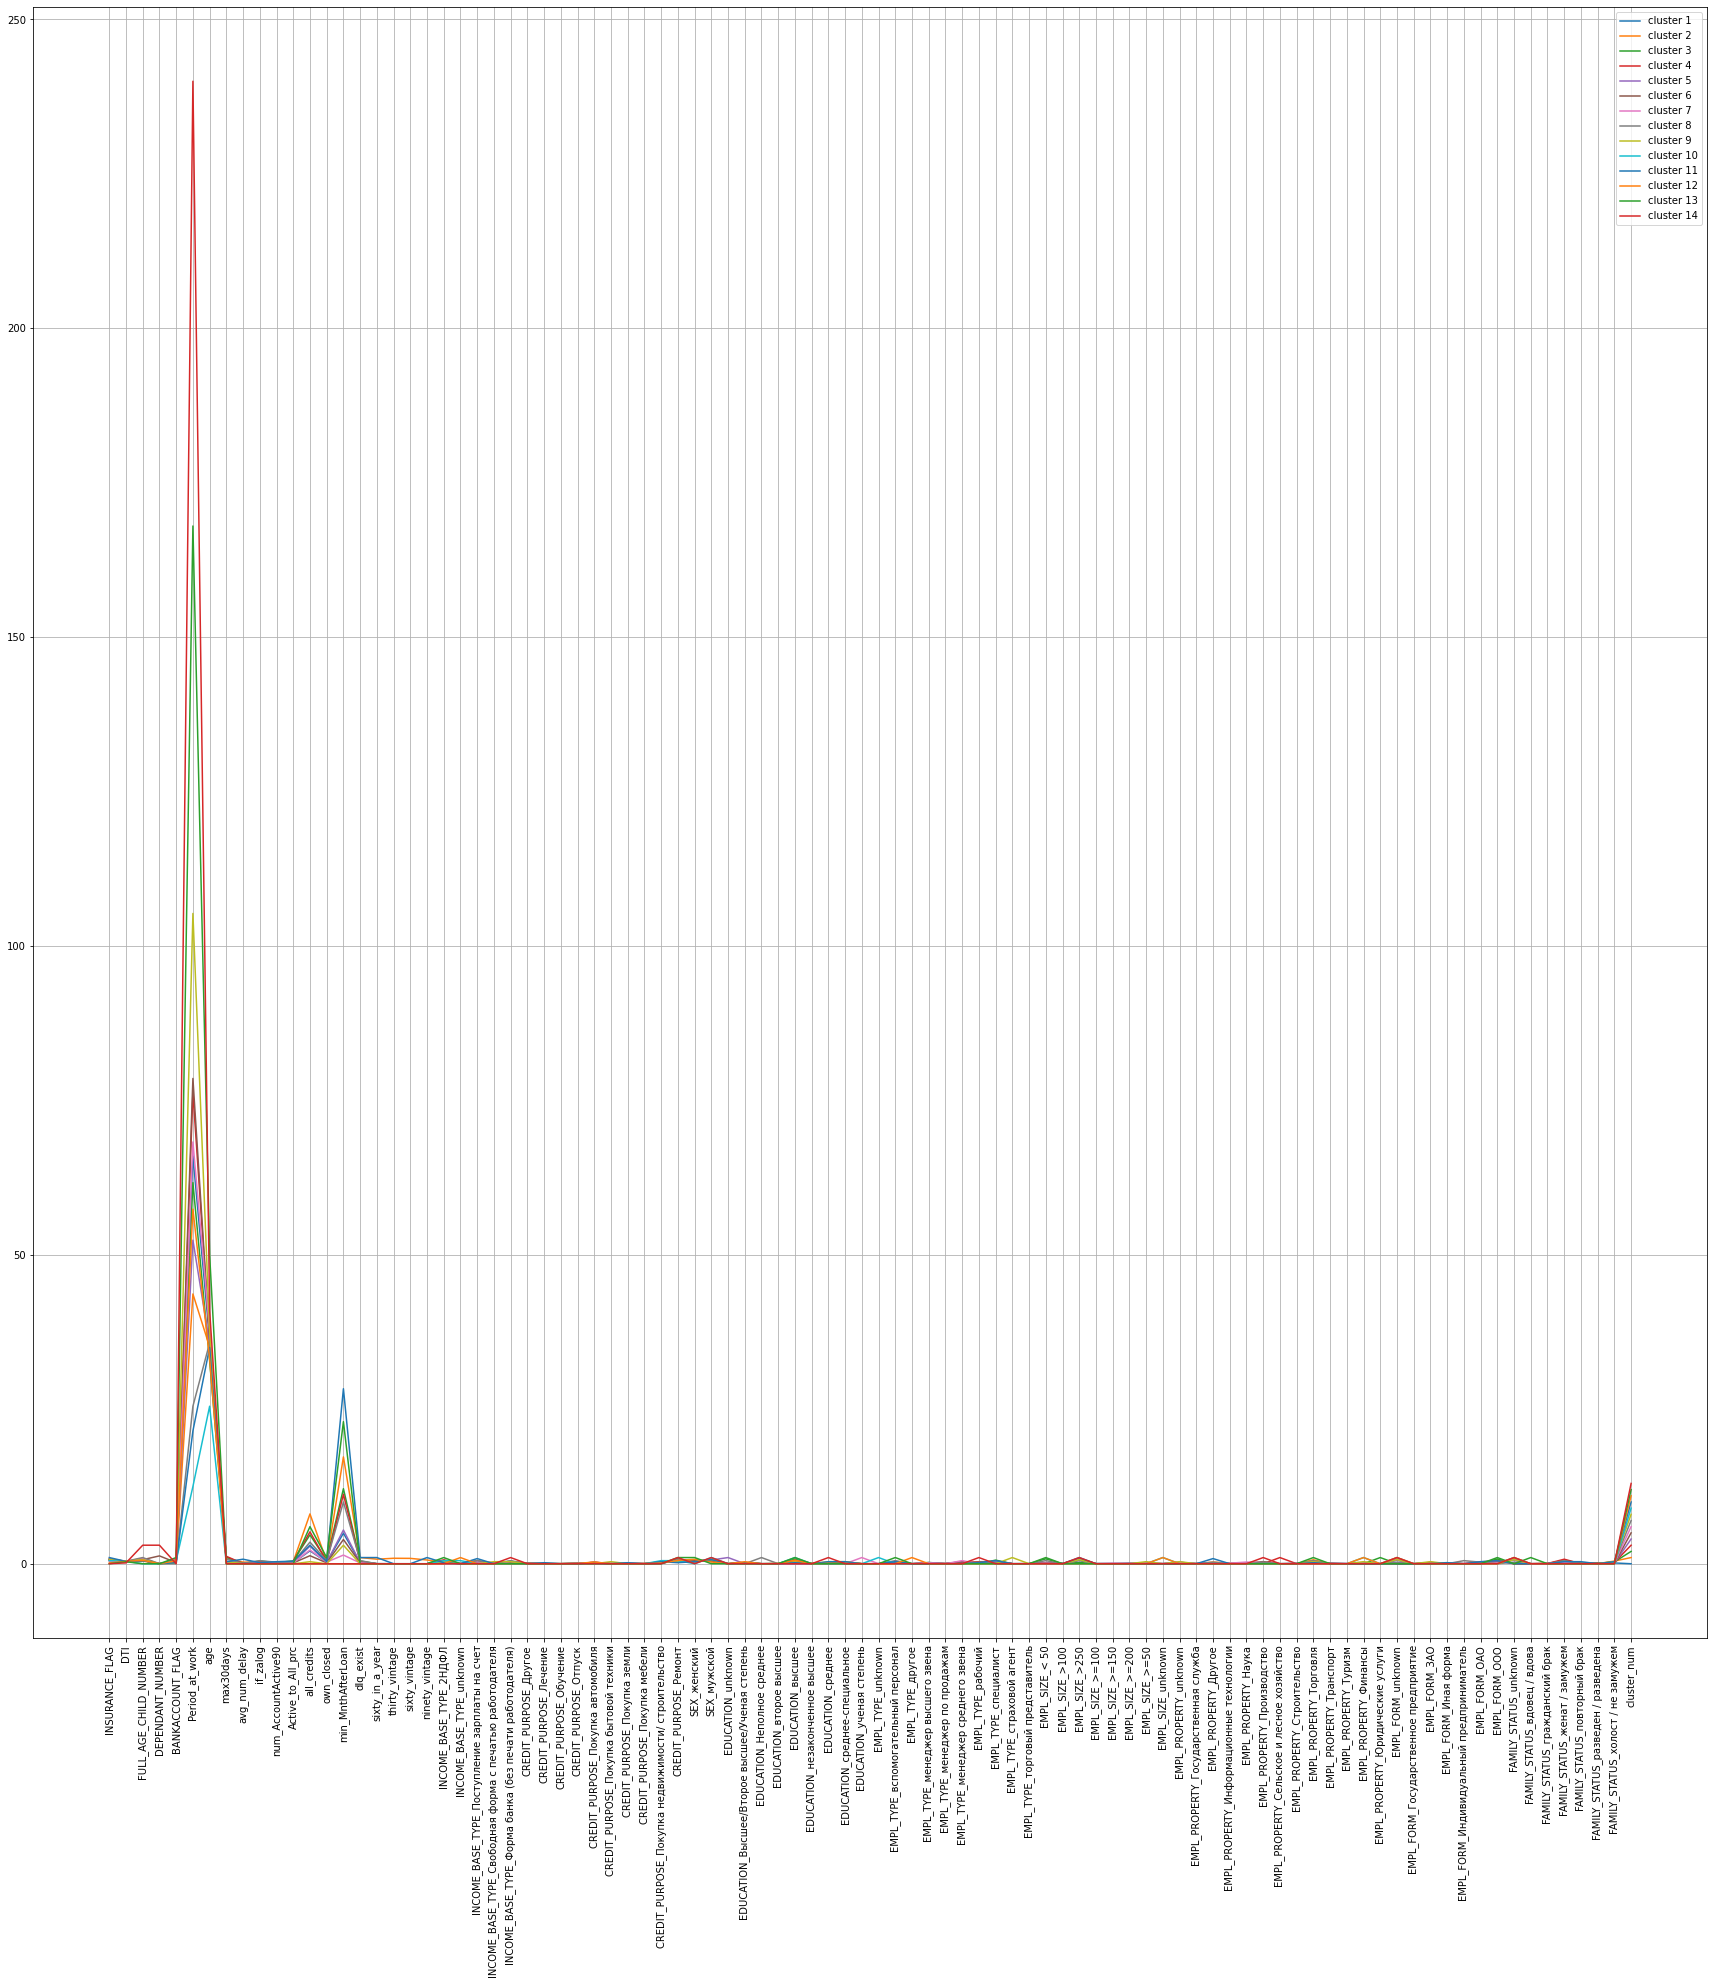

In [ ]:
df_d['cluster_num'] = y_ms

plt.figure(figsize=(30,30))

for i in range(14):
    plt.plot(df_d.columns, df_d[df_d.cluster_num == i].mean(), label='cluster {}'.format(i+1))
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

# MiniBatch K-Means

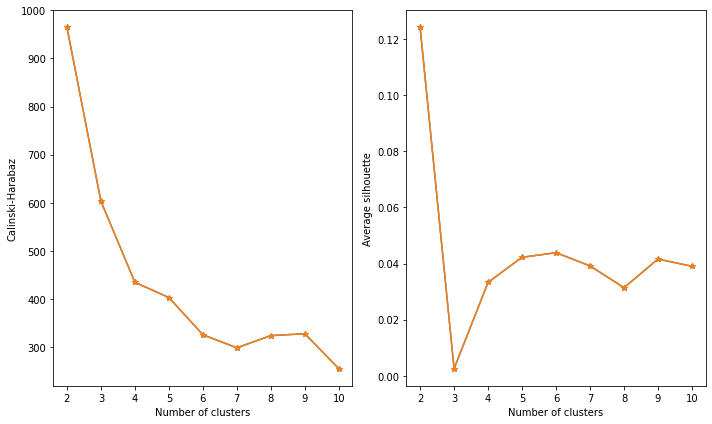

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=( 10, 6))
fig.tight_layout()

Jc = []
Js = []
params = np.arange(2, 11)
for k in params:
    k_means = cluster.MiniBatchKMeans(n_clusters=k)
    k_means.fit(df_ds)
    Jc.append(calinski_harabasz_score(df_ds, k_means.predict(df_ds)))
    Js.append(silhouette_score(df_ds, k_means.predict(df_ds)))
Js = np.array(Js)
Jc = np.array(Jc)
ax[0].plot(params, Jc, '-*')
ax[0].plot(params, Jc, '-*')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Calinski-Harabaz')
ax[1].plot(params, Js, '-*')
ax[1].plot(params, Js, '-*')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Average silhouette')

plt.tight_layout()

Both measures have high values for dividing in 2 clusters. Let's see what happens in those cases.

Algorithm: MiniBatch K-Means
Calinski-Harabaz: 965.0401
Average silhouette: 0.1242


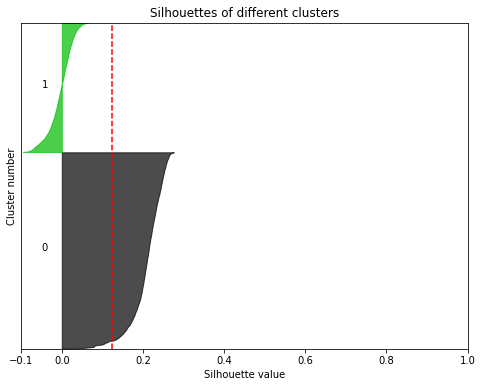

In [ ]:
k_means = cluster.MiniBatchKMeans(n_clusters=2)
y_km = k_means.fit_predict(df_ds)

estimate_cluster(df_ds, y_km, 'MiniBatch K-Means')

It has the same results as K-Means.

#  Decision Tree

In [ ]:
categorical = data.dtypes[data.dtypes == 'object'].index
numeric = data.select_dtypes([np.number])
print(categorical, numeric)

Index(['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'SEX', 'EDUCATION', 'EMPL_TYPE',
       'EMPL_SIZE', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS'],
      dtype='object')        INSURANCE_FLAG   DTI  ...  sixty_vintage  ninety_vintage
0                   0  0.57  ...            0.0             0.0
1                   1  0.52  ...            0.0             0.0
2                   1  0.27  ...            0.0             0.0
3                   1  0.28  ...            0.0             0.0
4                   0  0.23  ...            0.0             0.0
...               ...   ...  ...            ...             ...
10238               0  0.36  ...            0.0             0.0
10239               1  0.23  ...            0.0             0.0
10240               1  0.59  ...            0.0             0.0
10241               0  0.23  ...            0.0             0.0
10242               1  0.35  ...            0.0             0.0

[10243 rows x 20 columns]


In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric.columns)
])

In [ ]:
df_1 = data[categorical]
df_2 = data[numeric.columns]
df3 = pd.concat([df_1, df_2], axis=1)

In [ ]:
df2 = column_transformer.fit_transform(df3)

In [ ]:
feature_names_ohe = column_transformer.transformers_[0][1].get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
new_features = list(numeric.columns) + list(feature_names_ohe)

In [ ]:
df2 = pd.DataFrame(df2, columns=new_features)

In [ ]:
from sklearn.tree import export_graphviz
tree = DecisionTreeClassifier(random_state=42)
X = df2.drop(['dlq_exist'], axis=1)
y = df2['dlq_exist']
tree.fit(X.values, y.values)

export_graphviz(tree, feature_names=list(X.columns), out_file='./tree_dlq_exist.dot', filled=True)


In [ ]:
!dot -Tpng './tree_dlq_exist.dot' -o './tree_dlq_exist.png'

In [ ]:
from PIL import Image
im = Image.open('./tree_dlq_exist.png')

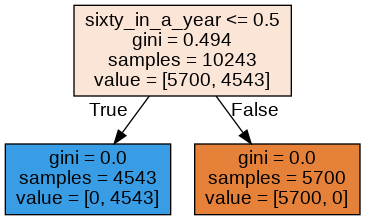

In [ ]:
im